## AIM 2: Longitudinal tumor delta-radiomics can predict RT response

### calculate delta radiomics via relative ([F5 - F1] / F1) and absolute change ([F5 - F1])
1. Progression Free Survival: (PFS) was quantified time from MRgRT to latest follow-up or a (local or distant) progression event.
* Use [Date of first progression]. If no documented progression, last known date without progression 
* Use [Radiation start date].
* PFS('Progression Free Survival Days') = ['Date of first progression. If no documented progression, last known date without progression '] - ['Radiation start date']
2. Visualize delta radiomics from F1 to F5. Draw line plots.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
from lifelines import CoxPHFitter
import seaborn as sns
plt.style.use('default')  # Set the default style
import warnings
warnings.filterwarnings('ignore')

In [2]:
# use mutual stable features from the temporal & spatial stable ones (5 runs)
# temporal stable features: stable_fea_names
ccc_df = pd.read_csv('binCount=64/ccc_dfT_0612.csv')
stable_fea_names = list(ccc_df.loc[(ccc_df['sim_F1'] > 0.9)]['Unnamed: 0'])

# spatial stable features: spatial_stable_features
# havent change path to new path
ccc_df1 = pd.read_csv('binCount=64/run1/ccc_dfT_er_sims_randint36.csv')
ccc_df2 = pd.read_csv('binCount=64/run2/ccc_dfT_er_sims_randint36_2.csv')
ccc_df3 = pd.read_csv('binCount=64/run3/ccc_dfT_er_sims_randint36_3.csv')
ccc_df4 = pd.read_csv('binCount=64/run4/ccc_dfT_er_sims_randint36_4.csv')
ccc_df5 = pd.read_csv('binCount=64/run5/ccc_dfT_er_sims_randint36_5.csv')
# ccc values for all 5 runs
ccc_all_df = ccc_df1
ccc_all_df = ccc_all_df.rename(columns = {'sim_sim': '1', 'Unnamed: 0': 'Features'})
ccc_all_df['2'] = ccc_df2.sim_sim
ccc_all_df['3'] = ccc_df3.sim_sim
ccc_all_df['4'] = ccc_df4.sim_sim
ccc_all_df['5'] = ccc_df5.sim_sim
ccc_all_df2 = ccc_all_df.iloc[:,1:6]
ccc_all_df2 = ccc_all_df2.astype(float)
ccc_all_df2[ccc_all_df2 > 0.9] = 1
ccc_all_df2[ccc_all_df2 < 0.9] = 0
ccc_all_df2.insert(0,'Features', ccc_all_df['Features'])
#ccc_all_df2.to_csv('ccc_all_df2.csv')
# select stable features with value 1 in 5 runs
spatial_stable_features = list(ccc_all_df2.loc[(ccc_all_df2['1'] == 1) & 
                                               (ccc_all_df2['2'] == 1) & 
                                               (ccc_all_df2['3'] == 1) & 
                                               (ccc_all_df2['4'] == 1) & 
                                               (ccc_all_df2['5'] == 1)].Features)
len(spatial_stable_features) # 79

# find both temporal & spatial stable features
common_list = [c for c in stable_fea_names if c in spatial_stable_features]
common_list_df = pd.DataFrame(common_list, columns = ['common_list'])
print(len(common_list_df))
#common_list_df.to_csv('binCount=64/common_list_0612.csv')
# ccc_all_df2[ccc_all_df2['Fee'].isin(list_of_values)]

47


##### Spreadsheet of 40 patients with all clinical features: 'binCount=64/f1_all_2.csv'
Note: only f1 matched with clinical data

In [3]:
# Preprocess Clinical data and Merge with fraction feature data

# read datasets with different fractions
f1 = pd.read_csv('binCount=64/y1_df_0612.csv')
f2 = pd.read_csv('binCount=64/y2_df_0612.csv')
f3 = pd.read_csv('binCount=64/y3_df_0612.csv')
f4 = pd.read_csv('binCount=64/y4_df_0612.csv')
f5 = pd.read_csv('binCount=64/y5_df_0612.csv')
fsim = pd.read_csv('binCount=64/ysim_df_0612.csv')

# clinical dataset
cli_data = pd.read_csv('Data/11286ThoracicRadiati_DATA_LABELS_2023-02-01_0756.csv', encoding='cp1252', on_bad_lines='skip', dtype='unicode')
# update wrong date '2813-05-04' to '2013-05-04' (1683th)
cli_data = cli_data.replace('2813-05-04', '2013-05-04')
cli_data = cli_data.rename(columns = {'ï»¿PIN': 'PIN'})
# convert string to date
#pfs_date = cli_data['Date of first progression. If no documented progression, last known date without progression '] - cli_data['Radiation start date']
#pfs_date
cli_data['Date of first progression. If no documented progression, last known date without progression '] = pd.to_datetime(cli_data['Date of first progression. If no documented progression, last known date without progression '])
cli_data['Radiation start date'] = pd.to_datetime(cli_data['Radiation start date'], format = '%Y-%m-%d')
cli_data['Progression Free Survival Days'] = cli_data['Date of first progression. If no documented progression, last known date without progression '] - cli_data['Radiation start date']
cli_data['Progression Free Survival Days'] = cli_data['Progression Free Survival Days'].dt.days
# shorter cli_data with only PMRN and pfs
cli_data_short = cli_data[['PMRN', 'Progression Free Survival Days']]

# match clinical data with radiomic feature values
# f1: pat_id, cli_data: PMRN
f1['pat_id'] = f1['pat_id'].apply(lambda x: f'{x:.0f}').astype(str)
f2['pat_id'] = f2['pat_id'].apply(lambda x: f'{x:.0f}').astype(str)
f3['pat_id'] = f3['pat_id'].apply(lambda x: f'{x:.0f}').astype(str)
f4['pat_id'] = f4['pat_id'].apply(lambda x: f'{x:.0f}').astype(str)
f5['pat_id'] = f5['pat_id'].apply(lambda x: f'{x:.0f}').astype(str)
fsim['pat_id'] = fsim['pat_id'].apply(lambda x: f'{x:.0f}').astype(str)
# remove patients with ids: 10061253158, 10086126256
f1 = f1[(f1.pat_id != '10061253158') & (f1.pat_id != '10086126256')].reset_index()
f3 = f3[(f3.pat_id != '10061253158') & (f3.pat_id != '10086126256')].reset_index()
f4 = f4[(f4.pat_id != '10061253158') & (f4.pat_id != '10086126256')].reset_index()
f5 = f5[(f5.pat_id != '10061253158') & (f5.pat_id != '10086126256')].reset_index()
fsim = fsim[(fsim.pat_id != '10061253158') & (fsim.pat_id != '10086126256')].reset_index()
# save to files
#f1_fea.to_csv('binCount=64/f1_fea.csv')
#f2_fea.to_csv('binCount=64/f2_fea.csv')
#f3_fea.to_csv('binCount=64/f3_fea.csv')
#f4_fea.to_csv('binCount=64/f4_fea.csv')
#f5_fea.to_csv('binCount=64/f5_fea.csv')

In [4]:
# delta radiomics ratios (F5 / F1), relative ([F5 - F1] / F1), absolute change ([F5 - F1])
f1_fea = f1[common_list]
f2_fea = f2[common_list]
f3_fea = f3[common_list]
f4_fea = f4[common_list]
f5_fea = f5[common_list]
fsim_fea = fsim[common_list]
f5_f1_ratio = f5_fea.div(f1_fea).reset_index().drop(columns=['index'])
#f5_f1_ratio.to_csv('binCount=64/f5_f1_ratio.csv')
relative_f5_f1 = (f5_fea - f1_fea).div(f1_fea).reset_index()
absolute_f5_f1 = (f5_fea - f1_fea).reset_index()
# check if f5_f1_ratio has infinite value
np.isinf(f5_f1_ratio).sum() # No f5_f1_ratio has infinite value

original_shape_Elongation                             0
original_shape_Flatness                               0
original_shape_LeastAxisLength                        0
original_shape_MajorAxisLength                        0
original_shape_Maximum2DDiameterColumn                0
original_shape_Maximum2DDiameterRow                   0
original_shape_Maximum2DDiameterSlice                 0
original_shape_Maximum3DDiameter                      0
original_shape_MeshVolume                             0
original_shape_MinorAxisLength                        0
original_shape_Sphericity                             0
original_shape_SurfaceArea                            0
original_shape_SurfaceVolumeRatio                     0
original_shape_VoxelVolume                            0
original_firstorder_10Percentile                      0
original_firstorder_90Percentile                      0
original_firstorder_Energy                            0
original_firstorder_Mean                        

In [5]:
# For clinical data
def closest_date(items, goal):
    '''convert goal to timestamp data type and return the closest date to goal date
    Args:
    items: list of dates
    goal: [mr_image_path date]
    '''
    goal = pd.to_datetime(goal, format = '%Y-%m-%d')
    return min(items, key=lambda x: abs(x - goal))

In [6]:
# method 1
# Match [mr_image_path date] in f1 with [Radiation start date] and 
# [Date of first progression. If no documented progression, last known date without progression ] in clinical data --> find index in clinical data
# Match all clinical variables by index
mr_date = []
for i in range(0,len(f1)):
    mr_date.append(f1['mr_image_path'][i].split('/')[-1].split('_')[3])
f1['mr_date'] = mr_date
#f1.to_csv('f1_mr_date.csv')

rsds = []
fp_dates = []
indices = [] # index of row

for i in range(len(f1)):
    if len(cli_data.loc[cli_data['PMRN'] == f1['pat_id'][i]]) == 1:
        # if PMRN has unique (1) record in clinical data, then use its RSD and DFP
        rsds.append(cli_data.loc[cli_data['PMRN'] == f1['pat_id'][i], 'Radiation start date'].item())
        fp_dates.append(cli_data.loc[cli_data['PMRN'] == f1['pat_id'][i], 'Date of first progression. If no documented progression, last known date without progression '].item())
        indices.append(cli_data.loc[cli_data['PMRN'] == f1['pat_id'][i]].index.to_list()[0] - 1)
    else:
        # else select RSD close to [mr_image_path date]
        dates = []
        for j in range(len(cli_data.loc[cli_data['PMRN'] == f1['pat_id'][i]])):
            dates.append(cli_data.loc[cli_data['PMRN'] == f1['pat_id'][i]].iloc[j]['Radiation start date'])
            #f1['mr_date'][i] - cli_data.loc[cli_data['PMRN'] == f1['pat_id'][i]].iloc[j]['Radiation start date']
        rsds_close_date = closest_date(dates, f1['mr_date'][i])
        rsds.append(rsds_close_date)
        # find the corresponding pfs date
        # df.loc[(df['B'] == 3) & (df['C'] == 6), 'A'].item()
        fp_cor_date = cli_data.loc[(cli_data['PMRN'] == f1['pat_id'][i]) & (cli_data['Radiation start date'] == rsds_close_date), 'Date of first progression. If no documented progression, last known date without progression '].item()
        fp_dates.append(fp_cor_date)
        indices.append(cli_data.loc[(cli_data['PMRN'] == f1['pat_id'][i]) & (cli_data['Radiation start date'] == rsds_close_date)].index.to_list()[0] - 1)
        
f1['Radiation_start_date'] = rsds
f1['Date_of_first_progression'] = fp_dates
# for patient 10124679100, 3 records. Date of first progression is earlier than radiation start date for third record: Radiation_start_date = 2021-03-08. 
# Use 5/27/2021 as this is the progression date after treatment.
f1['Date_of_first_progression'].mask((f1['pat_id'] == '10124679100') & (f1['Radiation_start_date'] == '2021-03-08') ,'5/27/2021', inplace=True)
f1['Date_of_first_progression'].mask((f1['pat_id'] == '10144023610') & (f1['Radiation_start_date'] == '2021-03-19') ,'5/14/2021', inplace=True)
f1['Progression_Free_Survival_Days'] = (f1['Date_of_first_progression'] - f1['Radiation_start_date']).dt.days.astype('int16')
f1['cli_index'] = indices
#f1 = f1.drop(columns=['Unnamed: 0'])
# merge f1 and clinical data
f1['cli_index'] = f1['cli_index'].astype('str')
f1 = pd.merge(f1, cli_data, left_on = 'cli_index', right_on = 'PIN', how = 'inner')
# PFS status changed to column [Progression?]
f1['progression'] = np.where(f1['Progression?'] == 'Yes', 1, 0)
#f1['progression'] = np.where(f1['Date_of_first_progression'].isna() == False , 1, 0)
#f1.to_csv('binCount=64/f1_all_2_new.csv') # final clinical data for patient F1

In [7]:
# check if preprocessing is correct
f1[f1['Radiation_start_date'] == '2021-03-08']['Progression_Free_Survival_Days'] # correct if get 34 80
# progression value in text
f1['progression'].value_counts()[1]
f1.shape # (47, 2116)
f1['Progression_Free_Survival_Days'] # have negative values for 34 & 41
f1['Date of first progression. If no documented progression, last known date without progression '][41]
f1['Date of first locoregional recurrence. If no documented LRR, last known date without LRR (by chest CT or PET-CT)'][41] # '2021-02-09'
f1['Radiation start date'][41] # Timestamp('2021-03-19 00:00:00')

Timestamp('2021-03-19 00:00:00')

clinic data columns: 'mr_date', 'Radiation start date', 'Date of first progression', 'Progression Free Survival Days', 'progression', 'Radiation total dose prescribed (Gy)',
'Radiation total dose delivered (Gy)', 'Radiation dose per fraction (Gy/fx)', 'Radiation number of fractions prescribed ', 'Radiation number of fractions delivered ',
'Biologically equivalent dose to tumor (Gy10)'

#### New Analysis
common_list: stable feature names
1. Show median values, consistent change features (decrease or increase consistently)
2. Variation in dose
* Increase of dose→ increase of delta radiomic feature values
3. Group patients by feature and measure average slope (+/-/0)
4. Correlation for similar trends (pearson correlation? For intrapatient)
5. Clustering for delta features (k-means)
6. F5 to F1, linear average slope

TO DO:  <br>

* After Pearson correlation for collinearity check: <br>

    * K-means for slope (F5-F1)/F1 for all variables & all patients <br>

        * Check centroids, clusters with biggest distance <br>

    * PCA, tSNE, UMAP for multivariable clustering & dimension reduction <br>

        * Check centroids, clusters with biggest distance <br>

    * Slope average highly +/- change, use medians, standard deviations, IQRs <br>

        * Highlight features with median change ⬆/⬇ > 2%/1%: e.g. original_glszm_GrayLevelNonUniformity <br>

        * Line plots for all features by patient index by all variables <br>


##### Pearson Correlation

I removed collinear features by mean correlation with all other features. The correlation threshold is still 0.9. 
Variable pairs with correlation higher than the 0.9 are picked and one of the two variable will be dropped.
Which of the two will be dropped is based on the one having higher mean absolute correlation with all other variables.

In [12]:
# code that saved the dropped features and replaced ones as dict
# Pearson Cross Correlation by Mean Correlation on F1 (f1_fea)
def cross_corr_mean(df_input, corr_coeff=0.95, plot=0, savefile=0):
    """
    The function returns a list of features to be dropped from the input features.

    INPUTS:
    1. df_input: n input features (pandas dataframe)
    2. corr_coeff: Coefficient threshold (absolute value, no negatives) for a pair of variables above which one of the two will be dropped
    3. plot: If set to 1 a plot will be displayed showing a heatmap of the cross-correlation between variables 
    4. savefile: If set to 1, all relevant files will be saved

    PLEASE NOTE:
    - The dataframe df_input (should contain only the n input features i.e. no ID and targets) 

    SUMMARY OF LOGIC:
    1. The n input variables are taken and an n X n matrix of correlation is created (these are absolute values i.e. a correlation of -0.8 is treated as 0.8)
    2. Variable pairs with correlation higher than the corr_coeff threshold are picked, and one of the two variables will be dropped
    3. Which of the two will be dropped is based on the one having lower mean absolute correlation with all other variables 

    SAVED FILES:
    If savefile is set to 1. Saved under the current directory under cross_corr_target under the folder with a UTC timestamp.
    1. A PDF heatmap representing the cross-correlation between all the input features
    2. A CSV of the matrix containing the values used for the heatmap
    3. A CSV of the list of variables to be dropped

    """

    # Pre-processing
    if savefile == 1:
        from datetime import datetime
        time = str(datetime.utcnow())
        import os
        path = str(os.getcwd()) + "/cross_corr_mean/" + str(time[0:19].replace(':',"-")) + "/"
        os.makedirs(path)

    # Generating correlation matrix of input features
    corr_matrix = df_input.corr(method='pearson')

    # Plotting cross-correlation matrix
    if plot == 1:
        import matplotlib.pyplot as plt
        import seaborn as sns
        plt.figure(figsize=(10, 8))
        sns.heatmap(corr_matrix.round(2), cmap=plt.cm.Blues)
        fig = plt.gcf()
        plt.show()
        if savefile == 1:
            fig.savefig(path + "cross_corr_heatmap.pdf")

    # Generating correlation with the target
    corr_mean = abs(corr_matrix).mean()

    # Saving files
    if savefile == 1:
        corr_matrix.to_csv(path + "cross_corr.csv")
        corr_mean.to_csv(path + "corr_abs_mean.csv")

    # Preparing data
    features_drop_dict = {}  # This will contain the dictionary of features to be dropped and their replacements
    features_index_drop_list = []  # This will contain the index of features to be dropped as per df_input
    features_drop_list = [] # This will contain the list of features to be dropped

    # Selecting features to be dropped
    for i in range(corr_matrix.shape[0]):
        for j in range(i + 1, corr_matrix.shape[0]):
            if corr_matrix.iloc[i, j] >= corr_coeff and i not in features_index_drop_list and j not in features_index_drop_list:
                if corr_mean[corr_matrix.columns[i]] >= corr_mean[corr_matrix.columns[j]]:
                    features_drop_dict[corr_matrix.columns[i]] = corr_matrix.columns[j]
                    features_drop_list.append(corr_matrix.columns[i])
                    features_index_drop_list.append(i)
                else:
                    features_drop_dict[corr_matrix.columns[j]] = corr_matrix.columns[i]
                    features_drop_list.append(corr_matrix.columns[j])
                    features_index_drop_list.append(j)

    # Saving final dictionary
    if savefile == 1:
        import pandas as pd
        pd.Series(features_drop_dict).to_csv(path + "features_drop_dict.csv")
        pd.Series(features_drop_list).to_csv(path + "features_drop_list.csv")
        # read features_drop_list from csv file

    return features_drop_dict, corr_matrix, corr_mean


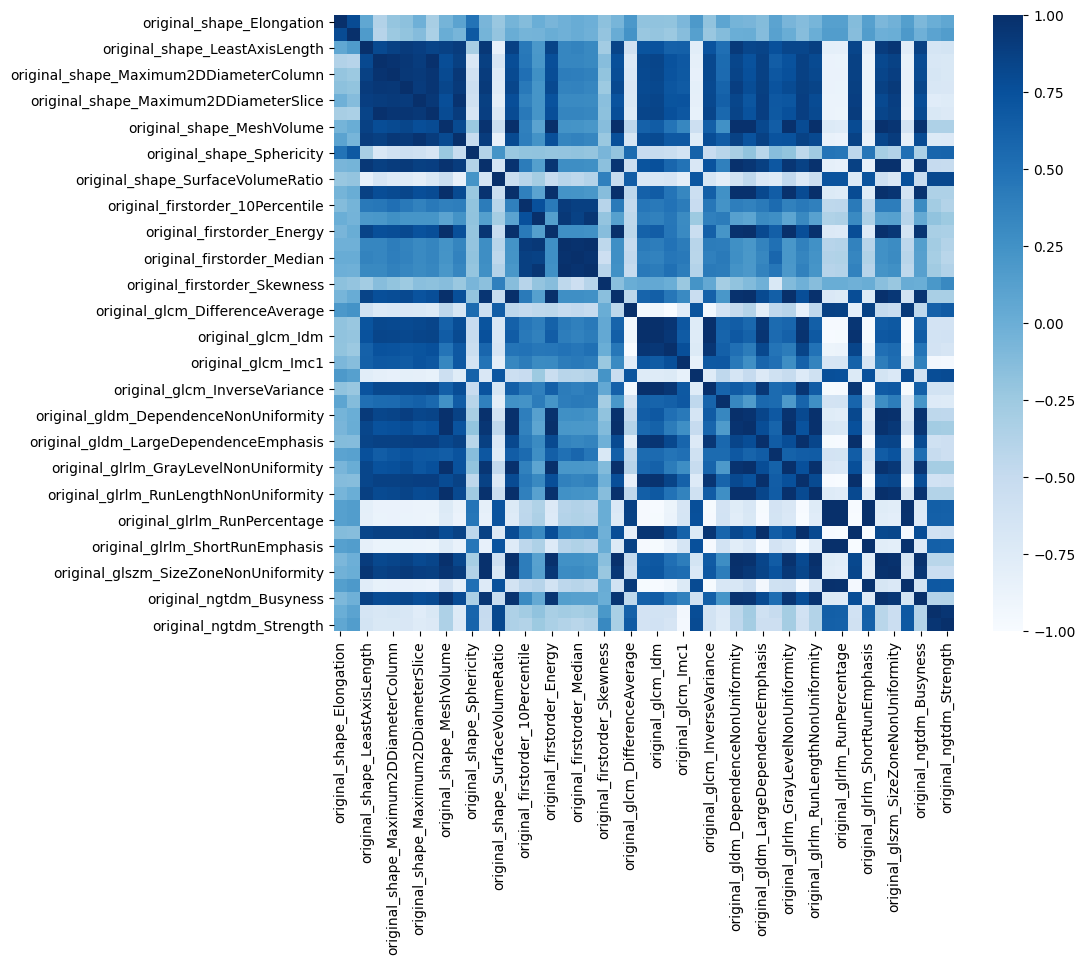

In [17]:
features_drop_dict, corr_matrix_temp, corr_mean_temp = cross_corr_mean(f1_fea, corr_coeff=0.9, plot=1, savefile=1)

##### Relative Feature Analysis

In [11]:
# relative change
relative_f5_f1 = (f5_fea - f1_fea).div(f1_fea).reset_index()
relative_f2_f1 = (f2_fea - f1_fea).div(f1_fea).reset_index()
relative_f3_f2 = (f3_fea - f2_fea).div(f2_fea).reset_index()
relative_f4_f3 = (f4_fea - f3_fea).div(f3_fea).reset_index()
relative_f5_f4 = (f5_fea - f4_fea).div(f4_fea).reset_index()
# absolute change
absolute_f2_f1 = (f2_fea - f1_fea).reset_index()
absolute_f3_f2 = (f3_fea - f2_fea).reset_index()
absolute_f4_f3 = (f4_fea - f3_fea).reset_index()
absolute_f5_f4 = (f5_fea - f4_fea).reset_index()

# replace inf with zeros
def replace_inf_zero(data):
    return data.replace([np.inf, -np.inf], 0, inplace=False)

In [12]:
# relative median by F1
# relative change
relative_f5_f1 = (f5_fea - f1_fea).div(f1_fea).reset_index()
relative_f2_f1 = (f2_fea - f1_fea).div(f1_fea).reset_index()
relative_f3_f1 = (f3_fea - f1_fea).div(f1_fea).reset_index()
relative_f4_f1 = (f4_fea - f1_fea).div(f1_fea).reset_index()
# absolute change
absolute_f2_f1 = (f2_fea - f1_fea).reset_index()
absolute_f3_f1 = (f3_fea - f1_fea).reset_index()
absolute_f4_f1 = (f4_fea - f1_fea).reset_index()
absolute_f5_f1 = (f5_fea - f1_fea).reset_index()

# replace inf with zeros
def replace_inf_zero(data):
    return data.replace([np.inf, -np.inf], 0, inplace=False)

In [13]:
# use cross_corr_mean before running this cell
relative_f2_f1_new = replace_inf_zero(relative_f2_f1).fillna(0)
relative_f2_f1_new = relative_f2_f1_new.drop(features_drop_list, axis=1)
relative_f2_f1_new = relative_f2_f1_new.reset_index(drop=True)
relative_f2_f1_new = relative_f2_f1_new.drop(columns = 'index')
print(len(relative_f2_f1_new.columns))
relative_f3_f2_new = replace_inf_zero(relative_f3_f2).fillna(0)
relative_f3_f2_new = relative_f3_f2_new.drop(features_drop_list, axis=1)
relative_f3_f2_new = relative_f3_f2_new.reset_index(drop=True)
relative_f3_f2_new = relative_f3_f2_new.drop(columns = 'index')
print(len(relative_f3_f2_new.columns))
relative_f4_f3_new = replace_inf_zero(relative_f4_f3).fillna(0)
relative_f4_f3_new = relative_f4_f3_new.drop(features_drop_list, axis=1)
relative_f4_f3_new = relative_f4_f3_new.reset_index(drop=True)
relative_f4_f3_new = relative_f4_f3_new.drop(columns = 'index')
print(len(relative_f4_f3_new.columns))
relative_f5_f4_new = replace_inf_zero(relative_f5_f4).fillna(0)
relative_f5_f4_new = relative_f5_f4_new.drop(features_drop_list, axis=1)
relative_f5_f4_new = relative_f5_f4_new.reset_index(drop=True)
relative_f5_f4_new = relative_f5_f4_new.drop(columns = 'index')
print(len(relative_f5_f4_new.columns))
relative_f5_f1_new = replace_inf_zero(relative_f5_f1).fillna(0)
relative_f5_f1_new = relative_f5_f1_new.drop(features_drop_list, axis=1)
relative_f5_f1_new = relative_f5_f1_new.reset_index(drop=True)
relative_f5_f1_new = relative_f5_f1_new.drop(columns = 'index')
print(len(relative_f5_f1_new.columns))

# relative_fn_f1_new
relative_f3_f1_new = replace_inf_zero(relative_f3_f1).fillna(0)
relative_f3_f1_new = relative_f3_f1_new.drop(features_drop_list, axis=1)
relative_f3_f1_new = relative_f3_f1_new.reset_index(drop=True)
relative_f3_f1_new = relative_f3_f1_new.drop(columns = 'index')
print(len(relative_f3_f1_new.columns))
relative_f4_f1_new = replace_inf_zero(relative_f4_f1).fillna(0)
relative_f4_f1_new = relative_f4_f1_new.drop(features_drop_list, axis=1)
relative_f4_f1_new = relative_f4_f1_new.reset_index(drop=True)
relative_f4_f1_new = relative_f4_f1_new.drop(columns = 'index')
print(len(relative_f4_f1_new.columns))

#relative_f3_f1_new.to_csv('binCount=64/relative_f3_f1_new2.csv')
#relative_f4_f1_new.to_csv('binCount=64/relative_f4_f1_new2.csv')
#relative_f2_f1_new.to_csv('binCount=64/relative_f2_f1_new2.csv')
#relative_f3_f2_new.to_csv('binCount=64/relative_f3_f2_new2.csv')
#relative_f4_f3_new.to_csv('binCount=64/relative_f4_f3_new2.csv')
#relative_f5_f4_new.to_csv('binCount=64/relative_f5_f4_new2.csv')
#relative_f5_f1_new.to_csv('binCount=64/relative_f5_f1_new2.csv')

15
15
15
15
15
15
15


Relative_f5_f1: consistent for all patients (always – or +)
Result: NO

In [14]:
(relative_f5_f1_new > 0).all(axis=0)

original_shape_Elongation                             False
original_shape_Flatness                               False
original_shape_Maximum2DDiameterSlice                 False
original_shape_Sphericity                             False
original_shape_SurfaceVolumeRatio                     False
original_firstorder_90Percentile                      False
original_firstorder_Median                            False
original_firstorder_Skewness                          False
original_glcm_DifferenceAverage                       False
original_glcm_Imc2                                    False
original_gldm_DependenceEntropy                       False
original_gldm_GrayLevelNonUniformity                  False
original_gldm_LargeDependenceHighGrayLevelEmphasis    False
original_glrlm_RunLengthNonUniformityNormalized       False
original_ngtdm_Coarseness                             False
dtype: bool

In [15]:
(relative_f5_f1_new < 0).all(axis=0)

original_shape_Elongation                             False
original_shape_Flatness                               False
original_shape_Maximum2DDiameterSlice                 False
original_shape_Sphericity                             False
original_shape_SurfaceVolumeRatio                     False
original_firstorder_90Percentile                      False
original_firstorder_Median                            False
original_firstorder_Skewness                          False
original_glcm_DifferenceAverage                       False
original_glcm_Imc2                                    False
original_gldm_DependenceEntropy                       False
original_gldm_GrayLevelNonUniformity                  False
original_gldm_LargeDependenceHighGrayLevelEmphasis    False
original_glrlm_RunLengthNonUniformityNormalized       False
original_ngtdm_Coarseness                             False
dtype: bool

In [16]:
abs(relative_f5_f1_new['original_firstorder_Skewness']).max()

17.496664551749028

In [17]:
# pick 2 cases: 1 where Skewness changed a lot from F1 to F5, and another where it didn't change much at all
# 23    17.496665, PMRN: 10077322773
# 14    -0.003628, PMRN: 10068119816
# abs(relative_f5_f1_new['original_firstorder_Skewness']).min()
relative_f5_f1_new['original_firstorder_Skewness']

0      0.085814
1      0.123183
2      3.132601
3     -0.055977
4      1.746348
5     -0.454093
6      1.260326
7     -0.021949
8     -0.484284
9      0.952387
10    -0.650475
11    -0.317181
12    -0.027062
13    -4.300372
14    -0.003628
15    -0.087339
16     0.294348
17    -0.033397
18    -0.638725
19    -0.116737
20    -0.426379
21     0.606807
22    -0.775187
23    17.496665
24     0.933818
25    -0.068431
26    -0.517306
27    -0.084699
28     1.977540
29     6.250336
30     0.287528
31     0.465403
32    -0.322329
33    -1.658766
34    -0.307370
35     0.331079
36    -1.183623
37    -2.468078
38    -0.353669
39    -0.600897
40    -0.787298
41     1.929459
42    -0.327479
43    -0.279436
44    -0.203020
45    -0.245217
46     0.610740
Name: original_firstorder_Skewness, dtype: float64

In [18]:
print(relative_f5_f1_new['original_firstorder_Skewness'][23],
relative_f4_f1_new['original_firstorder_Skewness'][23],
relative_f3_f1_new['original_firstorder_Skewness'][23],
relative_f2_f1_new['original_firstorder_Skewness'][23])
print(relative_f5_f1_new['original_firstorder_Skewness'][14],
relative_f4_f1_new['original_firstorder_Skewness'][14],
relative_f3_f1_new['original_firstorder_Skewness'][14],
relative_f2_f1_new['original_firstorder_Skewness'][14])

17.496664551749028 15.80940762456454 12.12179847064575 9.37735138413428
-0.0036279051549064027 0.40373770707467377 0.42098126087970084 0.20306839428485235


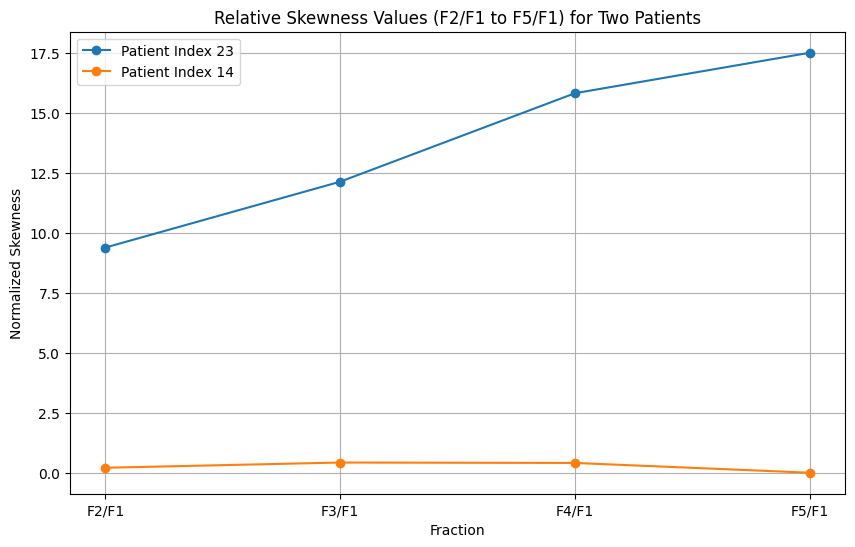

In [21]:
import matplotlib.pyplot as plt

# Data for each patient
patient_23_values = [9.37735138413428, 12.12179847064575, 15.80940762456454, 17.496664551749028]  # F2 to F5 for patient at index 23
patient_14_values = [0.20306839428485235, 0.42098126087970084, 0.40373770707467377, -0.0036279051549064027]  # F2 to F5 for patient at index 14

# Corresponding fractions
fractions = ['F2/F1', 'F3/F1', 'F4/F1', 'F5/F1']

# Create line plots
plt.figure(figsize=(10, 6))
plt.plot(fractions, patient_23_values, marker='o', linestyle='-', label='Patient Index 23')
plt.plot(fractions, patient_14_values, marker='o', linestyle='-', label='Patient Index 14')

plt.title('Relative Skewness Values (F2/F1 to F5/F1) for Two Patients')
plt.xlabel('Fraction')
plt.ylabel('Normalized Skewness')
plt.legend()
plt.grid(True)
plt.show()


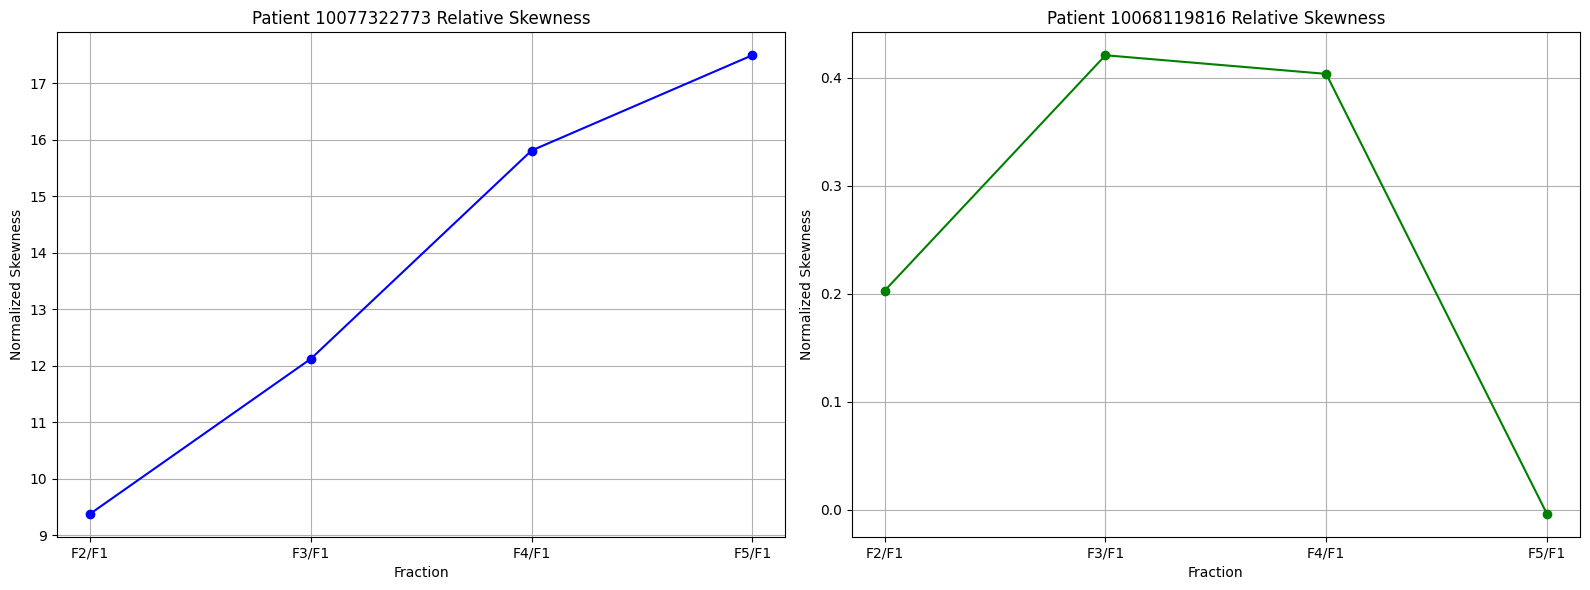

In [20]:
plt.style.use('default')  # Set the default style
# Separate plots for each patient for clarity
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
patient_23_values = [9.37735138413428, 12.12179847064575, 15.80940762456454, 17.496664551749028]  # F2 to F5 for patient at index 23
patient_14_values = [0.20306839428485235, 0.42098126087970084, 0.40373770707467377, -0.0036279051549064027]  # F2 to F5 for patient at index 14

# Corresponding fractions
fractions = ['F2/F1', 'F3/F1', 'F4/F1', 'F5/F1']
# Plot for patient at index 23
axes[0].plot(fractions, patient_23_values, marker='o', linestyle='-', color='blue')
axes[0].set_title('Patient 10077322773 Relative Skewness')
axes[0].set_xlabel('Fraction')
axes[0].set_ylabel('Normalized Skewness')
axes[0].grid(True)

# Plot for patient at index 14
axes[1].plot(fractions, patient_14_values, marker='o', linestyle='-', color='green')
axes[1].set_title('Patient 10068119816 Relative Skewness')
axes[1].set_xlabel('Fraction')
axes[1].set_ylabel('Normalized Skewness')
axes[1].grid(True)

plt.tight_layout()
plt.show()


Relative_Fn_F1

In [23]:
# relative median
data_f1 = {'relative_f2_f1': relative_f2_f1_new.median(),
        'relative_f3_f1': relative_f3_f1_new.median(),
        'relative_f4_f1': relative_f4_f1_new.median(),
        'relative_f5_f1': relative_f5_f1_new.median()}
relative_df_median_f1 = pd.DataFrame(data_f1, index = relative_f2_f1_new.columns)
relative_df_median_f1
#relative_df_median_f1.to_csv('binCount=64/relative_df_median_f1.csv')
# relative mean
data_f1 = {'relative_f2_f1': relative_f2_f1_new.mean(),
        'relative_f3_f1': relative_f3_f1_new.mean(),
        'relative_f4_f1': relative_f4_f1_new.mean(),
        'relative_f5_f1': relative_f5_f1_new.mean()}
relative_df_mean_f1 = pd.DataFrame(data_f1, index = relative_f2_f1_new.columns)
relative_df_mean_f1
#relative_df_mean_f1.to_csv('binCount=64/relative_df_mean_f1.csv')

relative_f2_f1  \
original_shape_Elongation                                -0.000388   
original_shape_Flatness                                   0.004146   
original_shape_Maximum2DDiameterSlice                     0.015637   
original_shape_Sphericity                                -0.006099   
original_shape_SurfaceVolumeRatio                         0.032898   
original_firstorder_90Percentile                          0.026522   
original_firstorder_Median                                0.023811   
original_firstorder_Skewness                              0.133782   
original_glcm_DifferenceAverage                          -0.002160   
original_glcm_Imc2                                       -0.002632   
original_gldm_DependenceEntropy                          -0.000197   
original_gldm_GrayLevelNonUniformity                      0.010900   
original_gldm_LargeDependenceHighGrayLevelEmphasis        0.076142   
original_glrlm_RunLengthNonUniformityNormalized           0.001026   
original_ngtdm_Coarseness                                 0.026109   

                                                    relative_f3_f1  \
original_shape_Elongation                                 0.001279   
original_shape_Flatness                                  -0.002369   
original_shape_Maximum2DDiameterSlice                     0.017909   
original_shape_Sphericity                                 0.001941   
original_shape_SurfaceVolumeRatio                        -0.007887   
original_firstorder_90Percentile                         -0.000839   
original_firstorder_Median                                0.005686   
original_firstorder_Skewness                             -0.048555   
original_glcm_DifferenceAverage                           0.027441   
original_glcm_Imc2                                       -0.006183   
original_gldm_DependenceEntropy                           0.003273   
original_gldm_GrayLevelNonUniformity                     -0.007563   
original_gldm_LargeDependenceHighGrayLevelEmphasis        0.055184   
original_glrlm_RunLengthNonUniformityNormalized           0.002145   
original_ngtdm_Coarseness                                -0.008105   

                                                    relative_f4_f1  \
original_shape_Elongation                                -0.002361   
original_shape_Flatness                                  -0.004846   
original_shape_Maximum2DDiameterSlice                     0.017548   
original_shape_Sphericity                                -0.010871   
original_shape_SurfaceVolumeRatio                         0.021815   
original_firstorder_90Percentile                          0.017865   
original_firstorder_Median                               -0.002797   
original_firstorder_Skewness                              0.321276   
original_glcm_DifferenceAverage                           0.002099   
original_glcm_Imc2                                        0.009423   
original_gldm_DependenceEntropy                           0.004120   
original_gldm_GrayLevelNonUniformity                      0.010356   
original_gldm_LargeDependenceHighGrayLevelEmphasis        0.005658   
original_glrlm_RunLengthNonUniformityNormalized           0.001646   
original_ngtdm_Coarseness                                 0.012589   

                                                    relative_f5_f1  
original_shape_Elongation                                -0.000980  
original_shape_Flatness                                  -0.002609  
original_shape_Maximum2DDiameterSlice                     0.013914  
original_shape_Sphericity                                -0.001465  
original_shape_SurfaceVolumeRatio                        -0.005719  
original_firstorder_90Percentile                          0.022718  
original_firstorder_Median                               -0.009243  
original_firstorder_Skewness                              0.440085  
original_glcm_DifferenceAverage                           0.014090  

In [24]:
# do not use absolute values for median
data_f1 = {'relative_f2_f1': relative_f2_f1_new.median() * 100,
        'relative_f3_f1': relative_f3_f1_new.median() * 100,
        'relative_f4_f1': relative_f4_f1_new.median() * 100,
        'relative_f5_f1': relative_f5_f1_new.median() * 100}
relative_df_median_f1 = pd.DataFrame(data_f1, index = relative_f2_f1_new.columns)
relative_df_median_f1

relative_f2_f1  \
original_shape_Elongation                                 0.000000   
original_shape_Flatness                                   0.000000   
original_shape_Maximum2DDiameterSlice                     0.000000   
original_shape_Sphericity                                 0.141803   
original_shape_SurfaceVolumeRatio                        -0.104343   
original_firstorder_90Percentile                          1.732728   
original_firstorder_Median                                2.616711   
original_firstorder_Skewness                              1.829464   
original_glcm_DifferenceAverage                           0.159313   
original_glcm_Imc2                                        0.013822   
original_gldm_DependenceEntropy                          -0.172187   
original_gldm_GrayLevelNonUniformity                     -1.414953   
original_gldm_LargeDependenceHighGrayLevelEmphasis        4.122929   
original_glrlm_RunLengthNonUniformityNormalized           0.080513   
original_ngtdm_Coarseness                                -0.078934   

                                                    relative_f3_f1  \
original_shape_Elongation                                 0.000000   
original_shape_Flatness                                   0.000000   
original_shape_Maximum2DDiameterSlice                     0.000000   
original_shape_Sphericity                                 0.074351   
original_shape_SurfaceVolumeRatio                        -0.269633   
original_firstorder_90Percentile                         -0.684932   
original_firstorder_Median                                0.075019   
original_firstorder_Skewness                            -11.025087   
original_glcm_DifferenceAverage                           2.814618   
original_glcm_Imc2                                        0.069879   
original_gldm_DependenceEntropy                           0.601260   
original_gldm_GrayLevelNonUniformity                     -1.781515   
original_gldm_LargeDependenceHighGrayLevelEmphasis        4.681142   
original_glrlm_RunLengthNonUniformityNormalized           0.202394   
original_ngtdm_Coarseness                                -1.299574   

                                                    relative_f4_f1  \
original_shape_Elongation                                 0.000000   
original_shape_Flatness                                   0.000000   
original_shape_Maximum2DDiameterSlice                     0.000000   
original_shape_Sphericity                                 0.000000   
original_shape_SurfaceVolumeRatio                        -0.105657   
original_firstorder_90Percentile                          1.338066   
original_firstorder_Median                                0.000000   
original_firstorder_Skewness                            -14.820202   
original_glcm_DifferenceAverage                          -1.504532   
original_glcm_Imc2                                        0.230249   
original_gldm_DependenceEntropy                           0.319619   
original_gldm_GrayLevelNonUniformity                     -2.926732   
original_gldm_LargeDependenceHighGrayLevelEmphasis        0.552230   
original_glrlm_RunLengthNonUniformityNormalized           0.174798   
original_ngtdm_Coarseness                                 1.882975   

                                                    relative_f5_f1  
original_shape_Elongation                             4.992271e-06  
original_shape_Flatness                               0.000000e+00  
original_shape_Maximum2DDiameterSlice                 0.000000e+00  
original_shape_Sphericity                             4.672792e-07  
original_shape_SurfaceVolumeRatio                    -4.525990e-04  
original_firstorder_90Percentile                      2.521008e+00  
original_firstorder_Median                            3.108372e-01  
original_firstorder_Skewness                         -8.469854e+00  
original_glcm_DifferenceAverage                       6.479955e-01  

In [25]:
relative_df_median_f1[(relative_df_median_f1 < 0).all(axis=1)]

relative_f2_f1  relative_f3_f1  \
original_shape_SurfaceVolumeRatio          -0.104343       -0.269633   
original_gldm_GrayLevelNonUniformity       -1.414953       -1.781515   

                                      relative_f4_f1  relative_f5_f1  
original_shape_SurfaceVolumeRatio          -0.105657       -0.000453  
original_gldm_GrayLevelNonUniformity       -2.926732       -1.975493

In [26]:
relative_df_median_f1.sort_values(by='relative_f5_f1', ascending=False)

relative_f2_f1  \
original_gldm_LargeDependenceHighGrayLevelEmphasis        4.122929   
original_firstorder_90Percentile                          1.732728   
original_ngtdm_Coarseness                                -0.078934   
original_glcm_DifferenceAverage                           0.159313   
original_gldm_DependenceEntropy                          -0.172187   
original_firstorder_Median                                2.616711   
original_shape_Elongation                                 0.000000   
original_shape_Sphericity                                 0.141803   
original_shape_Flatness                                   0.000000   
original_shape_Maximum2DDiameterSlice                     0.000000   
original_shape_SurfaceVolumeRatio                        -0.104343   
original_glcm_Imc2                                        0.013822   
original_glrlm_RunLengthNonUniformityNormalized           0.080513   
original_gldm_GrayLevelNonUniformity                     -1.414953   
original_firstorder_Skewness                              1.829464   

                                                    relative_f3_f1  \
original_gldm_LargeDependenceHighGrayLevelEmphasis        4.681142   
original_firstorder_90Percentile                         -0.684932   
original_ngtdm_Coarseness                                -1.299574   
original_glcm_DifferenceAverage                           2.814618   
original_gldm_DependenceEntropy                           0.601260   
original_firstorder_Median                                0.075019   
original_shape_Elongation                                 0.000000   
original_shape_Sphericity                                 0.074351   
original_shape_Flatness                                   0.000000   
original_shape_Maximum2DDiameterSlice                     0.000000   
original_shape_SurfaceVolumeRatio                        -0.269633   
original_glcm_Imc2                                        0.069879   
original_glrlm_RunLengthNonUniformityNormalized           0.202394   
original_gldm_GrayLevelNonUniformity                     -1.781515   
original_firstorder_Skewness                            -11.025087   

                                                    relative_f4_f1  \
original_gldm_LargeDependenceHighGrayLevelEmphasis        0.552230   
original_firstorder_90Percentile                          1.338066   
original_ngtdm_Coarseness                                 1.882975   
original_glcm_DifferenceAverage                          -1.504532   
original_gldm_DependenceEntropy                           0.319619   
original_firstorder_Median                                0.000000   
original_shape_Elongation                                 0.000000   
original_shape_Sphericity                                 0.000000   
original_shape_Flatness                                   0.000000   
original_shape_Maximum2DDiameterSlice                     0.000000   
original_shape_SurfaceVolumeRatio                        -0.105657   
original_glcm_Imc2                                        0.230249   
original_glrlm_RunLengthNonUniformityNormalized           0.174798   
original_gldm_GrayLevelNonUniformity                     -2.926732   
original_firstorder_Skewness                            -14.820202   

                                                    relative_f5_f1  
original_gldm_LargeDependenceHighGrayLevelEmphasis    3.404577e+00  
original_firstorder_90Percentile                      2.521008e+00  
original_ngtdm_Coarseness                             8.148948e-01  
original_glcm_DifferenceAverage                       6.479955e-01  
original_gldm_DependenceEntropy                       5.804720e-01  
original_firstorder_Median                            3.108372e-01  
original_shape_Elongation                             4.992271e-06  
original_shape_Sphericity                             4.672792e-07  
original_shape_Flatness                               0.000000e+00  

Relative analysis of original_shape_VoxelVolume

In [27]:
relative_f2_f1_new = replace_inf_zero(relative_f2_f1).fillna(0)
relative_f2_f1_new = relative_f2_f1_new.drop(features_drop_list, axis=1)
relative_f2_f1_new = relative_f2_f1_new.reset_index(drop=True)
relative_f2_f1_new = relative_f2_f1_new.drop(columns = 'index')

In [28]:
# do not use absolute values for median
data_f1 = {'relative_f2_f1': relative_f2_f1_new.median() * 100,
        'relative_f3_f1': relative_f3_f1_new.median() * 100,
        'relative_f4_f1': relative_f4_f1_new.median() * 100,
        'relative_f5_f1': relative_f5_f1_new.median() * 100}
relative_df_median_f1 = pd.DataFrame(data_f1, index = relative_f2_f1_new.columns)
relative_df_median_f1

relative_f2_f1  \
original_shape_Elongation                                 0.000000   
original_shape_Flatness                                   0.000000   
original_shape_Maximum2DDiameterSlice                     0.000000   
original_shape_Sphericity                                 0.141803   
original_shape_SurfaceVolumeRatio                        -0.104343   
original_firstorder_90Percentile                          1.732728   
original_firstorder_Median                                2.616711   
original_firstorder_Skewness                              1.829464   
original_glcm_DifferenceAverage                           0.159313   
original_glcm_Imc2                                        0.013822   
original_gldm_DependenceEntropy                          -0.172187   
original_gldm_GrayLevelNonUniformity                     -1.414953   
original_gldm_LargeDependenceHighGrayLevelEmphasis        4.122929   
original_glrlm_RunLengthNonUniformityNormalized           0.080513   
original_ngtdm_Coarseness                                -0.078934   

                                                    relative_f3_f1  \
original_shape_Elongation                                 0.000000   
original_shape_Flatness                                   0.000000   
original_shape_Maximum2DDiameterSlice                     0.000000   
original_shape_Sphericity                                 0.074351   
original_shape_SurfaceVolumeRatio                        -0.269633   
original_firstorder_90Percentile                         -0.684932   
original_firstorder_Median                                0.075019   
original_firstorder_Skewness                            -11.025087   
original_glcm_DifferenceAverage                           2.814618   
original_glcm_Imc2                                        0.069879   
original_gldm_DependenceEntropy                           0.601260   
original_gldm_GrayLevelNonUniformity                     -1.781515   
original_gldm_LargeDependenceHighGrayLevelEmphasis        4.681142   
original_glrlm_RunLengthNonUniformityNormalized           0.202394   
original_ngtdm_Coarseness                                -1.299574   

                                                    relative_f4_f1  \
original_shape_Elongation                                 0.000000   
original_shape_Flatness                                   0.000000   
original_shape_Maximum2DDiameterSlice                     0.000000   
original_shape_Sphericity                                 0.000000   
original_shape_SurfaceVolumeRatio                        -0.105657   
original_firstorder_90Percentile                          1.338066   
original_firstorder_Median                                0.000000   
original_firstorder_Skewness                            -14.820202   
original_glcm_DifferenceAverage                          -1.504532   
original_glcm_Imc2                                        0.230249   
original_gldm_DependenceEntropy                           0.319619   
original_gldm_GrayLevelNonUniformity                     -2.926732   
original_gldm_LargeDependenceHighGrayLevelEmphasis        0.552230   
original_glrlm_RunLengthNonUniformityNormalized           0.174798   
original_ngtdm_Coarseness                                 1.882975   

                                                    relative_f5_f1  
original_shape_Elongation                             4.992271e-06  
original_shape_Flatness                               0.000000e+00  
original_shape_Maximum2DDiameterSlice                 0.000000e+00  
original_shape_Sphericity                             4.672792e-07  
original_shape_SurfaceVolumeRatio                    -4.525990e-04  
original_firstorder_90Percentile                      2.521008e+00  
original_firstorder_Median                            3.108372e-01  
original_firstorder_Skewness                         -8.469854e+00  
original_glcm_DifferenceAverage                       6.479955e-01  

In [29]:
# analysis of original_shape_VoxelVolume
# do not use absolute values for median
data_voxelvolume = {'relative_f2_f1': relative_f2_f1['original_shape_VoxelVolume'].median() * 100,
        'relative_f3_f1': relative_f3_f1['original_shape_VoxelVolume'].median() * 100,
        'relative_f4_f1': relative_f4_f1['original_shape_VoxelVolume'].median() * 100,
        'relative_f5_f1': relative_f5_f1['original_shape_VoxelVolume'].median() * 100}
data_voxelvolume

{'relative_f2_f1': -0.45871559633025455,
 'relative_f3_f1': 0.0,
 'relative_f4_f1': 0.0,
 'relative_f5_f1': 0.8771929824561403}

In [30]:
# use absolute values for median 
data_voxelvolume = {'relative_f2_f1': abs(relative_f2_f1['original_shape_VoxelVolume']).median() * 100,
        'relative_f3_f1': abs(relative_f3_f1['original_shape_VoxelVolume']).median() * 100,
        'relative_f4_f1': abs(relative_f4_f1['original_shape_VoxelVolume']).median() * 100,
        'relative_f5_f1': abs(relative_f5_f1['original_shape_VoxelVolume']).median() * 100}
data_voxelvolume

{'relative_f2_f1': 2.1042714952157695,
 'relative_f3_f1': 3.1213603540647683,
 'relative_f4_f1': 1.664700458647874,
 'relative_f5_f1': 2.2349194652573305}

In [31]:
# Calculate Q1, Q3, and IQR for each feature
q1 = round(abs(relative_f2_f1['original_shape_VoxelVolume']).quantile(0.25) * 100, 2)
q3 = round(abs(relative_f2_f1['original_shape_VoxelVolume']).quantile(0.75) * 100, 2)

# Create a DataFrame with Q1, Q3, and IQR for each feature
{'relative_f2_f1_Q1': q1,
           'relative_f2_f1_Q3': q3,
           'relative_f3_f1_Q1': round(abs(relative_f3_f1['original_shape_VoxelVolume']).quantile(0.25) * 100, 2),
           'relative_f3_f1_Q3': round(abs(relative_f3_f1['original_shape_VoxelVolume']).quantile(0.75) * 100, 2),
           'relative_f4_f1_Q1': round(abs(relative_f4_f1['original_shape_VoxelVolume']).quantile(0.25) * 100, 2),
           'relative_f4_f1_Q3': round(abs(relative_f4_f1['original_shape_VoxelVolume']).quantile(0.75) * 100, 2),
           'relative_f5_f1_Q1': round(abs(relative_f5_f1['original_shape_VoxelVolume']).quantile(0.25) * 100, 2),
           'relative_f5_f1_Q3': round(abs(relative_f5_f1['original_shape_VoxelVolume']).quantile(0.75) * 100, 2)}

{'relative_f2_f1_Q1': 0.8,
 'relative_f2_f1_Q3': 6.59,
 'relative_f3_f1_Q1': 1.13,
 'relative_f3_f1_Q3': 5.95,
 'relative_f4_f1_Q1': 0.74,
 'relative_f4_f1_Q3': 6.35,
 'relative_f5_f1_Q1': 0.88,
 'relative_f5_f1_Q3': 6.33}

In [126]:
# original_shape_VoxelVolume
print((relative_f5_f1['original_firstorder_Skewness'] < 0).sum() / len(relative_f5_f1['original_firstorder_Skewness']))
print((relative_f5_f1['original_shape_Maximum2DDiameterSlice'] < 0).sum() / len(relative_f5_f1['original_shape_Maximum2DDiameterSlice']))
print((relative_f5_f1['original_shape_SurfaceVolumeRatio'] < 0).sum() / len(relative_f5_f1['original_shape_SurfaceVolumeRatio']))

0.6382978723404256
0.23404255319148937
0.5531914893617021


In [176]:
# patient with same original_shape_Maximum2DDiameterSlice value from f1 to f5
# Extract the 'original_shape_Maximum2DDiameterSlice' column from each dataframe
f1_values = f1_fea['original_shape_Maximum2DDiameterSlice']
f2_values = f2_fea['original_shape_Maximum2DDiameterSlice']
f3_values = f3_fea['original_shape_Maximum2DDiameterSlice']
f4_values = f4_fea['original_shape_Maximum2DDiameterSlice']
f5_values = f5_fea['original_shape_Maximum2DDiameterSlice']

# find rows with the same values in all dataframes
same_values_indices = f1_values[f1_values.isin(f2_values) & f1_values.isin(f3_values) & f1_values.isin(f4_values) & f1_values.isin(f5_values)].index
same_values_df = pd.DataFrame(columns=['f1', 'f2', 'f3', 'f4', 'f5'], index=same_values_indices)
for idx in same_values_indices:
    same_values_df.loc[idx] = {'f1': f1_values.loc[idx],
                               'f2': f2_values.loc[idx],
                               'f3': f3_values.loc[idx],
                               'f4': f4_values.loc[idx],
                               'f5': f5_values.loc[idx]}

# Print out the new dataframe
print(same_values_df)

           f1         f2         f3         f4         f5
0   33.238831  33.238831  33.239121   34.81937  33.238831
1   33.238831  33.238831  33.238831  33.238831  33.238831
10  44.028139  44.028139  44.028139  44.028139  44.028139
13  27.577094  27.577094  27.577094  27.577094  27.577094
17  27.603346  27.603346  29.066514  28.126107  28.403609
25  27.603346  27.603346  28.756463  27.603346  26.653357
28  16.736987  16.736987  16.736987  16.736987  16.736987
31  24.779786  24.779786  24.779786  24.779786  24.779786
34  40.722848  40.722848  40.722848  40.722848  40.722848
41  28.795402  28.795402  28.795402  28.795402  28.795402
46  27.603346  27.603346  27.603346  27.603346  27.603346


In [172]:
(relative_f5_f1['original_shape_Maximum2DDiameterSlice'] == 0).sum()

16

In [134]:
results = []

for column in relative_f5_f1_new.columns:
    # calculate the percentage of values less than zero
    percentage_negative = (relative_f5_f1_new[column] < 0).sum() / len(relative_f5_f1_new[column])
    
    results.append({'Feature': column, 'Percentage_Negative': percentage_negative * 100})

result_df = pd.DataFrame(results)
# sort result_df by Percentage_Negative
result_df_sorted_neg = result_df.sort_values(by='Percentage_Negative', ascending=False)
print(result_df_sorted_neg)

                                              Feature  Percentage_Negative
7                        original_firstorder_Skewness            63.829787
4                   original_shape_SurfaceVolumeRatio            55.319149
9                                  original_glcm_Imc2            53.191489
11               original_gldm_GrayLevelNonUniformity            53.191489
13    original_glrlm_RunLengthNonUniformityNormalized            53.191489
1                             original_shape_Flatness            48.936170
6                          original_firstorder_Median            48.936170
0                           original_shape_Elongation            46.808511
8                     original_glcm_DifferenceAverage            46.808511
3                           original_shape_Sphericity            44.680851
10                    original_gldm_DependenceEntropy            42.553191
12  original_gldm_LargeDependenceHighGrayLevelEmph...            42.553191
5                    orig

In [135]:
results = []

for column in relative_f5_f1_new.columns:
    # calculate the percentage of values less than zero
    percentage_positive = (relative_f5_f1_new[column] > 0).sum() / len(relative_f5_f1_new[column])
    
    results.append({'Feature': column, 'Percentage_Positive': percentage_positive * 100})

result_df = pd.DataFrame(results)
# sort result_df by Percentage_Positive
result_df_sorted_pos = result_df.sort_values(by='Percentage_Positive', ascending=False)
print(result_df_sorted_pos)

                                              Feature  Percentage_Positive
14                          original_ngtdm_Coarseness            61.702128
5                    original_firstorder_90Percentile            59.574468
10                    original_gldm_DependenceEntropy            57.446809
12  original_gldm_LargeDependenceHighGrayLevelEmph...            57.446809
3                           original_shape_Sphericity            53.191489
8                     original_glcm_DifferenceAverage            53.191489
0                           original_shape_Elongation            51.063830
6                          original_firstorder_Median            51.063830
1                             original_shape_Flatness            48.936170
9                                  original_glcm_Imc2            46.808511
11               original_gldm_GrayLevelNonUniformity            46.808511
13    original_glrlm_RunLengthNonUniformityNormalized            46.808511
2               original_

In [138]:
results = []

for column in relative_f5_f1_new.columns:
    percentage_0 = (relative_f5_f1_new[column] == 0).sum() / len(relative_f5_f1_new[column])
    
    results.append({'Feature': column, 'Percentage_0': percentage_0 * 100})

result_df = pd.DataFrame(results)
# sort result_df by Percentage_0
result_df_sorted_0 = result_df.sort_values(by='Percentage_0', ascending=False)
print(result_df_sorted_0)

                                              Feature  Percentage_0
2               original_shape_Maximum2DDiameterSlice     34.042553
0                           original_shape_Elongation      2.127660
1                             original_shape_Flatness      2.127660
3                           original_shape_Sphericity      2.127660
4                   original_shape_SurfaceVolumeRatio      2.127660
5                    original_firstorder_90Percentile      0.000000
6                          original_firstorder_Median      0.000000
7                        original_firstorder_Skewness      0.000000
8                     original_glcm_DifferenceAverage      0.000000
9                                  original_glcm_Imc2      0.000000
10                    original_gldm_DependenceEntropy      0.000000
11               original_gldm_GrayLevelNonUniformity      0.000000
12  original_gldm_LargeDependenceHighGrayLevelEmph...      0.000000
13    original_glrlm_RunLengthNonUniformityNorma

In [32]:
# use absolute values for median 
data_f1 = {'relative_f2_f1': abs(relative_f2_f1_new).median() * 100,
        'relative_f3_f1': abs(relative_f3_f1_new).median() * 100,
        'relative_f4_f1': abs(relative_f4_f1_new).median() * 100,
        'relative_f5_f1': abs(relative_f5_f1_new).median() * 100}
relative_df_median_f1 = pd.DataFrame(data_f1, index = relative_f2_f1_new.columns)
relative_df_median_f1
# table 2, sort by highest change relative_f5_f1

relative_f2_f1  \
original_shape_Elongation                                 1.577328   
original_shape_Flatness                                   1.999495   
original_shape_Maximum2DDiameterSlice                     0.000521   
original_shape_Sphericity                                 0.611431   
original_shape_SurfaceVolumeRatio                         1.049025   
original_firstorder_90Percentile                          5.672926   
original_firstorder_Median                                8.104018   
original_firstorder_Skewness                             21.794843   
original_glcm_DifferenceAverage                           7.938776   
original_glcm_Imc2                                        0.927092   
original_gldm_DependenceEntropy                           1.276296   
original_gldm_GrayLevelNonUniformity                      8.069712   
original_gldm_LargeDependenceHighGrayLevelEmphasis       16.714084   
original_glrlm_RunLengthNonUniformityNormalized           0.716399   
original_ngtdm_Coarseness                                 5.198551   

                                                    relative_f3_f1  \
original_shape_Elongation                                 2.330844   
original_shape_Flatness                                   2.698828   
original_shape_Maximum2DDiameterSlice                     1.178823   
original_shape_Sphericity                                 0.840371   
original_shape_SurfaceVolumeRatio                         1.133591   
original_firstorder_90Percentile                          5.126222   
original_firstorder_Median                                8.087855   
original_firstorder_Skewness                             41.331318   
original_glcm_DifferenceAverage                           6.014898   
original_glcm_Imc2                                        1.035009   
original_gldm_DependenceEntropy                           1.369152   
original_gldm_GrayLevelNonUniformity                      8.763392   
original_gldm_LargeDependenceHighGrayLevelEmphasis       12.498641   
original_glrlm_RunLengthNonUniformityNormalized           0.565199   
original_ngtdm_Coarseness                                 5.784114   

                                                    relative_f4_f1  \
original_shape_Elongation                                 1.826417   
original_shape_Flatness                                   1.999254   
original_shape_Maximum2DDiameterSlice                     0.001435   
original_shape_Sphericity                                 0.595489   
original_shape_SurfaceVolumeRatio                         0.661415   
original_firstorder_90Percentile                          5.056760   
original_firstorder_Median                                9.563560   
original_firstorder_Skewness                             40.383854   
original_glcm_DifferenceAverage                           5.624230   
original_glcm_Imc2                                        0.924402   
original_gldm_DependenceEntropy                           1.379662   
original_gldm_GrayLevelNonUniformity                      9.789375   
original_gldm_LargeDependenceHighGrayLevelEmphasis       20.947395   
original_glrlm_RunLengthNonUniformityNormalized           0.529481   
original_ngtdm_Coarseness                                 6.556396   

                                                    relative_f5_f1  
original_shape_Elongation                                 2.096741  
original_shape_Flatness                                   2.790284  
original_shape_Maximum2DDiameterSlice                     1.086989  
original_shape_Sphericity                                 0.954640  
original_shape_SurfaceVolumeRatio                         0.790022  
original_firstorder_90Percentile                          7.153846  
original_firstorder_Median                                7.713499  
original_firstorder_Skewness                             45.409256  
original_glcm_DifferenceAverage                           8.757384  

In [33]:
# use absolute values for median 
data_f1 = {'relative_f2_f1': abs(relative_f2_f1_new).median() * 100,
        'relative_f3_f1': abs(relative_f3_f1_new).median() * 100,
        'relative_f4_f1': abs(relative_f4_f1_new).median() * 100,
        'relative_f5_f1': abs(relative_f5_f1_new).median() * 100}
relative_df_median_f1 = pd.DataFrame(data_f1, index = relative_f2_f1_new.columns)
relative_df_median_f1
# table 2, sort by highest change relative_f5_f1

relative_f2_f1  \
original_shape_Elongation                                 1.577328   
original_shape_Flatness                                   1.999495   
original_shape_Maximum2DDiameterSlice                     0.000521   
original_shape_Sphericity                                 0.611431   
original_shape_SurfaceVolumeRatio                         1.049025   
original_firstorder_90Percentile                          5.672926   
original_firstorder_Median                                8.104018   
original_firstorder_Skewness                             21.794843   
original_glcm_DifferenceAverage                           7.938776   
original_glcm_Imc2                                        0.927092   
original_gldm_DependenceEntropy                           1.276296   
original_gldm_GrayLevelNonUniformity                      8.069712   
original_gldm_LargeDependenceHighGrayLevelEmphasis       16.714084   
original_glrlm_RunLengthNonUniformityNormalized           0.716399   
original_ngtdm_Coarseness                                 5.198551   

                                                    relative_f3_f1  \
original_shape_Elongation                                 2.330844   
original_shape_Flatness                                   2.698828   
original_shape_Maximum2DDiameterSlice                     1.178823   
original_shape_Sphericity                                 0.840371   
original_shape_SurfaceVolumeRatio                         1.133591   
original_firstorder_90Percentile                          5.126222   
original_firstorder_Median                                8.087855   
original_firstorder_Skewness                             41.331318   
original_glcm_DifferenceAverage                           6.014898   
original_glcm_Imc2                                        1.035009   
original_gldm_DependenceEntropy                           1.369152   
original_gldm_GrayLevelNonUniformity                      8.763392   
original_gldm_LargeDependenceHighGrayLevelEmphasis       12.498641   
original_glrlm_RunLengthNonUniformityNormalized           0.565199   
original_ngtdm_Coarseness                                 5.784114   

                                                    relative_f4_f1  \
original_shape_Elongation                                 1.826417   
original_shape_Flatness                                   1.999254   
original_shape_Maximum2DDiameterSlice                     0.001435   
original_shape_Sphericity                                 0.595489   
original_shape_SurfaceVolumeRatio                         0.661415   
original_firstorder_90Percentile                          5.056760   
original_firstorder_Median                                9.563560   
original_firstorder_Skewness                             40.383854   
original_glcm_DifferenceAverage                           5.624230   
original_glcm_Imc2                                        0.924402   
original_gldm_DependenceEntropy                           1.379662   
original_gldm_GrayLevelNonUniformity                      9.789375   
original_gldm_LargeDependenceHighGrayLevelEmphasis       20.947395   
original_glrlm_RunLengthNonUniformityNormalized           0.529481   
original_ngtdm_Coarseness                                 6.556396   

                                                    relative_f5_f1  
original_shape_Elongation                                 2.096741  
original_shape_Flatness                                   2.790284  
original_shape_Maximum2DDiameterSlice                     1.086989  
original_shape_Sphericity                                 0.954640  
original_shape_SurfaceVolumeRatio                         0.790022  
original_firstorder_90Percentile                          7.153846  
original_firstorder_Median                                7.713499  
original_firstorder_Skewness                             45.409256  
original_glcm_DifferenceAverage                           8.757384  

In [34]:
# Calculate Q1, Q3, and IQR for each feature
q1 = round(abs(relative_f2_f1_new).quantile(0.25) * 100, 2)
q3 = round(abs(relative_f2_f1_new).quantile(0.75) * 100, 2)

# Create a DataFrame with Q1, Q3, and IQR for each feature
data_f1 = {'relative_f2_f1_Q1': q1,
           'relative_f2_f1_Q3': q3,
           'relative_f3_f1_Q1': round(abs(relative_f3_f1_new).quantile(0.25) * 100, 2),
           'relative_f3_f1_Q3': round(abs(relative_f3_f1_new).quantile(0.75) * 100, 2),
           'relative_f4_f1_Q1': round(abs(relative_f4_f1_new).quantile(0.25) * 100, 2),
           'relative_f4_f1_Q3': round(abs(relative_f4_f1_new).quantile(0.75) * 100, 2),
           'relative_f5_f1_Q1': round(abs(relative_f5_f1_new).quantile(0.25) * 100, 2),
           'relative_f5_f1_Q3': round(abs(relative_f5_f1_new).quantile(0.75) * 100, 2)}

relative_df_iqr_f1 = pd.DataFrame(data_f1, index=relative_f2_f1_new.columns)
relative_df_iqr_f1

relative_f2_f1_Q1  \
original_shape_Elongation                                        0.66   
original_shape_Flatness                                          0.42   
original_shape_Maximum2DDiameterSlice                            0.00   
original_shape_Sphericity                                        0.17   
original_shape_SurfaceVolumeRatio                                0.24   
original_firstorder_90Percentile                                 2.08   
original_firstorder_Median                                       3.85   
original_firstorder_Skewness                                    10.42   
original_glcm_DifferenceAverage                                  3.42   
original_glcm_Imc2                                               0.33   
original_gldm_DependenceEntropy                                  0.46   
original_gldm_GrayLevelNonUniformity                             4.57   
original_gldm_LargeDependenceHighGrayLevelEmphasis               4.47   
original_glrlm_RunLengthNonUniformityNormalized                  0.32   
original_ngtdm_Coarseness                                        2.51   

                                                    relative_f2_f1_Q3  \
original_shape_Elongation                                        3.60   
original_shape_Flatness                                          4.94   
original_shape_Maximum2DDiameterSlice                            2.59   
original_shape_Sphericity                                        1.67   
original_shape_SurfaceVolumeRatio                                3.09   
original_firstorder_90Percentile                                10.45   
original_firstorder_Median                                      12.45   
original_firstorder_Skewness                                    85.24   
original_glcm_DifferenceAverage                                 11.15   
original_glcm_Imc2                                               2.11   
original_gldm_DependenceEntropy                                  2.53   
original_gldm_GrayLevelNonUniformity                            13.24   
original_gldm_LargeDependenceHighGrayLevelEmphasis              26.98   
original_glrlm_RunLengthNonUniformityNormalized                  1.18   
original_ngtdm_Coarseness                                        9.53   

                                                    relative_f3_f1_Q1  \
original_shape_Elongation                                        0.59   
original_shape_Flatness                                          1.11   
original_shape_Maximum2DDiameterSlice                            0.00   
original_shape_Sphericity                                        0.33   
original_shape_SurfaceVolumeRatio                                0.50   
original_firstorder_90Percentile                                 2.61   
original_firstorder_Median                                       3.15   
original_firstorder_Skewness                                    20.49   
original_glcm_DifferenceAverage                                  3.51   
original_glcm_Imc2                                               0.23   
original_gldm_DependenceEntropy                                  0.80   
original_gldm_GrayLevelNonUniformity                             5.38   
original_gldm_LargeDependenceHighGrayLevelEmphasis               5.66   
original_glrlm_RunLengthNonUniformityNormalized                  0.36   
original_ngtdm_Coarseness                                        2.49   

                                                    relative_f3_f1_Q3  \
original_shape_Elongation                                        4.79   
original_shape_Flatness                                          5.43   
original_shape_Maximum2DDiameterSlice                            4.62   
original_shape_Sphericity                                        2.03   
original_shape_SurfaceVolumeRatio                                2.38   
original_firstorder_90Percentile                                11.00   
original_firstorder_Median        

In [35]:
relative_df_median_f1

relative_f2_f1  \
original_shape_Elongation                                 1.577328   
original_shape_Flatness                                   1.999495   
original_shape_Maximum2DDiameterSlice                     0.000521   
original_shape_Sphericity                                 0.611431   
original_shape_SurfaceVolumeRatio                         1.049025   
original_firstorder_90Percentile                          5.672926   
original_firstorder_Median                                8.104018   
original_firstorder_Skewness                             21.794843   
original_glcm_DifferenceAverage                           7.938776   
original_glcm_Imc2                                        0.927092   
original_gldm_DependenceEntropy                           1.276296   
original_gldm_GrayLevelNonUniformity                      8.069712   
original_gldm_LargeDependenceHighGrayLevelEmphasis       16.714084   
original_glrlm_RunLengthNonUniformityNormalized           0.716399   
original_ngtdm_Coarseness                                 5.198551   

                                                    relative_f3_f1  \
original_shape_Elongation                                 2.330844   
original_shape_Flatness                                   2.698828   
original_shape_Maximum2DDiameterSlice                     1.178823   
original_shape_Sphericity                                 0.840371   
original_shape_SurfaceVolumeRatio                         1.133591   
original_firstorder_90Percentile                          5.126222   
original_firstorder_Median                                8.087855   
original_firstorder_Skewness                             41.331318   
original_glcm_DifferenceAverage                           6.014898   
original_glcm_Imc2                                        1.035009   
original_gldm_DependenceEntropy                           1.369152   
original_gldm_GrayLevelNonUniformity                      8.763392   
original_gldm_LargeDependenceHighGrayLevelEmphasis       12.498641   
original_glrlm_RunLengthNonUniformityNormalized           0.565199   
original_ngtdm_Coarseness                                 5.784114   

                                                    relative_f4_f1  \
original_shape_Elongation                                 1.826417   
original_shape_Flatness                                   1.999254   
original_shape_Maximum2DDiameterSlice                     0.001435   
original_shape_Sphericity                                 0.595489   
original_shape_SurfaceVolumeRatio                         0.661415   
original_firstorder_90Percentile                          5.056760   
original_firstorder_Median                                9.563560   
original_firstorder_Skewness                             40.383854   
original_glcm_DifferenceAverage                           5.624230   
original_glcm_Imc2                                        0.924402   
original_gldm_DependenceEntropy                           1.379662   
original_gldm_GrayLevelNonUniformity                      9.789375   
original_gldm_LargeDependenceHighGrayLevelEmphasis       20.947395   
original_glrlm_RunLengthNonUniformityNormalized           0.529481   
original_ngtdm_Coarseness                                 6.556396   

                                                    relative_f5_f1  
original_shape_Elongation                                 2.096741  
original_shape_Flatness                                   2.790284  
original_shape_Maximum2DDiameterSlice                     1.086989  
original_shape_Sphericity                                 0.954640  
original_shape_SurfaceVolumeRatio                         0.790022  
original_firstorder_90Percentile                          7.153846  
original_firstorder_Median                                7.713499  
original_firstorder_Skewness                             45.409256  
original_glcm_DifferenceAverage                           8.757384  

In [36]:
# select rows(features) with median > 0.01
relative_df_median_f1[(abs(relative_df_median_f1['relative_f2_f1'])>0.01)&
                   (abs(relative_df_median_f1['relative_f3_f1'])>0.01)&
                   (abs(relative_df_median_f1['relative_f4_f1'])>0.01)&
                   (abs(relative_df_median_f1['relative_f5_f1'])>0.01)]

relative_f2_f1  \
original_shape_Elongation                                 1.577328   
original_shape_Flatness                                   1.999495   
original_shape_Sphericity                                 0.611431   
original_shape_SurfaceVolumeRatio                         1.049025   
original_firstorder_90Percentile                          5.672926   
original_firstorder_Median                                8.104018   
original_firstorder_Skewness                             21.794843   
original_glcm_DifferenceAverage                           7.938776   
original_glcm_Imc2                                        0.927092   
original_gldm_DependenceEntropy                           1.276296   
original_gldm_GrayLevelNonUniformity                      8.069712   
original_gldm_LargeDependenceHighGrayLevelEmphasis       16.714084   
original_glrlm_RunLengthNonUniformityNormalized           0.716399   
original_ngtdm_Coarseness                                 5.198551   

                                                    relative_f3_f1  \
original_shape_Elongation                                 2.330844   
original_shape_Flatness                                   2.698828   
original_shape_Sphericity                                 0.840371   
original_shape_SurfaceVolumeRatio                         1.133591   
original_firstorder_90Percentile                          5.126222   
original_firstorder_Median                                8.087855   
original_firstorder_Skewness                             41.331318   
original_glcm_DifferenceAverage                           6.014898   
original_glcm_Imc2                                        1.035009   
original_gldm_DependenceEntropy                           1.369152   
original_gldm_GrayLevelNonUniformity                      8.763392   
original_gldm_LargeDependenceHighGrayLevelEmphasis       12.498641   
original_glrlm_RunLengthNonUniformityNormalized           0.565199   
original_ngtdm_Coarseness                                 5.784114   

                                                    relative_f4_f1  \
original_shape_Elongation                                 1.826417   
original_shape_Flatness                                   1.999254   
original_shape_Sphericity                                 0.595489   
original_shape_SurfaceVolumeRatio                         0.661415   
original_firstorder_90Percentile                          5.056760   
original_firstorder_Median                                9.563560   
original_firstorder_Skewness                             40.383854   
original_glcm_DifferenceAverage                           5.624230   
original_glcm_Imc2                                        0.924402   
original_gldm_DependenceEntropy                           1.379662   
original_gldm_GrayLevelNonUniformity                      9.789375   
original_gldm_LargeDependenceHighGrayLevelEmphasis       20.947395   
original_glrlm_RunLengthNonUniformityNormalized           0.529481   
original_ngtdm_Coarseness                                 6.556396   

                                                    relative_f5_f1  
original_shape_Elongation                                 2.096741  
original_shape_Flatness                                   2.790284  
original_shape_Sphericity                                 0.954640  
original_shape_SurfaceVolumeRatio                         0.790022  
original_firstorder_90Percentile                          7.153846  
original_firstorder_Median                                7.713499  
original_firstorder_Skewness                             45.409256  
original_glcm_DifferenceAverage                           8.757384  
original_glcm_Imc2                                        1.046828  
original_gldm_DependenceEntropy                           1.041950  
original_gldm_GrayLevelNonUniformity                     11.411660  
original_gldm_LargeDependenceHighGrayLevelEmphasis       18.949748  
or

In [19]:
# select rows(features) with mean > 0.02
relative_df_mean_f1[(abs(relative_df_mean_f1['relative_f2_f1'])>0.01)&
                   (abs(relative_df_mean_f1['relative_f3_f1'])>0.01)&
                   (abs(relative_df_mean_f1['relative_f4_f1'])>0.01)&
                   (abs(relative_df_mean_f1['relative_f5_f1'])>0.01)]

relative_f2_f1  relative_f3_f1  \
original_shape_Maximum2DDiameterSlice        0.015637        0.017909   
original_firstorder_Skewness                 0.133782       -0.048555   

                                       relative_f4_f1  relative_f5_f1  
original_shape_Maximum2DDiameterSlice        0.017548        0.013914  
original_firstorder_Skewness                 0.321276        0.440085

In [20]:
# select rows with all positive values
relative_df_median_f1[(relative_df_median_f1 > 0).all(axis=1)]
relative_df_mean_f1[(relative_df_mean_f1 > 0).all(axis=1)]

relative_f2_f1  \
original_shape_Maximum2DDiameterSlice                     0.015637   
original_gldm_LargeDependenceHighGrayLevelEmphasis        0.076142   
original_glrlm_RunLengthNonUniformityNormalized           0.001026   

                                                    relative_f3_f1  \
original_shape_Maximum2DDiameterSlice                     0.017909   
original_gldm_LargeDependenceHighGrayLevelEmphasis        0.055184   
original_glrlm_RunLengthNonUniformityNormalized           0.002145   

                                                    relative_f4_f1  \
original_shape_Maximum2DDiameterSlice                     0.017548   
original_gldm_LargeDependenceHighGrayLevelEmphasis        0.005658   
original_glrlm_RunLengthNonUniformityNormalized           0.001646   

                                                    relative_f5_f1  
original_shape_Maximum2DDiameterSlice                     0.013914  
original_gldm_LargeDependenceHighGrayLevelEmphasis        0.021990  
original_glrlm_RunLengthNonUniformityNormalized           0.000603

In [21]:
relative_df_median_f1.T[(relative_df_median_f1.T > 0).all(axis=1)]

Empty DataFrame
Columns: [original_shape_Elongation, original_shape_Flatness, original_shape_Maximum2DDiameterSlice, original_shape_Sphericity, original_shape_SurfaceVolumeRatio, original_firstorder_90Percentile, original_firstorder_Median, original_firstorder_Skewness, original_glcm_DifferenceAverage, original_glcm_Imc2, original_gldm_DependenceEntropy, original_gldm_GrayLevelNonUniformity, original_gldm_LargeDependenceHighGrayLevelEmphasis, original_glrlm_RunLengthNonUniformityNormalized, original_ngtdm_Coarseness]
Index: []

In [335]:
relative_df_median_f1[relative_df_median_f1['original_firstorder_Skewness'] > 0]

KeyError: 'original_firstorder_Skewness'

Relative_Fn_Fn-1

In [23]:
data = {'relative_f2_f1': relative_f2_f1_new.median(),
        'relative_f3_f2': relative_f3_f2_new.median(),
        'relative_f4_f3': relative_f4_f3_new.median(),
        'relative_f5_f4': relative_f5_f4_new.median(),
        'relative_f5_f1': relative_f5_f1_new.median()}
relative_df_median = pd.DataFrame(data, index = relative_f2_f1_new.columns)
#relative_df_median
#relative_df_median.to_csv('binCount=64/relative_df_median2.csv')
data = {'relative_f2_f1': relative_f2_f1_new.mean(),
        'relative_f3_f2': relative_f3_f2_new.mean(),
        'relative_f4_f3': relative_f4_f3_new.mean(),
        'relative_f5_f4': relative_f5_f4_new.mean(),
        'relative_f5_f1': relative_f5_f1_new.mean()}
relative_df_mean = pd.DataFrame(data, index = relative_f2_f1_new.columns)
#relative_df_mean
#relative_df_mean.to_csv('binCount=64/relative_df_mean2.csv')

In [24]:
# select rows(features) with median > 0.02
relative_df_median[(abs(relative_df_median['relative_f2_f1'])>0.02)&
                   (abs(relative_df_median['relative_f3_f2'])>0.02)&
                   (abs(relative_df_median['relative_f4_f3'])>0.02)&
                   (abs(relative_df_median['relative_f5_f4'])>0.02)]

Empty DataFrame
Columns: [relative_f2_f1, relative_f3_f2, relative_f4_f3, relative_f5_f4, relative_f5_f1]
Index: []

In [25]:
# select rows(features) with median > 0.01
relative_df_median[(abs(relative_df_median['relative_f2_f1'])>0.01)&
                   (abs(relative_df_median['relative_f3_f2'])>0.01)&
                   (abs(relative_df_median['relative_f4_f3'])>0.01)&
                   (abs(relative_df_median['relative_f5_f4'])>0.01)&
                   (abs(relative_df_median['relative_f5_f1'])>0.01)]

relative_f2_f1  relative_f3_f2  \
original_firstorder_90Percentile            0.017327       -0.023882   
original_firstorder_Skewness                0.018295       -0.079160   
original_gldm_GrayLevelNonUniformity       -0.014150       -0.020410   

                                      relative_f4_f3  relative_f5_f4  \
original_firstorder_90Percentile            0.020234       -0.010762   
original_firstorder_Skewness               -0.012135       -0.012388   
original_gldm_GrayLevelNonUniformity        0.030191       -0.016146   

                                      relative_f5_f1  
original_firstorder_90Percentile            0.025210  
original_firstorder_Skewness               -0.084699  
original_gldm_GrayLevelNonUniformity       -0.019755

In [26]:
# select rows(features) with mean > 0.02
relative_df_mean[(abs(relative_df_mean['relative_f2_f1'])>0.02)&
                   (abs(relative_df_mean['relative_f3_f2'])>0.02)&
                   (abs(relative_df_mean['relative_f4_f3'])>0.02)&
                   (abs(relative_df_mean['relative_f5_f4'])>0.02)&
                   (abs(relative_df_mean['relative_f5_f1'])>0.02)]

relative_f2_f1  \
original_firstorder_Skewness                              0.133782   
original_gldm_LargeDependenceHighGrayLevelEmphasis        0.076142   

                                                    relative_f3_f2  \
original_firstorder_Skewness                             -0.614016   
original_gldm_LargeDependenceHighGrayLevelEmphasis        0.021540   

                                                    relative_f4_f3  \
original_firstorder_Skewness                             -0.283413   
original_gldm_LargeDependenceHighGrayLevelEmphasis       -0.032627   

                                                    relative_f5_f4  \
original_firstorder_Skewness                             -0.112081   
original_gldm_LargeDependenceHighGrayLevelEmphasis        0.036693   

                                                    relative_f5_f1  
original_firstorder_Skewness                              0.440085  
original_gldm_LargeDependenceHighGrayLevelEmphasis        0.021990

In [27]:
# select rows(features) with mean > 0.01
#pd.options.display.float_format = '{:.000000000f}'.format # suppress scientific notifications
#pd.reset_option('display.float_format')
relative_df_mean[(abs(relative_df_mean['relative_f2_f1'])>0.01)&
                   (abs(relative_df_mean['relative_f3_f2'])>0.01)&
                   (abs(relative_df_mean['relative_f4_f3'])>0.01)&
                   (abs(relative_df_mean['relative_f5_f4'])>0.01)&
                   (abs(relative_df_mean['relative_f5_f1'])>0.01)]

relative_f2_f1  \
original_firstorder_Skewness                              0.133782   
original_gldm_LargeDependenceHighGrayLevelEmphasis        0.076142   

                                                    relative_f3_f2  \
original_firstorder_Skewness                             -0.614016   
original_gldm_LargeDependenceHighGrayLevelEmphasis        0.021540   

                                                    relative_f4_f3  \
original_firstorder_Skewness                             -0.283413   
original_gldm_LargeDependenceHighGrayLevelEmphasis       -0.032627   

                                                    relative_f5_f4  \
original_firstorder_Skewness                             -0.112081   
original_gldm_LargeDependenceHighGrayLevelEmphasis        0.036693   

                                                    relative_f5_f1  
original_firstorder_Skewness                              0.440085  
original_gldm_LargeDependenceHighGrayLevelEmphasis        0.021990

In [28]:
# Only increasing trend from F1 to F5 : all relative change (except relative f5_f1) > 0
# median
relative_df_median_2 = relative_df_median.loc[:, relative_df_median.columns != 'relative_f5_f1']
relative_df_median_2[(relative_df_median_2 > 0).all(axis=1)]
# mean
relative_df_mean_2 = relative_df_mean.loc[:, relative_df_mean.columns != 'relative_f5_f1']
relative_df_mean_2[(relative_df_mean_2 > 0).all(axis=1)]

Empty DataFrame
Columns: [relative_f2_f1, relative_f3_f2, relative_f4_f3, relative_f5_f4]
Index: []

In [29]:
# Only increasing trend from F1 to F5 : all relative change > 0
relative_df_median[(relative_df_median > 0).all(axis=1)]
relative_df_mean[(relative_df_mean < 0).all(axis=1)]

Empty DataFrame
Columns: [relative_f2_f1, relative_f3_f2, relative_f4_f3, relative_f5_f4, relative_f5_f1]
Index: []

#### Survival Analysis

##### Progression Free Survival

In [44]:
def univariate_coxph(feature):
    '''coxph
    With delta radiomics (F5/F1): use f5_f1_ratio for feature value, f1 for survival time & event
    With F1: use f1 for feature value & survival time & event
    '''
    cph = CoxPHFitter()
    survival_df = pd.DataFrame().assign(feature = np.multiply(f1[feature], 100), progression_free_survival_days = f1['Progression_Free_Survival_Days'], progression = f1['progression'])
    #survival_df = pd.DataFrame().assign(feature = f5_f1_ratio[feature], progression_free_survival_days = f1['Progression_Free_Survival_Days'], progression = f1['progression'])
    # replace inf values with null values and drop all null values
    survival_df = survival_df.replace([np.inf, -np.inf], np.nan).dropna()
    cph.fit(survival_df, 'progression_free_survival_days', event_col = 'progression')
    #return cph.summary['p'].item()
    return cph.summary

In [38]:
# record result of univariate cph models
# now doing univariate analysis for 47 stable features
cph_result = pd.DataFrame()
for feature in common_list: # for all stable features
#for feature in f1_fea_new2.columns: # for stable & non-collinear features, use f1_fea_new2 for updated feature list
    cph_result = cph_result.append(univariate_coxph(feature), ignore_index = True)
cph_result.insert(loc = 0,
          column = 'covariate',
          value = common_list)
#cph_result.insert(loc = 0,
#          column = 'covariate',
#          value = f1_fea_new2.columns)

# Bonferroni correction
import statsmodels.stats.multitest
decision, adj_pvals, sidak_aplha, bonf_alpha = statsmodels.stats.multitest.multipletests(pvals=cph_result['p'], alpha=0.05, method='bonferroni')
cph_result.insert(loc = 11,
          column = 'adj_p_Bonferroni',
          value = adj_pvals)

# Benjamini/Hochberg correction
decision, adj_pvals, sidak_aplha, bonf_alpha = statsmodels.stats.multitest.multipletests(pvals=cph_result['p'], alpha=0.05, method='fdr_bh')
cph_result.insert(loc = 11,
          column = 'adj_p_bh',
          value = adj_pvals)

# HolmBonferroni correction
decision, adj_pvals, sidak_aplha, bonf_alpha = statsmodels.stats.multitest.multipletests(pvals=cph_result['p'], alpha=0.05, method='holm')
cph_result.insert(loc = 12,
          column = 'adj_p_HolmBonferroni',
          value = adj_pvals)

# idk correction
decision, adj_pvals, sidak_aplha, bonf_alpha = statsmodels.stats.multitest.multipletests(pvals=cph_result['p'], alpha=0.05, method='sidak')
cph_result.insert(loc = 13,
          column = 'adj_p_idk',
          value = adj_pvals)
#cph_result.to_csv('binCount=64/uni_cph_100/cph_result_stable_feas2.csv')

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/lifelines/fitters/coxph_fitter.py:1611: ConvergenceWarning: Newton-Rhaphson failed to converge sufficiently. Please see the following tips in the lifelines documentation: https://lifelines.readthedocs.io/en/latest/Examples.html#problems-with-convergence-in-the-cox-proportional-hazard-model
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/lifelines/fitters/coxph_fitter.py:1611: ConvergenceWarning: Newton-Rhaphson failed to converge sufficiently. Please see the following tips in the lifelines documentation: https://lifelines.readthedocs.io/en/latest/Examples.html#problems-with-convergence-in-the-cox-proportional-hazard-model
  warnings.warn(


In [32]:
print(cph_result[cph_result['adj_p_bh'] < 0.05].covariate.to_list())

['original_shape_LeastAxisLength', 'original_shape_MajorAxisLength', 'original_shape_Maximum2DDiameterColumn', 'original_shape_Maximum2DDiameterRow', 'original_shape_Maximum2DDiameterSlice', 'original_shape_Maximum3DDiameter', 'original_shape_MeshVolume', 'original_shape_MinorAxisLength', 'original_shape_SurfaceArea', 'original_shape_SurfaceVolumeRatio', 'original_shape_VoxelVolume', 'original_firstorder_10Percentile', 'original_firstorder_Energy', 'original_firstorder_Mean', 'original_firstorder_Median', 'original_firstorder_Skewness', 'original_firstorder_TotalEnergy', 'original_glcm_DifferenceAverage', 'original_glcm_Id', 'original_glcm_Idm', 'original_glcm_Idn', 'original_glcm_Imc1', 'original_glcm_Imc2', 'original_glcm_InverseVariance', 'original_gldm_DependenceNonUniformity', 'original_gldm_LargeDependenceEmphasis', 'original_gldm_LargeDependenceHighGrayLevelEmphasis', 'original_glrlm_LongRunEmphasis', 'original_glrlm_RunLengthNonUniformity', 'original_glrlm_RunLengthNonUniformit

In [33]:
print(cph_result[cph_result['adj_p_bh'] < 0.05].index)

Int64Index([ 2,  3,  4,  5,  6,  7,  8,  9, 11, 12, 13, 14, 16, 17, 18, 20, 21,
            22, 23, 24, 25, 26, 27, 28, 30, 32, 33, 35, 36, 37, 38, 39, 40, 41,
            42, 43, 44, 45, 46],
           dtype='int64')


In [45]:
# Analysis of VoxelVolume
cph_result = univariate_coxph("original_shape_VoxelVolume")
# Benjamini/Hochberg correction
decision, adj_pvals, sidak_aplha, bonf_alpha = statsmodels.stats.multitest.multipletests(pvals=cph_result['p'], alpha=0.05, method='fdr_bh')
cph_result.insert(loc = 11,
          column = 'adj_p_bh',
          value = adj_pvals)
cph_result

coef  exp(coef)  se(coef)  coef lower 95%  coef upper 95%  \
covariate                                                                  
feature    0.002469   1.002472  0.030918       -0.058129        0.063066   

           exp(coef) lower 95%  exp(coef) upper 95%  cmp to         z  \
covariate                                                               
feature               0.943528             1.065097     0.0  0.079841   

                  p  -log2(p)  adj_p_bh  
covariate                                
feature    0.936363  0.094859  0.936363

##### Overall Survival
Date of death, Last known date alive <br>
Event: If [Date of death] has value, event = 1; else, event = 0 <br>
Time: If Event 1, Time = [Last known date alive] - [Radiation start date] <br>
Note: for two patients without [Last known date alive] or [Date of death], right censoring the data, use the latest date we known that they were alive <br>
Columns with dates: columns with string 'date'

In [48]:
# convert columns with 'date' to datetime format
date_cols = [col for col in f1.columns if 'date' in col] # len = 46
for col in date_cols:
    f1[col] = pd.to_datetime(f1[col], format = '%Y-%m-%d')
#f1[date_cols] = f1[date_cols].apply(pd.to_datetime, format = '%Y-%m-%d', errors='coerce')# didnt work
f1['Most_recent_date'] = f1['Last known date alive']
# find the most recent date that has patient record
for i in range(len(f1)):
    f1['Most_recent_date'][i] = max(f1.iloc[i][date_cols])

# Calculate Overall survival Time
f1['Overall_survival_days'] = 0
for i in range(len(f1)):
    if pd.isnull(f1['Last known date alive'][i]) is False:
        f1['Overall_survival_days'][i] = (f1['Last known date alive'][i] - f1['Radiation start date'][i]).days
    else:
        f1['Overall_survival_days'][i] = (f1['Most_recent_date'][i] - f1['Radiation start date'][i]).days

# Calculate Overall survival Event
f1['Overall_survival_event'] = 2
f1['Overall_survival_event'][pd.isnull(f1['Date of death']) == False] = 1
f1['Overall_survival_event'][pd.isnull(f1['Date of death']) == True] = 0
f1['Overall_survival_event'].value_counts()[1] # 17

<ipython-input-48-ab4c654c031c>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f1['Most_recent_date'][i] = max(f1.iloc[i][date_cols])
<ipython-input-48-ab4c654c031c>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f1['Overall_survival_days'][i] = (f1['Last known date alive'][i] - f1['Radiation start date'][i]).days
<ipython-input-48-ab4c654c031c>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f1['Overall_survival_days'][i] = (f1

17

In [49]:
def univariate_coxph_os(feature):
    '''coxph
    With delta radiomics (F5/F1): use f5_f1_ratio for feature value, f1 for survival time & event
    With F1: use f1 for feature value & survival time & event
    '''
    cph = CoxPHFitter()
    #survival_df = pd.DataFrame().assign(feature = np.multiply(f1[feature], 100), Overall_survival_days = f1['Overall_survival_days'], Overall_survival_event = f1['Overall_survival_event'])
    survival_df = pd.DataFrame().assign(feature = np.multiply(f5_f1_ratio[feature], 100), Overall_survival_days = f1['Overall_survival_days'], Overall_survival_event = f1['Overall_survival_event'])
    # replace inf values with null values and drop all null values
    survival_df = survival_df.replace([np.inf, -np.inf], np.nan).dropna()
    cph.fit(survival_df, 'Overall_survival_days', event_col = 'Overall_survival_event')
    #return cph.summary['p'].item()
    return cph.summary

In [36]:
# record result of univariate cph models
# now doing univariate analysis for 47 stable features
cph_result = pd.DataFrame()
#for feature in common_list: # for all stable features
for feature in f1_fea_new2.columns: # for stable & non-collinear features
    cph_result = cph_result.append(univariate_coxph_os(feature), ignore_index = True)
#cph_result.insert(loc = 0,
#          column = 'covariate',
#          value = common_list)
cph_result.insert(loc = 0,
          column = 'covariate',
          value = f1_fea_new2.columns)

# Bonferroni correction
import statsmodels.stats.multitest
decision, adj_pvals, sidak_aplha, bonf_alpha = statsmodels.stats.multitest.multipletests(pvals=cph_result['p'], alpha=0.05, method='bonferroni')
cph_result.insert(loc = 11,
          column = 'adj_p_Bonferroni',
          value = adj_pvals)

# Benjamini/Hochberg correction
decision, adj_pvals, sidak_aplha, bonf_alpha = statsmodels.stats.multitest.multipletests(pvals=cph_result['p'], alpha=0.05, method='fdr_bh')
cph_result.insert(loc = 11,
          column = 'adj_p_bh',
          value = adj_pvals)

# HolmBonferroni correction
decision, adj_pvals, sidak_aplha, bonf_alpha = statsmodels.stats.multitest.multipletests(pvals=cph_result['p'], alpha=0.05, method='holm')
cph_result.insert(loc = 12,
          column = 'adj_p_HolmBonferroni',
          value = adj_pvals)

# idk correction
decision, adj_pvals, sidak_aplha, bonf_alpha = statsmodels.stats.multitest.multipletests(pvals=cph_result['p'], alpha=0.05, method='sidak')
cph_result.insert(loc = 13,
          column = 'adj_p_idk',
          value = adj_pvals)
#cph_result.to_csv('binCount=64/uni_cph_100/cph_result_stable_feas_os_nc2.csv')

In [37]:
list(cph_result[cph_result['adj_p_bh'] < 0.05].index)

[9]

In [38]:
import warnings
warnings.filterwarnings('ignore')

In [50]:
# Analysis of VoxelVolume
cph_result = univariate_coxph_os("original_shape_VoxelVolume")
# Benjamini/Hochberg correction
decision, adj_pvals, sidak_aplha, bonf_alpha = statsmodels.stats.multitest.multipletests(pvals=cph_result['p'], alpha=0.05, method='fdr_bh')
cph_result.insert(loc = 11,
          column = 'adj_p_bh',
          value = adj_pvals)
cph_result

coef  exp(coef)  se(coef)  coef lower 95%  coef upper 95%  \
covariate                                                                  
feature   -0.017617   0.982537  0.038876       -0.093812        0.058578   

           exp(coef) lower 95%  exp(coef) upper 95%  cmp to         z  \
covariate                                                               
feature               0.910454             1.060328     0.0 -0.453167   

                  p  -log2(p)  adj_p_bh  
covariate                                
feature    0.650429  0.620537  0.650429

##### Local Failure Free Survival
* Treat local failure as an end point
* Local failure event: 'Local_failure' = 1 if f1['Site of first progression '] contains string 'local'
* Local failure free time: 'Local_failure_time' = f1['Date of first locoregional recurrence. If no documented LRR, last known date without LRR (by chest CT or PET-CT)'] - f1['Radiation start date']. If no documented local failure, last known date without local failure 
* For patient 10144023610, local failure event = 0, local failure free time = f1['Date of death'] - f1['Radiation start date'] # should I use date of death or last known date alive as censored date

In [21]:
# local failure event
f1['Local_failure'] = np.where(f1['Site of first progression '].str.contains('regional') == True, 1, 0)
# local failure (free) time
f1['Date of first locoregional recurrence. If no documented LRR, last known date without LRR (by chest CT or PET-CT)'] = pd.to_datetime(f1['Date of first locoregional recurrence. If no documented LRR, last known date without LRR (by chest CT or PET-CT)'], format = '%Y-%m-%d')
f1['Local_failure_days'] = (f1['Date of first locoregional recurrence. If no documented LRR, last known date without LRR (by chest CT or PET-CT)'] - f1['Radiation start date']).dt.days.astype('int16')
# f1['Date_of_first_progression'].mask((f1['pat_id'] == '10144023610') & (f1['Radiation_start_date'] == '2021-03-19') ,'4/20/2021', inplace=True)
d = (pd.to_datetime('2021/5/14', format='%Y/%m/%d') - pd.to_datetime('2021/3/19', format='%Y/%m/%d')).days
f1['Local_failure_days'].mask((f1['pat_id'] == '10144023610') & (f1['Radiation_start_date'] == '2021-03-19') , d, inplace=True)
f1['Local_failure'].value_counts()[1] # 6

6

In [25]:
f1[f1['Local_failure'] == 1]['PMRN']

0     10020981121
6     10025460949
7     10026040096
23    10077322773
24    10079533757
38    10140904193
Name: PMRN, dtype: object

In [56]:
def univariate_coxph_lfs(feature):
    '''coxph
    With delta radiomics (F5/F1): use f5_f1_ratio for feature value, f1 for survival time & event
    With F1: use f1 for feature value & survival time & event
    '''
    cph = CoxPHFitter()
    survival_df = pd.DataFrame().assign(feature = np.multiply(f1[feature], 100), Local_failure_days = f1['Local_failure_days'], Local_failure = f1['Local_failure'])
    # replace inf values with null values and drop all null values
    survival_df = survival_df.replace([np.inf, -np.inf], np.nan).dropna()
    cph.fit(survival_df, 'Local_failure_days', event_col = 'Local_failure')
    #return cph.summary['p'].item()
    return cph.summary

In [57]:
# record result of univariate cph models
# now doing univariate analysis for 47 stable features
cph_result = pd.DataFrame()
#for feature in common_list: # for all stable features
for feature in f1_fea_new2.columns: # for stable & non-collinear features
    cph_result = cph_result.append(univariate_coxph_lfs(feature), ignore_index = True)
#cph_result.insert(loc = 0,
#          column = 'covariate',
#          value = common_list)
cph_result.insert(loc = 0,
          column = 'covariate',
          value = f1_fea_new2.columns)

# Bonferroni correction
import statsmodels.stats.multitest
decision, adj_pvals, sidak_aplha, bonf_alpha = statsmodels.stats.multitest.multipletests(pvals=cph_result['p'], alpha=0.05, method='bonferroni')
cph_result.insert(loc = 11,
          column = 'adj_p_Bonferroni',
          value = adj_pvals)

# Benjamini/Hochberg correction
decision, adj_pvals, sidak_aplha, bonf_alpha = statsmodels.stats.multitest.multipletests(pvals=cph_result['p'], alpha=0.05, method='fdr_bh')
cph_result.insert(loc = 11,
          column = 'adj_p_bh',
          value = adj_pvals)

# HolmBonferroni correction
decision, adj_pvals, sidak_aplha, bonf_alpha = statsmodels.stats.multitest.multipletests(pvals=cph_result['p'], alpha=0.05, method='holm')
cph_result.insert(loc = 12,
          column = 'adj_p_HolmBonferroni',
          value = adj_pvals)

# idk correction
decision, adj_pvals, sidak_aplha, bonf_alpha = statsmodels.stats.multitest.multipletests(pvals=cph_result['p'], alpha=0.05, method='sidak')
cph_result.insert(loc = 13,
          column = 'adj_p_idk',
          value = adj_pvals)
#cph_result.to_csv('binCount=64/uni_cph_100/cph_result_stable_feas_lfs_nc2.csv')

In [42]:
cph_result[cph_result['p'] < 0.05]

covariate      coef  exp(coef)  se(coef)  coef lower 95%  \
1  original_shape_Flatness -0.058576   0.943107  0.029868       -0.117115   

   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%  cmp to         z  \
1       -0.000036             0.889483             0.999964     0.0 -1.961175   

          p  adj_p_bh  adj_p_HolmBonferroni  adj_p_idk  adj_p_Bonferroni  \
1  0.049859  0.376811              0.747879   0.535673          0.747879   

   -log2(p)  
1  4.326015

In [54]:
# Analysis of VoxelVolume
cph_result = univariate_coxph_lfs("original_shape_VoxelVolume")
# Benjamini/Hochberg correction
decision, adj_pvals, sidak_aplha, bonf_alpha = statsmodels.stats.multitest.multipletests(pvals=cph_result['p'], alpha=0.05, method='fdr_bh')
cph_result.insert(loc = 11,
          column = 'adj_p_bh',
          value = adj_pvals)
cph_result

coef  exp(coef)      se(coef)  coef lower 95%  \
covariate                                                          
feature   -2.100881e-07        1.0  4.611119e-07       -0.000001   

           coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%  cmp to  \
covariate                                                                     
feature      6.936746e-07             0.999999             1.000001     0.0   

                  z         p  -log2(p)  adj_p_bh  
covariate                                          
feature   -0.455612  0.648669  0.624446  0.648669

#### Multivariate survival

##### PFS

In [43]:
def multivariable_coxph(feature):
    '''coxph
    With delta radiomics (F5/F1): use f5_f1_ratio for feature value, f1 for survival time & event
    With F1: use f1 for feature value & survival time & event

    Args:
    feature: dataframe with selected features for multivariable coxph
    '''
    cph = CoxPHFitter()
    survival_df = pd.DataFrame(feature).assign(progression_free_survival_days = f1['Progression_Free_Survival_Days'], progression = f1['progression'])
    # replace inf values with null values and drop all null values
    survival_df = survival_df.replace([np.inf, -np.inf], np.nan).dropna()
    cph.fit(survival_df, 'progression_free_survival_days', event_col = 'progression')
    #cph.check_assumptions(survival_df, p_value_threshold=0.05, show_plots=True)
    #return cph.summary['p'].item()
    #return cph.print_summary(), cph.check_assumptions(survival_df, p_value_threshold=0.05, show_plots=True)
    return cph.print_summary()
    #return cph.summary

In [44]:
X = f5_f1_ratio[f1_fea_new2.columns]
#X = f1_fea_new2
X_100 = np.multiply(X,100)
X_scaled = X.copy()
for column in X_scaled.columns:
    X_scaled[column] = (X_scaled[column] -
                           X_scaled[column].mean()) / X_scaled[column].std()
y = f1['Progression_Free_Survival_Days']

In [45]:
# Feature selection by Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import Lasso
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
pipeline = Pipeline([('scaler',StandardScaler()),
                     ('model',Lasso())])
search = GridSearchCV(pipeline,
                      {'model__alpha':np.arange(0.1,10,0.1)},
                      cv = 5)
search.fit(X_100,y)
search.best_params_

{'model__alpha': 9.9}

In [46]:
coefficients = search.best_estimator_.named_steps['model'].coef_
importance = np.abs(coefficients)
print('importance of features: importance', importance)
# selected features
print('Selected features:', np.array(f1_fea_new2.columns)[importance > 0])
# discarded features
print('Discarded features:', np.array(f1_fea_new2.columns)[importance == 0])

importance of features: importance [ 59.8714409    1.17267269   0.           0.           0.
  50.72061834 101.29302941   0.           0.          56.6799778
   0.          32.7869246   29.43246241   0.           9.62559036]
Selected features: ['original_shape_Elongation' 'original_shape_Flatness'
 'original_firstorder_90Percentile' 'original_firstorder_Median'
 'original_glcm_Imc2' 'original_gldm_GrayLevelNonUniformity'
 'original_gldm_LargeDependenceHighGrayLevelEmphasis'
 'original_ngtdm_Coarseness']
Discarded features: ['original_shape_Maximum2DDiameterSlice' 'original_shape_Sphericity'
 'original_shape_SurfaceVolumeRatio' 'original_firstorder_Skewness'
 'original_glcm_DifferenceAverage' 'original_gldm_DependenceEntropy'
 'original_glrlm_RunLengthNonUniformityNormalized']


In [47]:
multivariable_coxph(X_100[np.array(f1_fea_new2.columns)[importance > 0]])

<lifelines.CoxPHFitter: fitted with 47 total observations, 22 right-censored observations>
             duration col = 'progression_free_survival_days'
                event col = 'progression'
      baseline estimation = breslow
   number of observations = 47
number of events observed = 25
   partial log-likelihood = -69.77
         time fit was run = 2024-01-08 14:53:38 UTC

---
                                                     coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                                                  
original_shape_Elongation                            0.19       1.21       0.10            -0.00             0.38                 1.00                 1.46
original_shape_Flatness                             -0.11       0.90       0.09            -0.30             0.07                 0.74                 1.08
original_firstorder_90Percentile                    -0.06       0.94       0.03            -0.12            -0.01                 0.89                 0.99
original_firstorder_Median                           0.04       1.04       0.03            -0.01             0.09                 0.99                 1.09
original_glcm_Imc2                                   0.30       1.35       0.10             0.11             0.49                 1.12                 1.63
original_gldm_GrayLevelNonUniformity                 0.03       1.03       0.02            -0.01             0.06                 0.99                 1.06
original_gldm_LargeDependenceHighGrayLevelEmphasis   0.00       1.00       0.01            -0.02             0.03                 0.98                 1.03
original_ngtdm_Coarseness                           -0.03       0.97       0.02            -0.07             0.01                 0.93                 1.01

                                                     cmp to     z      p   -log2(p)
covariate                                                                          
original_shape_Elongation                              0.00  1.92   0.06       4.18
original_shape_Flatness                                0.00 -1.18   0.24       2.06
original_firstorder_90Percentile                       0.00 -2.24   0.03       5.31
original_firstorder_Median                             0.00  1.41   0.16       2.66
original_glcm_Imc2                                     0.00  3.16 <0.005       9.29
original_gldm_GrayLevelNonUniformity                   0.00  1.46   0.14       2.80
original_gldm_LargeDependenceHighGrayLevelEmphasis     0.00  0.36   0.72       0.48
original_ngtdm_Coarseness                              0.00 -1.29   0.20       2.33
---
Concordance = 0.72
Partial AIC = 155.54
log-likelihood ratio test = 18.01 on 8 df
-log2(p) of ll-ratio test = 5.57

In [48]:
print(X_100[np.array(f1_fea_new2.columns)[importance > 0]].columns)
print(importance[importance > 0])
cph_result[cph_result['p'] < 0.05].p.values

Index(['original_shape_Elongation', 'original_shape_Flatness',
       'original_firstorder_90Percentile', 'original_firstorder_Median',
       'original_glcm_Imc2', 'original_gldm_GrayLevelNonUniformity',
       'original_gldm_LargeDependenceHighGrayLevelEmphasis',
       'original_ngtdm_Coarseness'],
      dtype='object')
[ 59.8714409    1.17267269  50.72061834 101.29302941  56.6799778
  32.7869246   29.43246241   9.62559036]


array([0.04985857])

In [49]:
# if use return cph.summary
cph_result = multivariable_coxph(X_100[np.array(f1_fea_new2.columns)[importance > 0]])
cph_result['importance'] = importance[importance != 0]
#cph_result.to_csv('binCount=64/multi_cph_100/cph_lasso2.csv')
cph_result[cph_result['p'] < 0.05]

<lifelines.CoxPHFitter: fitted with 47 total observations, 22 right-censored observations>
             duration col = 'progression_free_survival_days'
                event col = 'progression'
      baseline estimation = breslow
   number of observations = 47
number of events observed = 25
   partial log-likelihood = -69.77
         time fit was run = 2024-01-08 14:53:59 UTC

---
                                                     coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                                                  
original_shape_Elongation                            0.19       1.21       0.10            -0.00             0.38                 1.00                 1.46
original_shape_Flatness                             -0.11       0.90       0.09            -0.30             0.07                 0.74                 1.08
original_firstorder_90Percentile                    -0.06       0.94       0.03            -0.12            -0.01                 0.89                 0.99
original_firstorder_Median                           0.04       1.04       0.03            -0.01             0.09                 0.99                 1.09
original_glcm_Imc2                                   0.30       1.35       0.10             0.11             0.49                 1.12                 1.63
original_gldm_GrayLevelNonUniformity                 0.03       1.03       0.02            -0.01             0.06                 0.99                 1.06
original_gldm_LargeDependenceHighGrayLevelEmphasis   0.00       1.00       0.01            -0.02             0.03                 0.98                 1.03
original_ngtdm_Coarseness                           -0.03       0.97       0.02            -0.07             0.01                 0.93                 1.01

                                                     cmp to     z      p   -log2(p)
covariate                                                                          
original_shape_Elongation                              0.00  1.92   0.06       4.18
original_shape_Flatness                                0.00 -1.18   0.24       2.06
original_firstorder_90Percentile                       0.00 -2.24   0.03       5.31
original_firstorder_Median                             0.00  1.41   0.16       2.66
original_glcm_Imc2                                     0.00  3.16 <0.005       9.29
original_gldm_GrayLevelNonUniformity                   0.00  1.46   0.14       2.80
original_gldm_LargeDependenceHighGrayLevelEmphasis     0.00  0.36   0.72       0.48
original_ngtdm_Coarseness                              0.00 -1.29   0.20       2.33
---
Concordance = 0.72
Partial AIC = 155.54
log-likelihood ratio test = 18.01 on 8 df
-log2(p) of ll-ratio test = 5.57

TypeError: 'NoneType' object does not support item assignment

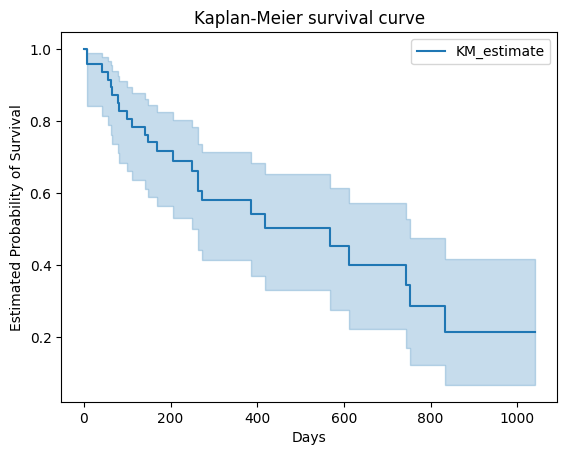

In [52]:
from lifelines import KaplanMeierFitter
kmf = KaplanMeierFitter()
kmf.fit(durations = f1['Progression_Free_Survival_Days'], event_observed = f1['progression'])
fig, ax =  plt.subplots()
kmf.plot_survival_function(color='C0',ax=ax)
ax.set(
    title='Kaplan-Meier survival curve',
    xlabel='Days',
    ylabel='Estimated Probability of Survival'
);

In [53]:
# Feature Selection by RFE
from numpy import mean
from numpy import std
from sklearn.datasets import make_regression
from sklearn.feature_selection import RFECV

# create pipeline
estimator=Lasso()
# evaluate model
selector = RFECV(estimator, step=1, cv=5)
selector = selector.fit(X_100, y)
selector.support_
selector.ranking_

array([ 1,  2, 12, 10,  6,  4,  5, 15, 13,  3,  8,  9, 14,  7, 11])

In [54]:
multivariable_coxph(X_100[f1_fea_new2.columns[selector.ranking_ < 5]])

<lifelines.CoxPHFitter: fitted with 47 total observations, 22 right-censored observations>
             duration col = 'progression_free_survival_days'
                event col = 'progression'
      baseline estimation = breslow
   number of observations = 47
number of events observed = 25
   partial log-likelihood = -72.67
         time fit was run = 2024-01-08 14:54:24 UTC

---
                                   coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                                
original_shape_Elongation          0.19       1.21       0.09             0.01             0.37                 1.01                 1.45
original_shape_Flatness           -0.15       0.86       0.10            -0.34             0.05                 0.71                 1.05
original_firstorder_90Percentile  -0.04       0.97       0.02            -0.07             0.00                 0.93                 1.00
original_glcm_Imc2                 0.18       1.20       0.07             0.04             0.33                 1.04                 1.39

                                   cmp to     z    p   -log2(p)
covariate                                                      
original_shape_Elongation            0.00  2.02 0.04       4.52
original_shape_Flatness              0.00 -1.44 0.15       2.75
original_firstorder_90Percentile     0.00 -1.91 0.06       4.17
original_glcm_Imc2                   0.00  2.48 0.01       6.26
---
Concordance = 0.68
Partial AIC = 153.34
log-likelihood ratio test = 12.22 on 4 df
-log2(p) of ll-ratio test = 5.99

In [55]:
selector.ranking_[selector.ranking_ < 5]

array([1, 2, 4, 3])

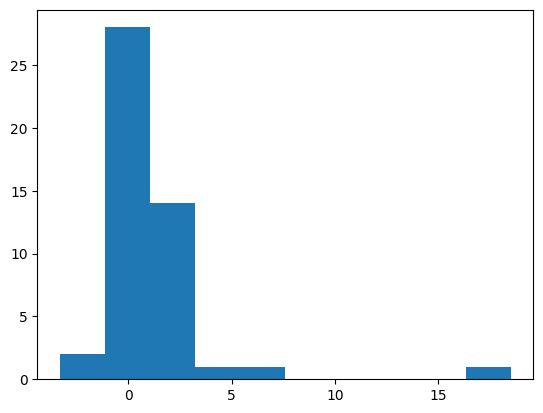

In [56]:
plt.hist(f5_f1_ratio.original_firstorder_Skewness)
plt.show()

In [57]:
# choose top 4 features
# if use return cph.summary
cph_result = multivariable_coxph(X_100[f1_fea_new2.columns[selector.ranking_ < 5]])
cph_result['ranking'] = selector.ranking_[selector.ranking_ < 5]
#cph_result.to_csv('binCount=64/multi_cph_100/cph_rfe_lasso2.csv')
cph_result[cph_result['p'] < 0.05]

<lifelines.CoxPHFitter: fitted with 47 total observations, 22 right-censored observations>
             duration col = 'progression_free_survival_days'
                event col = 'progression'
      baseline estimation = breslow
   number of observations = 47
number of events observed = 25
   partial log-likelihood = -72.67
         time fit was run = 2024-01-08 14:54:28 UTC

---
                                   coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                                
original_shape_Elongation          0.19       1.21       0.09             0.01             0.37                 1.01                 1.45
original_shape_Flatness           -0.15       0.86       0.10            -0.34             0.05                 0.71                 1.05
original_firstorder_90Percentile  -0.04       0.97       0.02            -0.07             0.00                 0.93                 1.00
original_glcm_Imc2                 0.18       1.20       0.07             0.04             0.33                 1.04                 1.39

                                   cmp to     z    p   -log2(p)
covariate                                                      
original_shape_Elongation            0.00  2.02 0.04       4.52
original_shape_Flatness              0.00 -1.44 0.15       2.75
original_firstorder_90Percentile     0.00 -1.91 0.06       4.17
original_glcm_Imc2                   0.00  2.48 0.01       6.26
---
Concordance = 0.68
Partial AIC = 153.34
log-likelihood ratio test = 12.22 on 4 df
-log2(p) of ll-ratio test = 5.99

TypeError: 'NoneType' object does not support item assignment

In [58]:
print(X_100[f1_fea_new2.columns[selector.ranking_ < 5]].columns)
selector.ranking_[selector.ranking_ < 5]
cph_result[cph_result['p'] < 0.05].p.values

Index(['original_shape_Elongation', 'original_shape_Flatness',
       'original_firstorder_90Percentile', 'original_glcm_Imc2'],
      dtype='object')


TypeError: 'NoneType' object is not subscriptable

##### OS

In [59]:
def multivariable_coxph_os(feature):
    '''coxph
    With delta radiomics (F5/F1): use f5_f1_ratio for feature value, f1 for survival time & event
    With F1: use f1 for feature value & survival time & event

    Args:
    feature: dataframe with selected features for multivariable coxph
    '''
    cph = CoxPHFitter()
    survival_df = pd.DataFrame(feature).assign(Overall_survival_days = f1['Overall_survival_days'], Overall_survival_event = f1['Overall_survival_event'])
    # replace inf values with null values and drop all null values
    survival_df = survival_df.replace([np.inf, -np.inf], np.nan).dropna()
    cph.fit(survival_df, 'Overall_survival_days', event_col = 'Overall_survival_event')
    return cph.print_summary()

In [60]:
#X = f5_f1_ratio[f1_fea_new2.columns]
X = f1_fea_new2
X_100 = np.multiply(X,100)
X_scaled = X.copy()
for column in X_scaled.columns:
    X_scaled[column] = (X_scaled[column] -
                           X_scaled[column].mean()) / X_scaled[column].std()
y = f1['Overall_survival_days']

In [61]:
# Feature selection by Lasso
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
pipeline = Pipeline([('scaler',StandardScaler()),
                     ('model',Lasso())])
search = GridSearchCV(pipeline,
                      {'model__alpha':np.arange(0.1,10,0.1)},
                      cv = 5)
search.fit(X_100,y)
search.best_params_

{'model__alpha': 9.9}

In [62]:
coefficients = search.best_estimator_.named_steps['model'].coef_
importance = np.abs(coefficients)
print('importance of features: importance', importance)
# selected features
print('Selected features:', np.array(f1_fea_new2.columns)[importance > 0])
# discarded features
print('Discarded features:', np.array(f1_fea_new2.columns)[importance == 0])

importance of features: importance [ 0.          1.00297836  0.          0.         18.68602513  8.16832664
  0.          0.          0.         22.82215739 61.92562036  0.
 10.07713237  0.          5.48691421]
Selected features: ['original_shape_Flatness' 'original_shape_SurfaceVolumeRatio'
 'original_firstorder_90Percentile' 'original_glcm_Imc2'
 'original_gldm_DependenceEntropy'
 'original_gldm_LargeDependenceHighGrayLevelEmphasis'
 'original_ngtdm_Coarseness']
Discarded features: ['original_shape_Elongation' 'original_shape_Maximum2DDiameterSlice'
 'original_shape_Sphericity' 'original_firstorder_Median'
 'original_firstorder_Skewness' 'original_glcm_DifferenceAverage'
 'original_gldm_GrayLevelNonUniformity'
 'original_glrlm_RunLengthNonUniformityNormalized']


In [63]:
# if use return cph.summary
cph_result = multivariable_coxph_os(X_100[np.array(f1_fea_new2.columns)[importance > 0]])
cph_result['importance'] = importance[importance != 0]
#cph_result.to_csv('binCount=64/multi_cph_100/cph_lasso_os2.csv')
cph_result[cph_result['p'] < 0.05]

<lifelines.CoxPHFitter: fitted with 47 total observations, 30 right-censored observations>
             duration col = 'Overall_survival_days'
                event col = 'Overall_survival_event'
      baseline estimation = breslow
   number of observations = 47
number of events observed = 17
   partial log-likelihood = -46.67
         time fit was run = 2024-01-08 14:54:37 UTC

---
                                                     coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                                                  
original_shape_Flatness                              0.01       1.01       0.03            -0.05             0.07                 0.96                 1.07
original_shape_SurfaceVolumeRatio                   -0.09       0.91       0.09            -0.27             0.09                 0.76                 1.09
original_firstorder_90Percentile                    -0.00       1.00       0.01            -0.03             0.02                 0.97                 1.02
original_glcm_Imc2                                  -0.16       0.85       0.09            -0.34             0.02                 0.71                 1.02
original_gldm_DependenceEntropy                      0.00       1.00       0.02            -0.04             0.05                 0.96                 1.05
original_gldm_LargeDependenceHighGrayLevelEmphasis  -0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
original_ngtdm_Coarseness                            1.77       5.88       1.55            -1.26             4.80                 0.28               121.63

                                                     cmp to     z    p   -log2(p)
covariate                                                                        
original_shape_Flatness                                0.00  0.36 0.72       0.48
original_shape_SurfaceVolumeRatio                      0.00 -0.98 0.33       1.61
original_firstorder_90Percentile                       0.00 -0.05 0.96       0.06
original_glcm_Imc2                                     0.00 -1.77 0.08       3.71
original_gldm_DependenceEntropy                        0.00  0.20 0.84       0.25
original_gldm_LargeDependenceHighGrayLevelEmphasis     0.00 -1.40 0.16       2.63
original_ngtdm_Coarseness                              0.00  1.15 0.25       1.99
---
Concordance = 0.72
Partial AIC = 107.34
log-likelihood ratio test = 13.69 on 7 df
-log2(p) of ll-ratio test = 4.13

TypeError: 'NoneType' object does not support item assignment

In [64]:
multivariable_coxph_os(X_100[np.array(f1_fea_new2.columns)[importance > 0]])

<lifelines.CoxPHFitter: fitted with 47 total observations, 30 right-censored observations>
             duration col = 'Overall_survival_days'
                event col = 'Overall_survival_event'
      baseline estimation = breslow
   number of observations = 47
number of events observed = 17
   partial log-likelihood = -46.67
         time fit was run = 2024-01-08 14:54:40 UTC

---
                                                     coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                                                  
original_shape_Flatness                              0.01       1.01       0.03            -0.05             0.07                 0.96                 1.07
original_shape_SurfaceVolumeRatio                   -0.09       0.91       0.09            -0.27             0.09                 0.76                 1.09
original_firstorder_90Percentile                    -0.00       1.00       0.01            -0.03             0.02                 0.97                 1.02
original_glcm_Imc2                                  -0.16       0.85       0.09            -0.34             0.02                 0.71                 1.02
original_gldm_DependenceEntropy                      0.00       1.00       0.02            -0.04             0.05                 0.96                 1.05
original_gldm_LargeDependenceHighGrayLevelEmphasis  -0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
original_ngtdm_Coarseness                            1.77       5.88       1.55            -1.26             4.80                 0.28               121.63

                                                     cmp to     z    p   -log2(p)
covariate                                                                        
original_shape_Flatness                                0.00  0.36 0.72       0.48
original_shape_SurfaceVolumeRatio                      0.00 -0.98 0.33       1.61
original_firstorder_90Percentile                       0.00 -0.05 0.96       0.06
original_glcm_Imc2                                     0.00 -1.77 0.08       3.71
original_gldm_DependenceEntropy                        0.00  0.20 0.84       0.25
original_gldm_LargeDependenceHighGrayLevelEmphasis     0.00 -1.40 0.16       2.63
original_ngtdm_Coarseness                              0.00  1.15 0.25       1.99
---
Concordance = 0.72
Partial AIC = 107.34
log-likelihood ratio test = 13.69 on 7 df
-log2(p) of ll-ratio test = 4.13

In [65]:
# Feature Selection by RFE
# create pipeline
estimator=Lasso()
# evaluate model
selector = RFECV(estimator, step=1, cv=5)
selector = selector.fit(X_100, y)
selector.support_
selector.ranking_

array([ 6,  5, 13,  3,  2,  9,  7, 11, 12,  1,  4, 14, 15,  8, 10])

In [66]:
# choose top 4 features
# if use return cph.summary
cph_result = multivariable_coxph_os(X_100[f1_fea_new2.columns[selector.ranking_ < 5]])
cph_result['ranking'] = selector.ranking_[selector.ranking_ < 5]
#cph_result.to_csv('binCount=64/multi_cph_100/cph_rfe_lasso_os2.csv')
cph_result[cph_result['p'] < 0.05]

<lifelines.CoxPHFitter: fitted with 47 total observations, 30 right-censored observations>
             duration col = 'Overall_survival_days'
                event col = 'Overall_survival_event'
      baseline estimation = breslow
   number of observations = 47
number of events observed = 17
   partial log-likelihood = -47.77
         time fit was run = 2024-01-08 14:54:43 UTC

---
                                    coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                                 
original_shape_Sphericity           0.04       1.05       0.07            -0.08             0.17                 0.92                 1.19
original_shape_SurfaceVolumeRatio   0.01       1.01       0.08            -0.16             0.17                 0.85                 1.18
original_glcm_Imc2                 -0.14       0.87       0.10            -0.33             0.06                 0.72                 1.06
original_gldm_DependenceEntropy    -0.00       1.00       0.02            -0.04             0.03                 0.96                 1.03

                                    cmp to     z    p   -log2(p)
covariate                                                       
original_shape_Sphericity             0.00  0.68 0.50       1.01
original_shape_SurfaceVolumeRatio     0.00  0.07 0.95       0.08
original_glcm_Imc2                    0.00 -1.37 0.17       2.55
original_gldm_DependenceEntropy       0.00 -0.12 0.91       0.14
---
Concordance = 0.68
Partial AIC = 103.54
log-likelihood ratio test = 11.48 on 4 df
-log2(p) of ll-ratio test = 5.53

TypeError: 'NoneType' object does not support item assignment

In [67]:
multivariable_coxph_os(X_100[f1_fea_new2.columns[selector.ranking_ < 5]])

<lifelines.CoxPHFitter: fitted with 47 total observations, 30 right-censored observations>
             duration col = 'Overall_survival_days'
                event col = 'Overall_survival_event'
      baseline estimation = breslow
   number of observations = 47
number of events observed = 17
   partial log-likelihood = -47.77
         time fit was run = 2024-01-08 14:54:45 UTC

---
                                    coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                                 
original_shape_Sphericity           0.04       1.05       0.07            -0.08             0.17                 0.92                 1.19
original_shape_SurfaceVolumeRatio   0.01       1.01       0.08            -0.16             0.17                 0.85                 1.18
original_glcm_Imc2                 -0.14       0.87       0.10            -0.33             0.06                 0.72                 1.06
original_gldm_DependenceEntropy    -0.00       1.00       0.02            -0.04             0.03                 0.96                 1.03

                                    cmp to     z    p   -log2(p)
covariate                                                       
original_shape_Sphericity             0.00  0.68 0.50       1.01
original_shape_SurfaceVolumeRatio     0.00  0.07 0.95       0.08
original_glcm_Imc2                    0.00 -1.37 0.17       2.55
original_gldm_DependenceEntropy       0.00 -0.12 0.91       0.14
---
Concordance = 0.68
Partial AIC = 103.54
log-likelihood ratio test = 11.48 on 4 df
-log2(p) of ll-ratio test = 5.53

In [68]:
X_100[f1_fea_new2.columns[selector.ranking_ < 5]].columns
selector.ranking_[selector.ranking_ < 5]

array([3, 2, 1, 4])

##### LFS

In [69]:
def multivariable_coxph_lfs(feature):
    '''coxph
    With delta radiomics (F5/F1): use f5_f1_ratio for feature value, f1 for survival time & event
    With F1: use f1 for feature value & survival time & event

    Args:
    feature: dataframe with selected features for multivariable coxph
    '''
    cph = CoxPHFitter()
    survival_df = pd.DataFrame(feature).assign(Local_failure_days = f1['Local_failure_days'], Local_failure = f1['Local_failure'])
    # replace inf values with null values and drop all null values
    survival_df = survival_df.replace([np.inf, -np.inf], np.nan).dropna()
    cph.fit(survival_df, 'Local_failure_days', event_col = 'Local_failure')
    #return cph.print_summary()
    return cph.summary

In [70]:
#X = f5_f1_ratio[f1_fea_new2.columns]
X = f1_fea_new2
X_100 = np.multiply(X,100)
X_scaled = X.copy()
for column in X_scaled.columns:
    X_scaled[column] = (X_scaled[column] -
                           X_scaled[column].mean()) / X_scaled[column].std()
y = f1['Local_failure_days']

In [71]:
# Feature selection by Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import Lasso
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
pipeline = Pipeline([('scaler',StandardScaler()),
                     ('model',Lasso())])
search = GridSearchCV(pipeline,
                      {'model__alpha':np.arange(0.1,10,0.1)},
                      cv = 5)
search.fit(X_100,y)
search.best_params_

{'model__alpha': 9.9}

In [72]:
coefficients = search.best_estimator_.named_steps['model'].coef_
importance = np.abs(coefficients)
print('importance of features: importance', importance)
# selected features
print('Selected features:', np.array(f1_fea_new2.columns)[importance > 0])
# discarded features
print('Discarded features:', np.array(f1_fea_new2.columns)[importance == 0])

importance of features: importance [16.26809693  0.          0.         16.12658698  0.          7.57881866
  0.          8.81450826  0.          8.85607974 29.23030357  3.31901239
  0.          0.         20.1101809 ]
Selected features: ['original_shape_Elongation' 'original_shape_Sphericity'
 'original_firstorder_90Percentile' 'original_firstorder_Skewness'
 'original_glcm_Imc2' 'original_gldm_DependenceEntropy'
 'original_gldm_GrayLevelNonUniformity' 'original_ngtdm_Coarseness']
Discarded features: ['original_shape_Flatness' 'original_shape_Maximum2DDiameterSlice'
 'original_shape_SurfaceVolumeRatio' 'original_firstorder_Median'
 'original_glcm_DifferenceAverage'
 'original_gldm_LargeDependenceHighGrayLevelEmphasis'
 'original_glrlm_RunLengthNonUniformityNormalized']


In [73]:
importance[importance != 0]
np.array(f1_fea_new2.columns)[importance > 0]

print(X_100[np.array(f1_fea_new2.columns)[importance > 0]].columns)
print(importance[importance > 0])
cph_result[cph_result['p'] < 0.05].p.values

Index(['original_shape_Elongation', 'original_shape_Sphericity',
       'original_firstorder_90Percentile', 'original_firstorder_Skewness',
       'original_glcm_Imc2', 'original_gldm_DependenceEntropy',
       'original_gldm_GrayLevelNonUniformity', 'original_ngtdm_Coarseness'],
      dtype='object')
[16.26809693 16.12658698  7.57881866  8.81450826  8.85607974 29.23030357
  3.31901239 20.1101809 ]


TypeError: 'NoneType' object is not subscriptable

In [74]:
cph_result = multivariable_coxph_lfs(X_100[np.array(f1_fea_new2.columns)[importance > 0]])
cph_result['importance'] = importance[importance != 0]
#cph_result.to_csv('binCount=64/multi_cph_100/cph_lasso_lfs2.csv')
cph_result[cph_result['p'] < 0.05]

coef  exp(coef)  se(coef)  coef lower 95%  \
covariate                                                                  
original_shape_Sphericity -0.252344   0.776977  0.119676       -0.486904   

                           coef upper 95%  exp(coef) lower 95%  \
covariate                                                        
original_shape_Sphericity       -0.017784             0.614526   

                           exp(coef) upper 95%  cmp to         z         p  \
covariate                                                                    
original_shape_Sphericity             0.982373     0.0 -2.108569  0.034982   

                           -log2(p)  importance  
covariate                                        
original_shape_Sphericity  4.837251   16.126587

In [75]:
multivariable_coxph_lfs(X_100[np.array(f1_fea_new2.columns)[importance > 0]])

coef  exp(coef)  se(coef)  \
covariate                                                             
original_shape_Elongation            -0.029062   0.971356  0.040559   
original_shape_Sphericity            -0.252344   0.776977  0.119676   
original_firstorder_90Percentile      0.034289   1.034883  0.037824   
original_firstorder_Skewness         -0.012066   0.988006  0.009923   
original_glcm_Imc2                    0.319442   1.376359  0.294094   
original_gldm_DependenceEntropy      -0.061042   0.940784  0.053201   
original_gldm_GrayLevelNonUniformity -0.000060   0.999940  0.000233   
original_ngtdm_Coarseness            -4.030250   0.017770  3.565464   

                                      coef lower 95%  coef upper 95%  \
covariate                                                              
original_shape_Elongation                  -0.108557        0.050433   
original_shape_Sphericity                  -0.486904       -0.017784   
original_firstorder_90Percentile           -0.039844        0.108422   
original_firstorder_Skewness               -0.031516        0.007383   
original_glcm_Imc2                         -0.256971        0.895855   
original_gldm_DependenceEntropy            -0.165313        0.043230   
original_gldm_GrayLevelNonUniformity       -0.000516        0.000396   
original_ngtdm_Coarseness                 -11.018431        2.957932   

                                      exp(coef) lower 95%  \
covariate                                                   
original_shape_Elongation                        0.897128   
original_shape_Sphericity                        0.614526   
original_firstorder_90Percentile                 0.960939   
original_firstorder_Skewness                     0.968976   
original_glcm_Imc2                               0.773390   
original_gldm_DependenceEntropy                  0.847629   
original_gldm_GrayLevelNonUniformity             0.999484   
original_ngtdm_Coarseness                        0.000016   

                                      exp(coef) upper 95%  cmp to         z  \
covariate                                                                     
original_shape_Elongation                        1.051726     0.0 -0.716532   
original_shape_Sphericity                        0.982373     0.0 -2.108569   
original_firstorder_90Percentile                 1.114517     0.0  0.906537   
original_firstorder_Skewness                     1.007411     0.0 -1.215929   
original_glcm_Imc2                               2.449428     0.0  1.086190   
original_gldm_DependenceEntropy                  1.044178     0.0 -1.147385   
original_gldm_GrayLevelNonUniformity             1.000396     0.0 -0.257895   
original_ngtdm_Coarseness                       19.258096     0.0 -1.130358   

                                             p  -log2(p)  
covariate                                                 
original_shape_Elongation             0.473663  1.078068  
original_shape_Sphericity             0.034982  4.837251  
original_firstorder_90Percentile      0.364652  1.455409  
original_firstorder_Skewness          0.224012  2.158353  
original_glcm_Imc2                    0.277395  1.849987  
original_gldm_DependenceEntropy       0.251222  1.992963  
original_gldm_GrayLevelNonUniformity  0.796488  0.328276  
original_ngtdm_Coarseness             0.258326  1.952738

In [76]:
# Feature Selection by RFE
from numpy import mean
from numpy import std
from sklearn.datasets import make_regression
from sklearn.feature_selection import RFECV

# create pipeline
estimator=Lasso()
# evaluate model
selector = RFECV(estimator, step=1, cv=5)
selector = selector.fit(X_100, y)
selector.support_
selector.ranking_

array([ 6, 12, 13,  1,  4,  7,  8,  9, 11,  5,  3, 14, 15, 10,  2])

In [77]:
multivariable_coxph_lfs(X_100[f1_fea_new2.columns[selector.ranking_ < 5]])

coef  exp(coef)  se(coef)  \
covariate                                                          
original_shape_Sphericity         -0.083773   0.919640  0.079439   
original_shape_SurfaceVolumeRatio  0.136312   1.146039  0.110549   
original_gldm_DependenceEntropy   -0.004454   0.995556  0.019898   
original_ngtdm_Coarseness         -1.079325   0.339825  1.809778   

                                   coef lower 95%  coef upper 95%  \
covariate                                                           
original_shape_Sphericity               -0.239470        0.071925   
original_shape_SurfaceVolumeRatio       -0.080361        0.352984   
original_gldm_DependenceEntropy         -0.043453        0.034545   
original_ngtdm_Coarseness               -4.626425        2.467775   

                                   exp(coef) lower 95%  exp(coef) upper 95%  \
covariate                                                                     
original_shape_Sphericity                     0.787045             1.074574   
original_shape_SurfaceVolumeRatio             0.922783             1.423309   
original_gldm_DependenceEntropy               0.957478             1.035148   
original_ngtdm_Coarseness                     0.009790            11.796165   

                                   cmp to         z         p  -log2(p)  
covariate                                                                
original_shape_Sphericity             0.0 -1.054556  0.291629  1.777796  
original_shape_SurfaceVolumeRatio     0.0  1.233039  0.217561  2.200506  
original_gldm_DependenceEntropy       0.0 -0.223846  0.822877  0.281250  
original_ngtdm_Coarseness             0.0 -0.596385  0.550918  0.860091

In [78]:
# choose top 4 features
cph_result = multivariable_coxph_lfs(X_100[f1_fea_new2.columns[selector.ranking_ < 5]])
cph_result['ranking'] = selector.ranking_[selector.ranking_ < 5]
#cph_result.to_csv('binCount=64/multi_cph_100/cph_rfe_lasso_lfs2.csv')
cph_result[cph_result['p'] < 0.05]

Empty DataFrame
Columns: [coef, exp(coef), se(coef), coef lower 95%, coef upper 95%, exp(coef) lower 95%, exp(coef) upper 95%, cmp to, z, p, -log2(p), ranking]
Index: []

In [79]:
print(X_100[f1_fea_new2.columns[selector.ranking_ < 5]].columns)
print(selector.ranking_[selector.ranking_ < 5])
cph_result[cph_result['p'] < 0.05].p.values

Index(['original_shape_Sphericity', 'original_shape_SurfaceVolumeRatio',
       'original_gldm_DependenceEntropy', 'original_ngtdm_Coarseness'],
      dtype='object')
[1 4 3 2]


array([], dtype=float64)

##### In-field locoregional Failure Free Survival
* Treat in-field locoregional recurrence as an end point
* In-field locoregional recurrence event: 'In_field_locoregional_recurrence' = 1 if f1['In-field locoregional recurrence?'] is Yes
* In-field locoregional recurrence free time: 'In_field_locoregional_recurrence_time' = f1['Date of first Infield locoregional recurrence. If no documented infield LRR, last known date without infield LRR (by chest CT or PET-CT)'] - f1['Radiation start date']. If no documented in-field locoregional recurrence, last known date without in-field locoregional recurrence
* column YZ: In-field locoregional recurrence. 4 cases vs. 43 cases (first filter on column YY: Any locoregional recurrence (either in or out of field)?)

In [58]:
# in-field locoregional recurrence event
f1['In_field_locoregional_recurrence'] = np.where(f1['In-field locoregional recurrence?'] == 'Yes', 1, 0)
# in-field locoregional recurrence (free) time
f1['Date of first Infield locoregional recurrence. If no documented infield LRR, last known date without infield LRR (by chest CT or PET-CT)'] = pd.to_datetime(f1['Date of first Infield locoregional recurrence. If no documented infield LRR, last known date without infield LRR (by chest CT or PET-CT)'], format = '%Y-%m-%d')
f1['Date of first locoregional recurrence. If no documented LRR, last known date without LRR (by chest CT or PET-CT)'] = pd.to_datetime(f1['Date of first locoregional recurrence. If no documented LRR, last known date without LRR (by chest CT or PET-CT)'], format = '%Y-%m-%d')
f1['In_field_locoregional_recurrence_time'] = 0
for i in range(len(f1)):
    if pd.isnull(f1['Date of first Infield locoregional recurrence. If no documented infield LRR, last known date without infield LRR (by chest CT or PET-CT)'][i]) is False:
        f1['In_field_locoregional_recurrence_time'][i] = (f1['Date of first Infield locoregional recurrence. If no documented infield LRR, last known date without infield LRR (by chest CT or PET-CT)'][i] - f1['Radiation start date'][i]).days
    else:
        f1['In_field_locoregional_recurrence_time'][i] = (f1['Date of first locoregional recurrence. If no documented LRR, last known date without LRR (by chest CT or PET-CT)'][i] - f1['Radiation start date'][i]).days
#f1['In_field_locoregional_recurrence_time'] = (f1['Date of first Infield locoregional recurrence. If no documented infield LRR, last known date without infield LRR (by chest CT or PET-CT)'] - f1['Radiation start date']).dt.days.astype('int16')
f1['In_field_locoregional_recurrence_time'].mask((f1['pat_id'] == '10144023610') & (f1['Radiation_start_date'] == '2021-03-19') , d, inplace=True)

<ipython-input-58-8b6a98ab8c30>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f1['In_field_locoregional_recurrence_time'][i] = (f1['Date of first Infield locoregional recurrence. If no documented infield LRR, last known date without infield LRR (by chest CT or PET-CT)'][i] - f1['Radiation start date'][i]).days
<ipython-input-58-8b6a98ab8c30>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f1['In_field_locoregional_recurrence_time'][i] = (f1['Date of first locoregional recurrence. If no documented LRR, last known date without LRR (by chest CT or PET-CT)'][i] - f1['Radiation start date'][i]).days


In [59]:
print(f1['Date of first Infield locoregional recurrence. If no documented infield LRR, last known date without infield LRR (by chest CT or PET-CT)'][41])
print(f1['Radiation start date'][41])
print(f1['Date of first locoregional recurrence. If no documented LRR, last known date without LRR (by chest CT or PET-CT)'][41])
# NaT
#2021-03-19 00:00:00
#2021-02-09 00:00:00

f1['In_field_locoregional_recurrence_time'][41] # 56
df_new2 = f5_f1_ratio[f1_fea_new2.columns]
df_new2['In_field_locoregional_recurrence'] = f1['In_field_locoregional_recurrence']
df_new2['In_field_locoregional_recurrence_time'] = f1['In_field_locoregional_recurrence_time']
#df_new2.to_csv('/Users/yuhelin/Desktop/University/2022 Post-Fall/Kann Lab/Lung Cancer/binCount=64/df_new2.csv')

df_new = f5_f1_ratio[f1_fea_new2.columns]
df_new['Local_failure'] = f1['Local_failure']
df_new['Local_failure_days'] = f1['Local_failure_days']
#df_new.to_csv('/Users/yuhelin/Desktop/University/2022 Post-Fall/Kann Lab/Lung Cancer/binCount=64/df_new.csv')

NaT
2021-03-19 00:00:00
2021-02-09 00:00:00


<ipython-input-59-b94904d7e1a8>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new2['In_field_locoregional_recurrence'] = f1['In_field_locoregional_recurrence']
<ipython-input-59-b94904d7e1a8>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new2['In_field_locoregional_recurrence_time'] = f1['In_field_locoregional_recurrence_time']
<ipython-input-59-b94904d7e1a8>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] 

In [60]:
def univariate_coxph_iflfs(feature):
    '''coxph
    With delta radiomics (F5/F1): use f5_f1_ratio for feature value, f1 for survival time & event
    With F1: use f1 for feature value & survival time & event
    '''
    cph = CoxPHFitter()
    #survival_df = pd.DataFrame().assign(feature = np.multiply(f1[feature], 100), In_field_locoregional_recurrence_time = f1['In_field_locoregional_recurrence_time'], In_field_locoregional_recurrence = f1['In_field_locoregional_recurrence'])
    survival_df = pd.DataFrame().assign(feature = np.multiply(f5_f1_ratio[feature], 100), In_field_locoregional_recurrence_time = f1['In_field_locoregional_recurrence_time'], In_field_locoregional_recurrence = f1['In_field_locoregional_recurrence'])
    # replace inf values with null values and drop all null values
    survival_df = survival_df.replace([np.inf, -np.inf], np.nan).dropna()
    cph.fit(survival_df, 'In_field_locoregional_recurrence_time', event_col = 'In_field_locoregional_recurrence')
    #return cph.summary['p'].item()
    return cph.summary

In [61]:
# record result of univariate cph models
# now doing univariate analysis for 47 stable features
cph_result = pd.DataFrame()
#for feature in common_list: # for all stable features
for feature in f1_fea_new2.columns: # for stable & non-collinear features
    cph_result = cph_result.append(univariate_coxph_iflfs(feature), ignore_index = True)
#cph_result.insert(loc = 0,
#          column = 'covariate',
#          value = common_list)
cph_result.insert(loc = 0,
          column = 'covariate',
          value = f1_fea_new2.columns)

# Bonferroni correction
import statsmodels.stats.multitest
decision, adj_pvals, sidak_aplha, bonf_alpha = statsmodels.stats.multitest.multipletests(pvals=cph_result['p'], alpha=0.05, method='bonferroni')
cph_result.insert(loc = 11,
          column = 'adj_p_Bonferroni',
          value = adj_pvals)

# Benjamini/Hochberg correction
decision, adj_pvals, sidak_aplha, bonf_alpha = statsmodels.stats.multitest.multipletests(pvals=cph_result['p'], alpha=0.05, method='fdr_bh')
cph_result.insert(loc = 11,
          column = 'adj_p_bh',
          value = adj_pvals)

# HolmBonferroni correction
decision, adj_pvals, sidak_aplha, bonf_alpha = statsmodels.stats.multitest.multipletests(pvals=cph_result['p'], alpha=0.05, method='holm')
cph_result.insert(loc = 12,
          column = 'adj_p_HolmBonferroni',
          value = adj_pvals)

# idk correction
decision, adj_pvals, sidak_aplha, bonf_alpha = statsmodels.stats.multitest.multipletests(pvals=cph_result['p'], alpha=0.05, method='sidak')
cph_result.insert(loc = 13,
          column = 'adj_p_idk',
          value = adj_pvals)
#cph_result.to_csv('binCount=64/uni_cph_100/cph_result_stable_feas_iflfs_nc.csv')
cph_result[cph_result['p'] < 0.05]

Empty DataFrame
Columns: [covariate, coef, exp(coef), se(coef), coef lower 95%, coef upper 95%, exp(coef) lower 95%, exp(coef) upper 95%, cmp to, z, p, adj_p_bh, adj_p_HolmBonferroni, adj_p_idk, adj_p_Bonferroni, -log2(p)]
Index: []

In [62]:
# Analysis of VoxelVolume
cph_result = univariate_coxph_iflfs("original_shape_VoxelVolume")
# Benjamini/Hochberg correction
decision, adj_pvals, sidak_aplha, bonf_alpha = statsmodels.stats.multitest.multipletests(pvals=cph_result['p'], alpha=0.05, method='fdr_bh')
cph_result.insert(loc = 11,
          column = 'adj_p_bh',
          value = adj_pvals)
cph_result

coef  exp(coef)  se(coef)  coef lower 95%  coef upper 95%  \
covariate                                                                  
feature    0.037147   1.037846   0.07234       -0.104636        0.178931   

           exp(coef) lower 95%  exp(coef) upper 95%  cmp to         z  \
covariate                                                               
feature               0.900652             1.195938     0.0  0.513511   

                  p  -log2(p)  adj_p_bh  
covariate                                
feature    0.607594  0.718821  0.607594

In [84]:
def multivariable_coxph_iflfs(feature):
    '''coxph
    With delta radiomics (F5/F1): use f5_f1_ratio for feature value, f1 for survival time & event
    With F1: use f1 for feature value & survival time & event

    Args:
    feature: dataframe with selected features for multivariable coxph
    '''
    cph = CoxPHFitter()
    survival_df = pd.DataFrame(feature).assign(In_field_locoregional_recurrence_time = f1['In_field_locoregional_recurrence_time'], In_field_locoregional_recurrence = f1['In_field_locoregional_recurrence'])
    # replace inf values with null values and drop all null values
    survival_df = survival_df.replace([np.inf, -np.inf], np.nan).dropna()
    cph.fit(survival_df, 'In_field_locoregional_recurrence_time', event_col = 'In_field_locoregional_recurrence')
    return cph.print_summary()
    #return cph.summary

In [85]:
X = f5_f1_ratio[f1_fea_new2.columns]
#X = f1_fea_new2
X_100 = np.multiply(X,100)
X_scaled = X.copy()
for column in X_scaled.columns:
    X_scaled[column] = (X_scaled[column] -
                           X_scaled[column].mean()) / X_scaled[column].std()
y = f1['In_field_locoregional_recurrence_time']

In [86]:
# Feature Selection by RFE
from numpy import mean
from numpy import std
from sklearn.datasets import make_regression
from sklearn.feature_selection import RFECV
from sklearn.linear_model import Lasso


# create pipeline
estimator=Lasso()
# evaluate model
selector = RFECV(estimator, step=1, cv=5)
selector = selector.fit(X_100, y)
selector.support_
selector.ranking_

array([ 2,  7,  5, 15, 12,  9,  3, 13,  8,  1,  4,  6, 14, 10, 11])

In [87]:
# if use return cph.summary
# choose top 4 features
cph_result = multivariable_coxph_iflfs(X_100[f1_fea_new2.columns[selector.ranking_ < 5]])
cph_result['ranking'] = selector.ranking_[selector.ranking_ < 5]
#cph_result.to_csv('binCount=64/multi_cph_100/cph_rfe_lasso_iflfs.csv')
cph_result[cph_result['p'] < 0.05]

<lifelines.CoxPHFitter: fitted with 47 total observations, 43 right-censored observations>
             duration col = 'In_field_locoregional_recurrence_time'
                event col = 'In_field_locoregional_recurrence'
      baseline estimation = breslow
   number of observations = 47
number of events observed = 4
   partial log-likelihood = -8.69
         time fit was run = 2024-01-08 14:55:15 UTC

---
                                  coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                               
original_shape_Elongation         0.22       1.25       0.12            -0.01             0.46                 0.99                 1.59
original_firstorder_Median        0.00       1.00       0.04            -0.08             0.08                 0.93                 1.09
original_glcm_Imc2                0.42       1.53       0.24            -0.05             0.90                 0.95                 2.46
original_gldm_DependenceEntropy  -0.44       0.65       0.50            -1.41             0.53                 0.24                 1.71

                                  cmp to     z    p   -log2(p)
covariate                                                     
original_shape_Elongation           0.00  1.84 0.07       3.94
original_firstorder_Median          0.00  0.11 0.91       0.13
original_glcm_Imc2                  0.00  1.75 0.08       3.65
original_gldm_DependenceEntropy     0.00 -0.88 0.38       1.40
---
Concordance = 0.85
Partial AIC = 25.39
log-likelihood ratio test = 7.14 on 4 df
-log2(p) of ll-ratio test = 2.96

TypeError: 'NoneType' object does not support item assignment

In [88]:
multivariable_coxph_iflfs(X_100[f1_fea_new2.columns[selector.ranking_ < 5]])

<lifelines.CoxPHFitter: fitted with 47 total observations, 43 right-censored observations>
             duration col = 'In_field_locoregional_recurrence_time'
                event col = 'In_field_locoregional_recurrence'
      baseline estimation = breslow
   number of observations = 47
number of events observed = 4
   partial log-likelihood = -8.69
         time fit was run = 2024-01-08 14:55:17 UTC

---
                                  coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                               
original_shape_Elongation         0.22       1.25       0.12            -0.01             0.46                 0.99                 1.59
original_firstorder_Median        0.00       1.00       0.04            -0.08             0.08                 0.93                 1.09
original_glcm_Imc2                0.42       1.53       0.24            -0.05             0.90                 0.95                 2.46
original_gldm_DependenceEntropy  -0.44       0.65       0.50            -1.41             0.53                 0.24                 1.71

                                  cmp to     z    p   -log2(p)
covariate                                                     
original_shape_Elongation           0.00  1.84 0.07       3.94
original_firstorder_Median          0.00  0.11 0.91       0.13
original_glcm_Imc2                  0.00  1.75 0.08       3.65
original_gldm_DependenceEntropy     0.00 -0.88 0.38       1.40
---
Concordance = 0.85
Partial AIC = 25.39
log-likelihood ratio test = 7.14 on 4 df
-log2(p) of ll-ratio test = 2.96

In [89]:
# if use return cph.summary
print(X_100[f1_fea_new2.columns[selector.ranking_ < 5]].columns)
print(selector.ranking_[selector.ranking_ < 5])
cph_result[cph_result['p'] < 0.05].p.values

Index(['original_shape_Elongation', 'original_firstorder_Median',
       'original_glcm_Imc2', 'original_gldm_DependenceEntropy'],
      dtype='object')
[2 3 1 4]


TypeError: 'NoneType' object is not subscriptable

##### Groupwise survival analysis
divide dataset into two groups: patients with OR without local/regional failure

### Median Follow-up Time
Logic: If patient was dead, then use death as the last date of follow-up. If the patient didn't die, then use the latest date of events: date of first progression, locoregional failure events, and in-field locoregional failure events.
radiation start date: cli_data['Radiation start date']
date of first progression: cli_data['Date of first progression. If no documented progression, last known date without progression ']
death/last known date alive: f1['Most_recent_date']

In [90]:
print((f1['Most_recent_date'] - f1['Radiation start date']).dt.days.median())
print((f1['Most_recent_date'] - f1['Radiation start date']).dt.days.max())
print((f1['Most_recent_date'] - f1['Radiation start date']).dt.days.min())

415.0
1178
32


#### Visualizations

Plot of 6 patients with local failure vs. 41 patients without local failure for median skewness over fractions.

[Text(0.5, 1.0, 'original_firstorder_Skewness by fraction')]

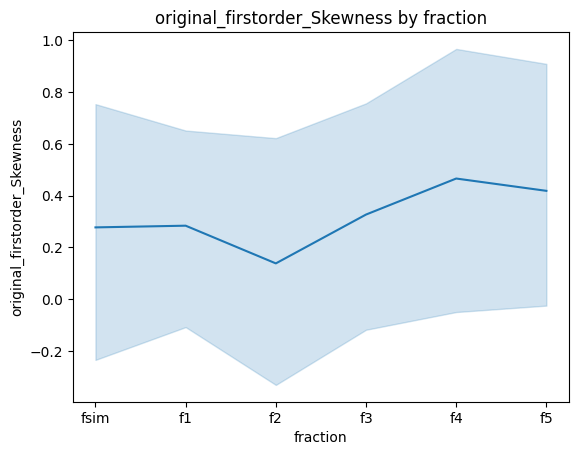

In [91]:
survival_df = pd.DataFrame(list(zip(fsim_fea['original_firstorder_Skewness'], f1_fea['original_firstorder_Skewness'], f2_fea['original_firstorder_Skewness'], f3_fea['original_firstorder_Skewness'], f4_fea['original_firstorder_Skewness'], f5_fea['original_firstorder_Skewness'])), columns=['fsim', 'f1', 'f2', 'f3', 'f4', 'f5'])
survival_df['Local_failure'] = f1['Local_failure']
g1 = survival_df[survival_df['Local_failure'] == 1] # local failure group
g2 = survival_df[survival_df['Local_failure'] == 0] # no local failure group
g1_df = pd.DataFrame(pd.concat([g1['fsim'], g1['f1'], g1['f2'], g1['f3'], g1['f4'], g1['f5']]), columns = ['original_firstorder_Skewness'])
g1_df['fraction'] = [i for i in ['fsim', 'f1', 'f2', 'f3', 'f4', 'f5'] for original_firstorder_Skewness in range(6)]
sns.lineplot(x = 'fraction', y = 'original_firstorder_Skewness', data = g1_df).set(title='original_firstorder_Skewness' + ' by fraction')

In [92]:
survival_df.to_csv("/Users/yuhelin/Desktop/University/2022 Post-Fall/Kann Lab/Lung Cancer/binCount=64/survival_df.csv")

[Text(0.5, 1.0, 'original_firstorder_Skewness by fraction')]

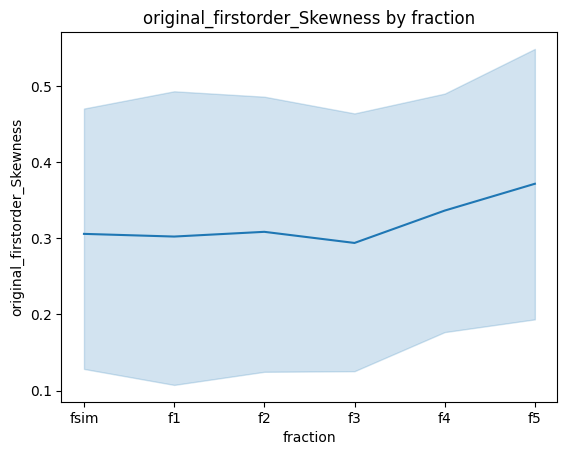

In [93]:
g2_df = pd.DataFrame(pd.concat([g2['fsim'], g2['f1'], g2['f2'], g2['f3'], g2['f4'], g2['f5']]), columns = ['original_firstorder_Skewness'])
g2_df['fraction'] = [i for i in ['fsim', 'f1', 'f2', 'f3', 'f4', 'f5'] for original_firstorder_Skewness in range(41)]
sns.lineplot(x = 'fraction', y = 'original_firstorder_Skewness', data = g2_df).set(title='original_firstorder_Skewness' + ' by fraction')

In [118]:
g1 = g1.drop(columns = 'Local_failure').T
g1['fraction'] = ['fsim', 'f1', 'f2', 'f3', 'f4', 'f5']
g1.index = [0, 1, 2, 3, 4, 5]
g2 = g2.drop(columns = 'Local_failure').T
g2['fraction'] = ['fsim', 'f1', 'f2', 'f3', 'f4', 'f5']
g2.index = [0, 1, 2, 3, 4, 5]
# drop sim fraction
g1 = g1[g1['fraction'] != 'fsim']
g2 = g2[g2['fraction'] != 'fsim']
# add median column
g1.insert(6, 'Median', g1.median(axis=1))
g2.insert(41, 'Median', g2.median(axis=1))

In [119]:
g1

0         6         7        23        24        38    Median  \
1 -0.414392  0.552999  1.074843  0.021770 -0.035748  0.503228  0.262499   
2 -0.764511  0.521135  1.094507  0.225910 -0.226232 -0.021705  0.102102   
3 -0.465942  0.886911  1.007866  0.285655 -0.261374  0.507366  0.396511   
4 -0.494005  1.352459  0.799071  0.365932 -0.236829  1.008498  0.582502   
5 -0.449952  1.249958  1.051252  0.402663 -0.069131  0.325252  0.363958   

  fraction  
1       f1  
2       f2  
3       f3  
4       f4  
5       f5

In [91]:
# F3 - F2 / F2
(0.507366-(-0.021705))/-0.021705
#f1.iloc[38,]['PMRN'] # '10140904193'	

-24.37553559087768

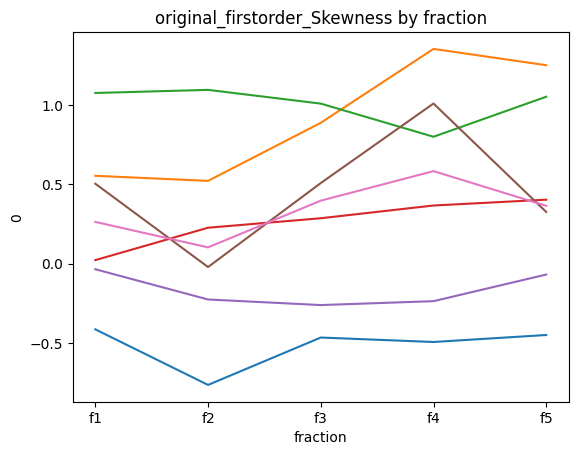

In [120]:
# plot for original values
#import matplotlib.pyplot as plt
for i in range(len(g1.columns)-1):
    sns.lineplot(x = 'fraction', y = g1.columns[i], data = g1).set(title='original_firstorder_Skewness' + ' by fraction')
#plt.ylim(-1,10)

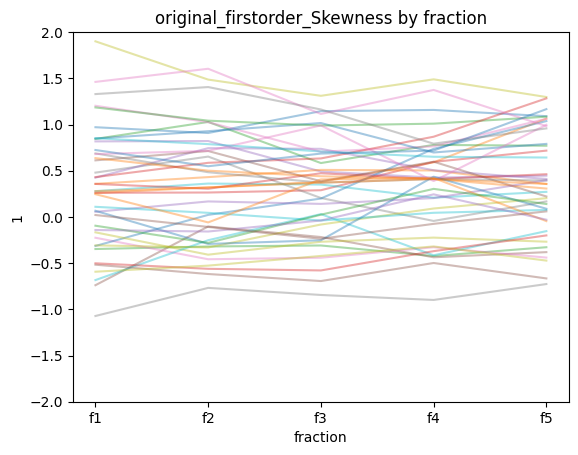

In [121]:
#set(ylim=(-0.05, 1.05))
for i in range(len(g2.columns)-1):
    sns.lineplot(x = 'fraction', y = g2.columns[i], data = g2, alpha = 0.4).set(ylim=(-2, 2), title='original_firstorder_Skewness' + ' by fraction')

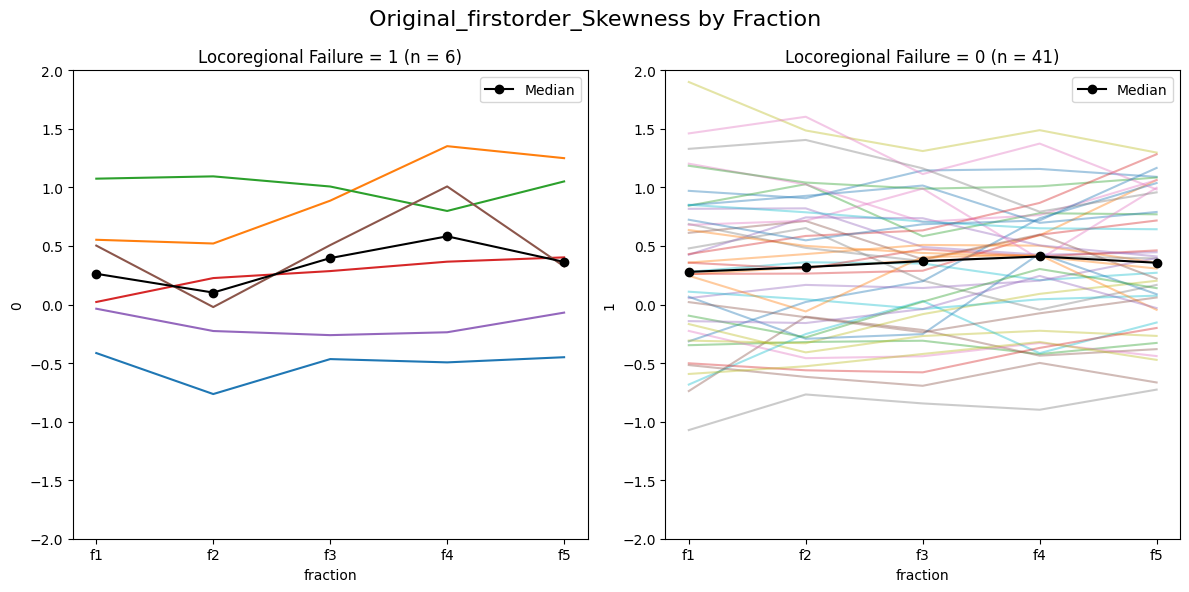

In [122]:
plt.style.use('default')  # Set the default style

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot for the group with Local_failure == 1
for i in range(len(g1.columns)-2):
    sns.lineplot(x='fraction', y=g1.columns[i], data=g1, ax=axes[0])

axes[0].set(ylim=(-2, 2), title='Locoregional Failure = 1 (n = 6)')
axes[0].plot(g1['fraction'], g1['Median'], marker='o', linestyle='-', label='Median', color = 'black')

# Plot for the group with Local_failure == 0
for i in range(len(g2.columns)-2):
    sns.lineplot(x='fraction', y=g2.columns[i], data=g2, alpha=0.4, ax=axes[1])

axes[1].set(ylim=(-2, 2), title='Locoregional Failure = 0 (n = 41)')
axes[1].plot(g2['fraction'], g2['Median'], marker='o', linestyle='-', label='Median', color = 'black')


axes[0].legend()
axes[1].legend()

plt.suptitle('Original_firstorder_Skewness by Fraction', fontsize=16)
plt.tight_layout()
plt.show()

In [123]:
# relative change plot
# relative_fn_fn-1
relative_data_df = pd.concat([relative_f2_f1_new['original_firstorder_Skewness'], relative_f3_f2_new['original_firstorder_Skewness'],
                               relative_f4_f3_new['original_firstorder_Skewness'], relative_f5_f4_new['original_firstorder_Skewness']], axis=1)
relative_data_df.columns = ['relative_f2_f1', 'relative_f3_f2', 'relative_f4_f3', 'relative_f5_f4']
relative_data_df['Locoregional_failure'] = survival_df['Local_failure']
g1_re = relative_data_df[relative_data_df['Locoregional_failure'] == 1] # local failure group
g2_re = relative_data_df[relative_data_df['Locoregional_failure'] == 0] # no local failure group
g1_re = g1_re.drop(columns = 'Locoregional_failure').T
g1_re['fraction'] = ['relative_f2_f1', 'relative_f3_f2', 'relative_f4_f3', 'relative_f5_f4']
g1_re.index = [0, 1, 2, 3]
g2_re = g2_re.drop(columns = 'Locoregional_failure').T
g2_re['fraction'] = ['relative_f2_f1', 'relative_f3_f2', 'relative_f4_f3', 'relative_f5_f4']
g2_re.index = [0, 1, 2, 3]
# add median column
g1_re.insert(6, 'Median', g1_re.median(axis=1))
g2_re.insert(41, 'Median', g2_re.median(axis=1))

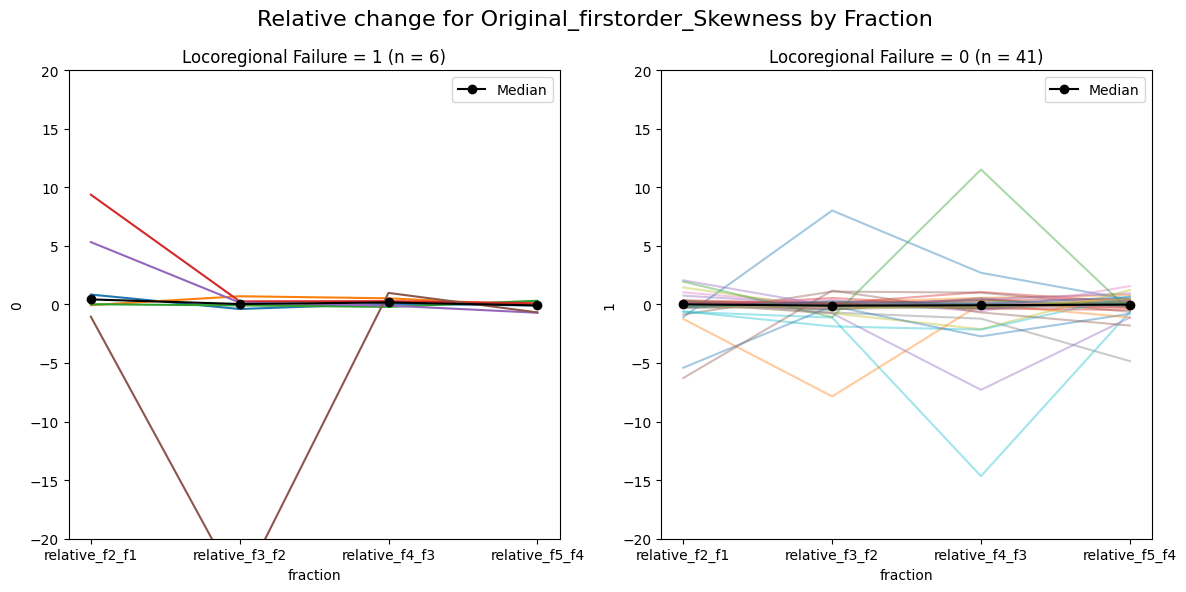

In [124]:
# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot for the group with Local_failure == 1
for i in range(len(g1_re.columns)-2):
    sns.lineplot(x='fraction', y=g1_re.columns[i], data=g1_re, ax=axes[0])

axes[0].set(ylim = (-20,20), title='Locoregional Failure = 1 (n = 6)')
axes[0].plot(g1_re['fraction'], g1_re['Median'], marker='o', linestyle='-', label='Median', color = 'black')

# Plot for the group with Local_failure == 0
for i in range(len(g2_re.columns)-2):
    sns.lineplot(x='fraction', y=g2_re.columns[i], data=g2_re, alpha=0.4, ax=axes[1])

axes[1].set(ylim = (-20,20), title='Locoregional Failure = 0 (n = 41)')
axes[1].plot(g2_re['fraction'], g2_re['Median'], marker='o', linestyle='-', label='Median', color = 'black')


axes[0].legend()
axes[1].legend()

plt.suptitle('Relative change for Original_firstorder_Skewness by Fraction', fontsize=16)
plt.tight_layout()
plt.show()

red: pat index: 23, pat id: 10077322773
brown: pat index: 38, pat id: 10140904193

In [100]:
f1.iloc[23,]['PMRN']

'10077322773'

In [101]:
# original values
print(g1)
print((0.507366-(-0.021705))/-0.021705)

          0         6         7        23        24        38    Median  \
1 -0.414392  0.552999  1.074843  0.021770 -0.035748  0.503228  0.262499   
2 -0.764511  0.521135  1.094507  0.225910 -0.226232 -0.021705  0.102102   
3 -0.465942  0.886911  1.007866  0.285655 -0.261374  0.507366  0.396511   
4 -0.494005  1.352459  0.799071  0.365932 -0.236829  1.008498  0.582502   
5 -0.449952  1.249958  1.051252  0.402663 -0.069131  0.325252  0.363958   

  fraction  
1       f1  
2       f2  
3       f3  
4       f4  
5       f5  
-24.37553559087768


In [102]:
# relative values
print(g1_re)

          0         6         7        23        24         38    Median  \
0  0.844898 -0.057621  0.018295  9.377351  5.328442  -1.043131  0.431597   
1 -0.390536  0.701883 -0.079160  0.264465  0.155336 -24.375710  0.038088   
2  0.060228  0.524911 -0.207165  0.281029 -0.093907   0.987711  0.170628   
3 -0.089173 -0.075789  0.315592  0.100376 -0.708098  -0.677489 -0.082481   

         fraction  
0  relative_f2_f1  
1  relative_f3_f2  
2  relative_f4_f3  
3  relative_f5_f4  


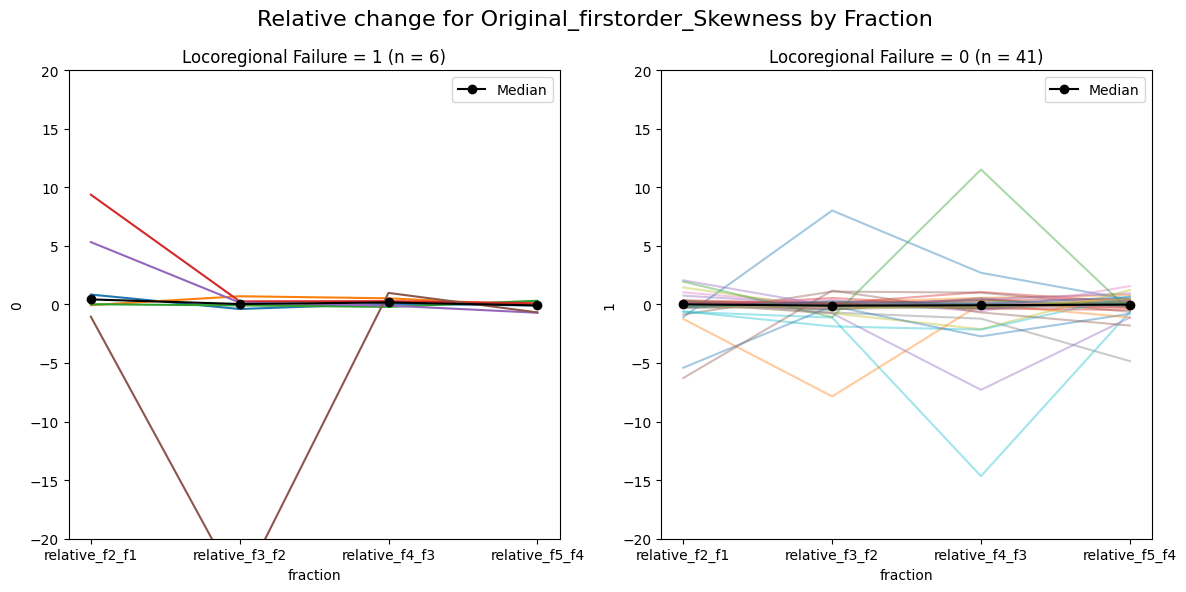

In [103]:
# relative change plot
# relative_fn_fn-1
relative_data_df = pd.concat([relative_f2_f1_new['original_firstorder_Skewness'], relative_f3_f2_new['original_firstorder_Skewness'],
                               relative_f4_f3_new['original_firstorder_Skewness'], relative_f5_f4_new['original_firstorder_Skewness']], axis=1)
relative_data_df.columns = ['relative_f2_f1', 'relative_f3_f2', 'relative_f4_f3', 'relative_f5_f4']
relative_data_df['Locoregional_failure'] = survival_df['Local_failure']
g1_re = relative_data_df[relative_data_df['Locoregional_failure'] == 1] # local failure group
g2_re = relative_data_df[relative_data_df['Locoregional_failure'] == 0] # no local failure group
g1_re = g1_re.drop(columns = 'Locoregional_failure').T
g1_re['fraction'] = ['relative_f2_f1', 'relative_f3_f2', 'relative_f4_f3', 'relative_f5_f4']
g1_re.index = [0, 1, 2, 3]
g2_re = g2_re.drop(columns = 'Locoregional_failure').T
g2_re['fraction'] = ['relative_f2_f1', 'relative_f3_f2', 'relative_f4_f3', 'relative_f5_f4']
g2_re.index = [0, 1, 2, 3]
# add median column
g1_re.insert(6, 'Median', g1_re.median(axis=1))
g2_re.insert(41, 'Median', g2_re.median(axis=1))

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot for the group with Local_failure == 1
for i in range(len(g1_re.columns)-2):
    sns.lineplot(x='fraction', y=g1_re.columns[i], data=g1_re, ax=axes[0])

axes[0].set(ylim = (-20,20), title='Locoregional Failure = 1 (n = 6)')
axes[0].plot(g1_re['fraction'], g1_re['Median'], marker='o', linestyle='-', label='Median', color = 'black')

# Plot for the group with Local_failure == 0
for i in range(len(g2_re.columns)-2):
    sns.lineplot(x='fraction', y=g2_re.columns[i], data=g2_re, alpha=0.4, ax=axes[1])

axes[1].set(ylim = (-20,20), title='Locoregional Failure = 0 (n = 41)')
axes[1].plot(g2_re['fraction'], g2_re['Median'], marker='o', linestyle='-', label='Median', color = 'black')


axes[0].legend()
axes[1].legend()

plt.suptitle('Relative change for Original_firstorder_Skewness by Fraction', fontsize=16)
plt.tight_layout()
plt.show()

In [95]:
# color intensity based on magnitude of absolute relative_f5_f1
# add color bar legend
import numpy as np
from matplotlib.lines import Line2D
from matplotlib.cm import ScalarMappable

# Whole sample original vs. relative change
# relative_fn_f1 with y-axis changed to percentage
def whole_sample_lineplot(feature):
    relative_data_df = pd.concat([pd.Series(0, index=f1_fea.index, name='f1'), relative_f2_f1_new[feature], relative_f3_f1_new[feature],
                               relative_f4_f1_new[feature], relative_f5_f1_new[feature]], axis=1)
    relative_data_df.columns = ['f1', 'relative_f2_f1', 'relative_f3_f1', 'relative_f4_f1', 'relative_f5_f1']
    relative_data_df = relative_data_df.T
    relative_data_df['fraction'] = ['f1', 'relative_f2_f1', 'relative_f3_f1', 'relative_f4_f1', 'relative_f5_f1']
    
    # new dataset for gradient
    gradient_data = relative_data_df.T.drop(labels=['fraction'])

    # Iterate over columns and ensure numeric values, fill NaN with 0
    for col in gradient_data.columns[1:]:
        gradient_data[col] = pd.to_numeric(gradient_data[col], errors='coerce').fillna(0)

    # Determine the color map based on the trend (increase or decrease)
    cmap = sns.diverging_palette(220, 20, sep=20, as_cmap=True)  # Example color map

    # Adjust color intensity based on magnitude of relative_f5_f1
    colors = gradient_data['relative_f5_f1'].apply(lambda x: 
                    sns.color_palette("Reds_r", as_cmap=True)(1 - x / gradient_data['relative_f5_f1'].abs().max())
                    if x > 0 
                    else 
                    sns.color_palette("Blues_r", as_cmap=True)(1 - abs(x) / gradient_data['relative_f5_f1'].abs().max()))

    # Create subplots
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    
    # Plot for the relative values with shading
    for i in range(len(relative_data_df.columns)-1):
        sns.lineplot(x='fraction', y=relative_data_df.iloc[:,i]*100, data=relative_data_df, ax=axes[0], color=colors[i])

    axes[0].set(title='Relative change from F1 to F5', ylabel='Change of Feature Value (%)')

    # Include the 'Median' plot here
    axes[0].plot(relative_data_df['fraction'], relative_data_df.median(axis=1), marker='o', linestyle='-', label='Median', color='black')

    original_data_df = pd.concat([f1_fea[feature], f2_fea[feature], f3_fea[feature], f4_fea[feature], f5_fea[feature]], axis=1)
    original_data_df.columns = ['f1', 'f2', 'f3', 'f4', 'f5']
    original_data_df = original_data_df.T
    original_data_df['fraction'] = ['f1', 'f2', 'f3', 'f4', 'f5']
    
    # Plot for the original values with shading
    for i in range(len(original_data_df.columns)-1):
        sns.lineplot(x='fraction', y=original_data_df.columns[i], data=original_data_df, ax=axes[1], color=colors[i])

    axes[1].set(title='Original values from F1 to F5', ylabel='Feature Value')
    axes[1].plot(original_data_df['fraction'], original_data_df.median(axis=1), marker='o', linestyle='-', label='Median', color='black')

    # Reverse the color map for the color bar
    cmap_reversed = plt.cm.get_cmap("RdBu_r")

    # Create a color bar legend on the right side
    norm = plt.Normalize(gradient_data['relative_f5_f1'].min(), gradient_data['relative_f5_f1'].max())
    sm = ScalarMappable(cmap=cmap_reversed, norm=norm)
    sm.set_array([])  # This line is required for the color bar to work with a custom cmap

    cbar = plt.colorbar(sm, ax=axes[1], pad=0.01) 
    cbar.set_label('Relative Change (F5 to F1)')

    # Add legends to both subplots
    axes[0].legend()
    
    plt.suptitle('Original values & Relative change values for ' + str(feature) + ' by Fraction', fontsize=16)
    plt.tight_layout()
    plt.show()

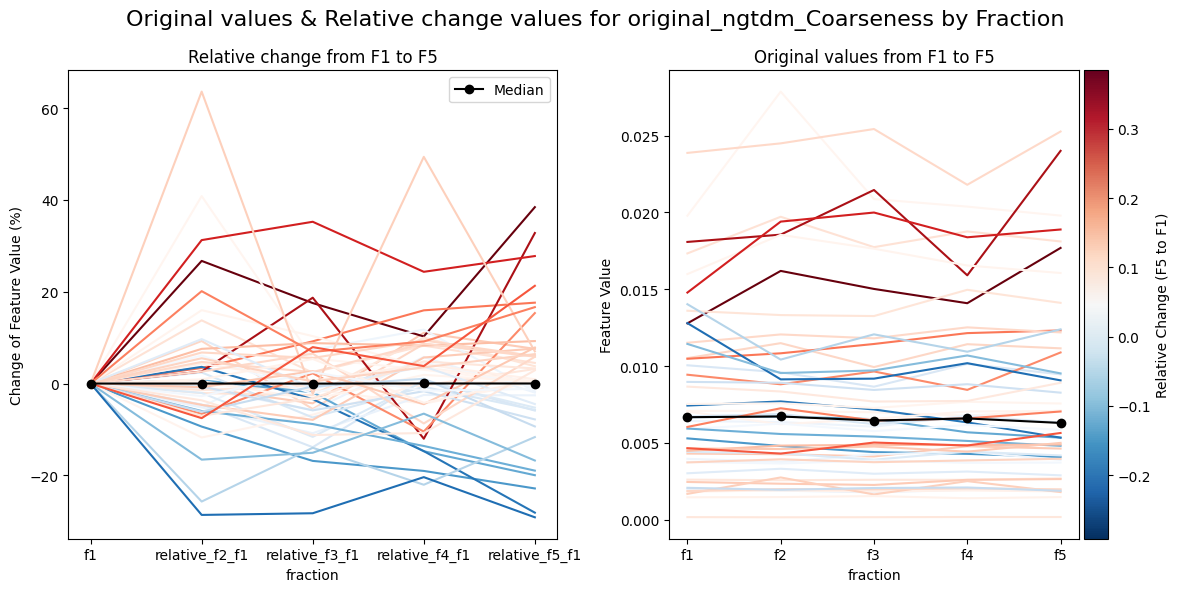

In [96]:
whole_sample_lineplot('original_ngtdm_Coarseness')

In [130]:
relative_f5_f1_new.columns
# original_shape_Elongation: 51.06382978723404
# original_shape_Flatness: 48.93617021276596
# original_shape_Maximum2DDiameterSlice: 42.5531914893617
# original_shape_Sphericity: 53.191489361702125
# original_shape_SurfaceVolumeRatio: 42.5531914893617
# original_firstorder_90Percentile: 59.57446808510638
# original_firstorder_Median: 51.06382978723404
# original_firstorder_Skewness: 36.17021276595745
# original_glcm_DifferenceAverage: 53.191489361702125
# original_glcm_Imc2: 46.808510638297875
# original_gldm_DependenceEntropy: 57.446808510638306
# original_gldm_GrayLevelNonUniformity: 46.808510638297875
# original_gldm_LargeDependenceHighGrayLevelEmphasis: 57.446808510638306
# original_glrlm_RunLengthNonUniformityNormalized: 46.808510638297875
# original_ngtdm_Coarseness: 61.702127659574465

Index(['original_shape_Elongation', 'original_shape_Flatness',
       'original_shape_Maximum2DDiameterSlice', 'original_shape_Sphericity',
       'original_shape_SurfaceVolumeRatio', 'original_firstorder_90Percentile',
       'original_firstorder_Median', 'original_firstorder_Skewness',
       'original_glcm_DifferenceAverage', 'original_glcm_Imc2',
       'original_gldm_DependenceEntropy',
       'original_gldm_GrayLevelNonUniformity',
       'original_gldm_LargeDependenceHighGrayLevelEmphasis',
       'original_glrlm_RunLengthNonUniformityNormalized',
       'original_ngtdm_Coarseness'],
      dtype='object')

In [179]:
# Table S2, see Excel Tables [consistent percentage table]
# find percent of patients with 'relative_f2_f1', 'relative_f3_f1', 'relative_f4_f1', 'relative_f5_f1' always > 0 or < 0 for each feature
def percentage_patients(feature):
    relative_data_df = pd.concat([relative_f2_f1_new[feature], relative_f3_f1_new[feature],
                               relative_f4_f1_new[feature], relative_f5_f1_new[feature]], axis=1)
    relative_data_df.columns = ['relative_f2_f1', 'relative_f3_f1', 'relative_f4_f1', 'relative_f5_f1']
    # Calculate percentage of patients always greater than 0
    greater_than_zero_percentage = (relative_data_df > 0).all(axis=1).sum() / len(relative_data_df) * 100
    
    # Calculate percentage of patients always less than 0
    less_than_zero_percentage = (relative_data_df < 0).all(axis=1).sum() / len(relative_data_df) * 100
    
    return greater_than_zero_percentage, less_than_zero_percentage

In [180]:
feature = 'original_ngtdm_Coarseness'
greater_than_zero_percentage, less_than_zero_percentage = percentage_patients(feature)
print(f"Percentage of patients always greater than 0: {greater_than_zero_percentage}%")
print(f"Percentage of patients always less than 0: {less_than_zero_percentage}%")

Percentage of patients always greater than 0: 25.53191489361702%
Percentage of patients always less than 0: 14.893617021276595%


In [69]:
# Analysis of VoxelVolume
# find percent of patients with 'relative_f2_f1', 'relative_f3_f1', 'relative_f4_f1', 'relative_f5_f1' always > 0 or < 0 for each feature
def percentage_patients(feature):
    relative_data_df = pd.concat([relative_f2_f1[feature], relative_f3_f1[feature],
                               relative_f4_f1[feature], relative_f5_f1[feature]], axis=1)
    relative_data_df.columns = ['relative_f2_f1', 'relative_f3_f1', 'relative_f4_f1', 'relative_f5_f1']
    # Calculate percentage of patients always greater than 0
    greater_than_zero_percentage = (relative_data_df > 0).all(axis=1).sum() / len(relative_data_df) * 100
    
    # Calculate percentage of patients always less than 0
    less_than_zero_percentage = (relative_data_df < 0).all(axis=1).sum() / len(relative_data_df) * 100
    
    return greater_than_zero_percentage, less_than_zero_percentage

In [70]:
feature = 'original_shape_VoxelVolume'
greater_than_zero_percentage, less_than_zero_percentage = percentage_patients(feature)
print(f"Percentage of patients always greater than 0: {greater_than_zero_percentage}%")
print(f"Percentage of patients always less than 0: {less_than_zero_percentage}%")

Percentage of patients always greater than 0: 19.148936170212767%
Percentage of patients always less than 0: 14.893617021276595%


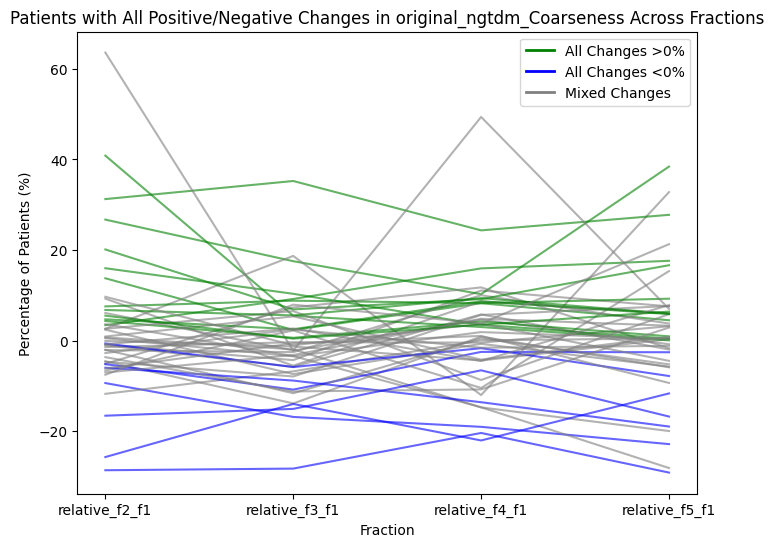

In [316]:
# find percent of patients with 'relative_f2_f1', 'relative_f3_f1', 'relative_f4_f1', 'relative_f5_f1' always > 0 or < 0 for each feature
def plot_supplemental_figure(feature):
    relative_data_df = pd.concat([relative_f2_f1_new[feature], relative_f3_f1_new[feature],
                                  relative_f4_f1_new[feature], relative_f5_f1_new[feature]], axis=1)
    relative_data_df.columns = ['relative_f2_f1', 'relative_f3_f1', 'relative_f4_f1', 'relative_f5_f1']
    relative_data_df = relative_data_df.T
    relative_data_df['fraction'] = ['relative_f2_f1', 'relative_f3_f1', 'relative_f4_f1', 'relative_f5_f1']
    relative_data_df = relative_data_df.T
    fig, ax = plt.subplots(figsize=(8, 6))

    # Check if all patients are >0% or <0%
    all_greater_than_zero = (relative_data_df.iloc[:-1] > 0).all(axis=1)
    all_less_than_zero = (relative_data_df.iloc[:-1] < 0).all(axis=1)

    # Plot lines based on conditions
    x_values = ['relative_f2_f1', 'relative_f3_f1', 'relative_f4_f1', 'relative_f5_f1']
    
    # Initialize legend labels and colors
    legend_labels = {'All Changes >0%': 'green', 'All Changes <0%': 'blue', 'Mixed Changes': 'gray'}
    line_colors = []

    for i in range(len(relative_data_df) - 1):  # Exclude the last row
        condition_label = 'All Changes >0%' if all_greater_than_zero[i] else ('All Changes <0%' if all_less_than_zero[i] else 'Mixed Changes')
        line_color = legend_labels[condition_label]
        line_colors.append(line_color)
        ax.plot(x_values, relative_data_df.iloc[i]*100, color=line_color, alpha=0.6, label=condition_label)

    # Set labels and title
    ax.set_xlabel('Fraction')
    ax.set_ylabel('Percentage of Patients (%)')  # Update Y-axis label based on your actual data
    ax.set_title(f"Patients with All Positive/Negative Changes in {feature} Across Fractions")

    # Add legend with unique labels and colors
    custom_legend = [Line2D([0], [0], color=legend_labels[label], lw=2, label=label) for label in legend_labels.keys()]
    ax.legend(handles=custom_legend)
    plt.show()

feature = 'original_ngtdm_Coarseness'
plot_supplemental_figure(feature)

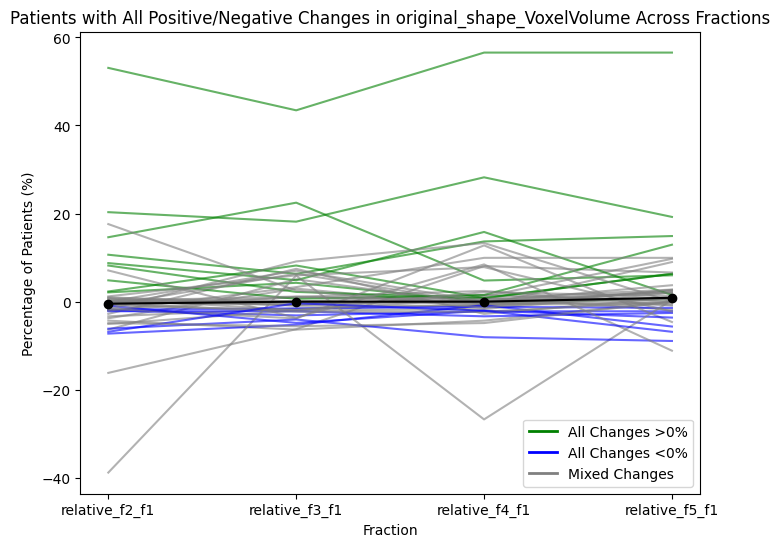

In [60]:
# analysis of VoxelVolume
from matplotlib.lines import Line2D
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

plt.style.use('default')

def plot_supplemental_figure(feature):
    relative_data_df = pd.concat([relative_f2_f1[feature], relative_f3_f1[feature],
                                  relative_f4_f1[feature], relative_f5_f1[feature]], axis=1)
    relative_data_df.columns = ['relative_f2_f1', 'relative_f3_f1', 'relative_f4_f1', 'relative_f5_f1']
    relative_data_df = relative_data_df.T
    relative_data_df['fraction'] = ['relative_f2_f1', 'relative_f3_f1', 'relative_f4_f1', 'relative_f5_f1']
    relative_data_df = relative_data_df.T
    fig, ax = plt.subplots(figsize=(8, 6))

    all_greater_than_zero = (relative_data_df.iloc[:-1] > 0).all(axis=1)
    all_less_than_zero = (relative_data_df.iloc[:-1] < 0).all(axis=1)

    x_values = ['relative_f2_f1', 'relative_f3_f1', 'relative_f4_f1', 'relative_f5_f1']
    
    legend_labels = {'All Changes >0%': 'green', 'All Changes <0%': 'blue', 'Mixed Changes': 'gray'}
    line_colors = []

    for i in range(len(relative_data_df) - 1):
        condition_label = 'All Changes >0%' if all_greater_than_zero[i] else ('All Changes <0%' if all_less_than_zero[i] else 'Mixed Changes')
        line_color = legend_labels[condition_label]
        line_colors.append(line_color)
        ax.plot(x_values, relative_data_df.iloc[i]*100, color=line_color, alpha=0.6, label=condition_label)

    ax.plot(x_values, relative_data_df.iloc[:-1].median(axis=0) * 100, marker='o', linestyle='-', label='Median', color='black')

    ax.set_xlabel('Fraction')
    ax.set_ylabel('Percentage of Patients (%)')
    ax.set_title(f"Patients with All Positive/Negative Changes in {feature} Across Fractions")

    custom_legend = [Line2D([0], [0], color=legend_labels[label], lw=2, label=label) for label in legend_labels.keys()]
    ax.legend(handles=custom_legend)

    plt.show()

feature = 'original_shape_VoxelVolume'
plot_supplemental_figure(feature)


In [67]:
# analysis of VoxelVolume
# CREATE PLOT for each feature
import numpy as np
from matplotlib.lines import Line2D
from matplotlib.cm import ScalarMappable

# Whole sample original vs. relative change
# relative_fn_f1 with y-axis changed to percentage
def whole_sample_lineplot(feature):
    relative_data_df = pd.concat([pd.Series(0, index=f1_fea.index, name='f1'), relative_f2_f1[feature], relative_f3_f1[feature],
                               relative_f4_f1[feature], relative_f5_f1[feature]], axis=1)
    relative_data_df.columns = ['f1', 'relative_f2_f1', 'relative_f3_f1', 'relative_f4_f1', 'relative_f5_f1']
    relative_data_df = relative_data_df.T
    relative_data_df['fraction'] = ['f1', 'relative_f2_f1', 'relative_f3_f1', 'relative_f4_f1', 'relative_f5_f1']
    # new dataset for gradient
    gradient_data = relative_data_df.T.drop(labels=['fraction'])

    # Iterate over columns and ensure numeric values, fill NaN with 0
    for col in gradient_data.columns[1:]:
        gradient_data[col] = pd.to_numeric(gradient_data[col], errors='coerce').fillna(0)

    # Determine the color map based on the trend (increase or decrease)
    cmap = sns.diverging_palette(220, 20, sep=20, as_cmap=True)  # Example color map

    # Adjust color intensity based on magnitude of relative_f5_f1
    colors = gradient_data['relative_f5_f1'].apply(lambda x: 
                    sns.color_palette("Reds_r", as_cmap=True)(1 - x / gradient_data['relative_f5_f1'].abs().max())
                    if x > 0 
                    else 
                    sns.color_palette("Blues_r", as_cmap=True)(1 - abs(x) / gradient_data['relative_f5_f1'].abs().max()))

    # Create subplot with a smaller figsize
    fig, axes = plt.subplots(figsize=(8, 6))
    
    # Plot for the relative values with shading
    for i in range(len(relative_data_df.columns)-1):
        sns.lineplot(x='fraction', y=relative_data_df.iloc[:,i]*100, data=relative_data_df, ax=axes, color=colors[i])

    axes.set(title='Relative change values for ' + str(feature) + ' by Fraction', ylabel='Change of Feature Value (%)')

    # Include the 'Median' plot here
    axes.plot(relative_data_df['fraction'], relative_data_df.median(axis=1), marker='o', linestyle='-', label='Median', color='black')

    # Reverse the color map for the color bar
    #cmap_reversed = plt.cm.get_cmap("RdBu_r")

    # Create a color bar legend on the right side
    norm = plt.Normalize(gradient_data['relative_f5_f1'].min(), gradient_data['relative_f5_f1'].max())
    sm = ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])  # This line is required for the color bar to work with a custom cmap

    cbar = plt.colorbar(sm, ax=axes, pad=0.01) 
    cbar.set_label('Relative Change (F5 to F1)')

    # Add legend
    axes.legend()
    
    #plt.suptitle('Relative change values for ' + str(feature) + ' by Fraction', fontsize=16)
    plt.tight_layout()
    plt.show()

<ipython-input-67-a1f1b6664ba3>:42: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  axes.plot(relative_data_df['fraction'], relative_data_df.median(axis=1), marker='o', linestyle='-', label='Median', color='black')


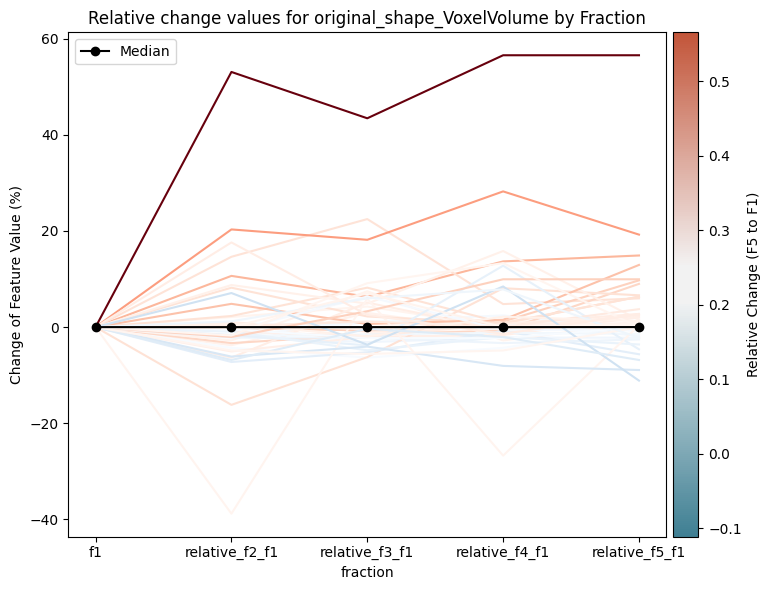

In [68]:
whole_sample_lineplot("original_shape_VoxelVolume")

In [103]:
relative_data_df = pd.concat([pd.Series(0, index=f1_fea.index, name='f1'), relative_f2_f1['original_shape_VoxelVolume'], relative_f3_f1['original_shape_VoxelVolume'],
                               relative_f4_f1['original_shape_VoxelVolume'], relative_f5_f1['original_shape_VoxelVolume']], axis=1)
relative_data_df.columns = ['f1', 'relative_f2_f1', 'relative_f3_f1', 'relative_f4_f1', 'relative_f5_f1']
relative_data_df = relative_data_df.T
relative_data_df['fraction'] = ['f1', 'relative_f2_f1', 'relative_f3_f1', 'relative_f4_f1', 'relative_f5_f1']
# new dataset for gradient
gradient_data = relative_data_df.T.drop(labels=['fraction'])
data_points = gradient_data['relative_f5_f1']
# Iterate over columns and ensure numeric values, fill NaN with 0
for col in gradient_data.columns[1:]:
    gradient_data[col] = pd.to_numeric(gradient_data[col], errors='coerce').fillna(0)

In [104]:
gradient_data

f1  relative_f2_f1  relative_f3_f1  relative_f4_f1  relative_f5_f1
0   0.0       -0.037703        0.029609       -0.009281    9.280742e-03
1   0.0        0.000000       -0.006981        0.003490    2.181501e-02
2   0.0       -0.043147       -0.063452       -0.043147    0.000000e+00
3   0.0       -0.007335        0.009780        0.008557   -1.833741e-02
4   0.0       -0.019956        0.011074        0.024377   -8.881782e-03
5   0.0        0.008104        0.000025       -0.003204   -3.241491e-03
6   0.0        0.106554        0.063178        0.136728    1.489863e-01
7   0.0        0.010195       -0.009423       -0.009043    2.434236e-02
8   0.0        0.146291        0.224750        0.047899    5.985390e-02
9   0.0        0.021043        0.042798        0.000013    5.788516e-03
10  0.0       -0.019567       -0.031214       -0.021896   -2.189611e-02
11  0.0        0.000013        0.000000        0.015437    1.271569e-05
12  0.0       -0.001735       -0.006989        0.011648    9.726267e-02
13  0.0       -0.033306       -0.015820       -0.007494    8.992506e-02
14  0.0        0.082026        0.022160        0.007378    6.354893e-02
15  0.0       -0.050664       -0.020071       -0.016647    2.008422e-02
16  0.0        0.023148        0.082071        0.008418    6.313131e-02
17  0.0       -0.063357        0.050947       -0.006532    2.612671e-02
18  0.0       -0.161754       -0.062488        0.080910    6.617647e-02
19  0.0       -0.072569       -0.052407       -0.008039   -5.645161e-02
20  0.0        0.087556        0.048835        0.158279    1.515152e-02
21  0.0       -0.027753        0.074561       -0.027778    8.771930e-03
22  0.0       -0.018122       -0.015347       -0.011676   -1.411909e-02
23  0.0       -0.008457       -0.019027        0.006342    2.748414e-02
24  0.0        0.048410        0.006503        0.015173    1.293353e-01
25  0.0       -0.007812        0.063616       -0.005580   -6.696429e-03
26  0.0       -0.021767       -0.021779       -0.033303   -2.563297e-02
27  0.0        0.004705       -0.004399        0.001479    9.090909e-03
28  0.0        0.000000        0.000000        0.000000    2.047782e-02
29  0.0       -0.016317       -0.038031        0.127717   -4.618352e-02
30  0.0       -0.009633       -0.048176       -0.020470   -3.613507e-02
31  0.0       -0.004587       -0.022936       -0.022936    0.000000e+00
32  0.0       -0.388104        0.059285       -0.267373    3.729878e-03
33  0.0        0.001899        0.011603        0.000000    3.734177e-02
34  0.0       -0.001877       -0.000626       -0.000626    6.255865e-03
35  0.0        0.203207        0.181640        0.282325    1.924157e-01
36  0.0        0.006833       -0.019474        0.021695    1.247011e-02
37  0.0       -0.061373       -0.040524       -0.080705   -8.929920e-02
38  0.0        0.070896       -0.036692        0.084577   -1.113184e-01
39  0.0       -0.020539        0.033066        0.099490    9.949017e-02
40  0.0        0.530806        0.434439        0.565561    5.655608e-01
41  0.0       -0.068407       -0.003600       -0.020702   -6.840684e-02
42  0.0       -0.048594       -0.055823       -0.048594    7.947286e-08
43  0.0       -0.017493        0.091351        0.133139    7.947286e-08
44  0.0        0.011954        0.059771        0.078482   -2.234919e-02
45  0.0        0.176119        0.025373       -0.013930    2.686567e-02
46  0.0        0.000000        0.070248        0.000000    5.509642e-03

In [113]:
f1['PMRN'][40]

'10142629293'

In [107]:
relative_f2_f1['original_shape_VoxelVolume'].idxmax()
# patient 40 PMRN 10142629293 has large original_shape_VoxelVolume

40

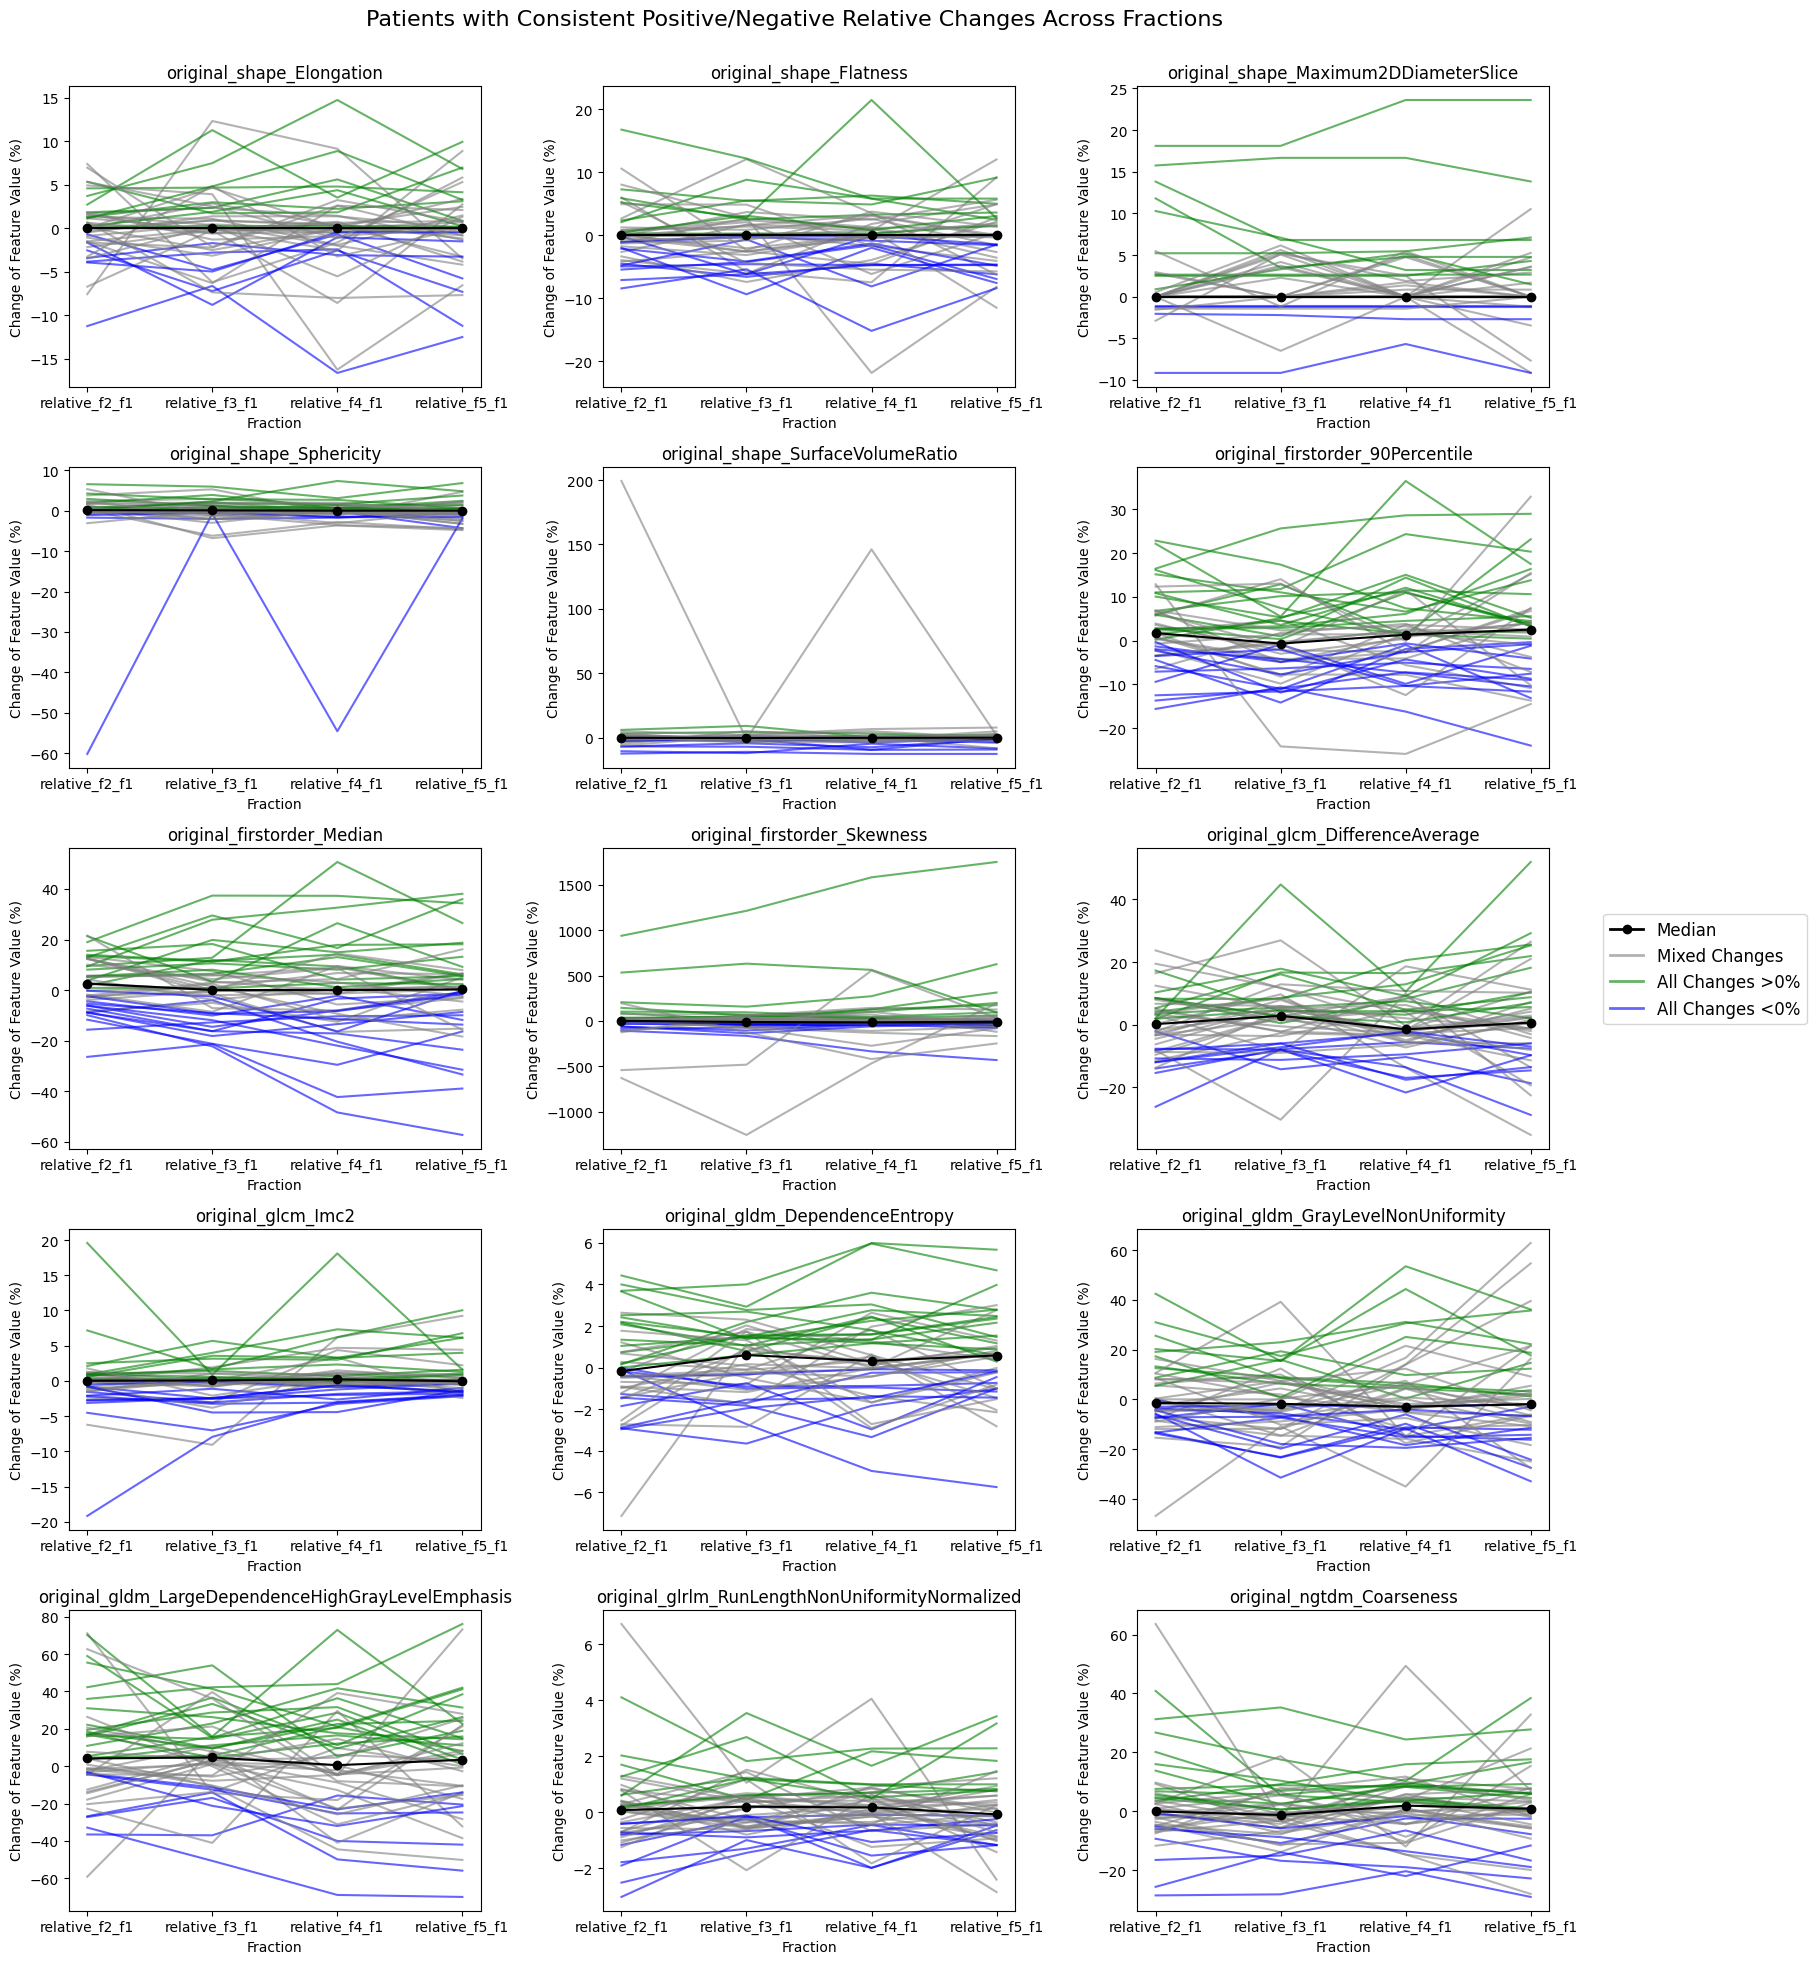

In [64]:
# CREATE PLOTS for all 15 features
def plot_supplemental_figure(feature, ax):
    relative_data_df = pd.concat([relative_f2_f1_new[feature], relative_f3_f1_new[feature],
                                  relative_f4_f1_new[feature], relative_f5_f1_new[feature]], axis=1)
    relative_data_df.columns = ['relative_f2_f1', 'relative_f3_f1', 'relative_f4_f1', 'relative_f5_f1']
    relative_data_df = relative_data_df.T
    relative_data_df['fraction'] = ['relative_f2_f1', 'relative_f3_f1', 'relative_f4_f1', 'relative_f5_f1']
    relative_data_df = relative_data_df.T

    # Check if all patients are >0% or <0%
    all_greater_than_zero = (relative_data_df.iloc[:-1] > 0).all(axis=1)
    all_less_than_zero = (relative_data_df.iloc[:-1] < 0).all(axis=1)

    # Plot lines based on conditions
    x_values = ['relative_f2_f1', 'relative_f3_f1', 'relative_f4_f1', 'relative_f5_f1']

    # Initialize legend labels and colors
    legend_labels = {'All Changes >0%': 'green', 'All Changes <0%': 'blue', 'Mixed Changes': 'gray'}
    line_colors = []

    for i in range(len(relative_data_df) - 1):  # Exclude the last row
        condition_label = 'All Changes >0%' if all_greater_than_zero[i] else ('All Changes <0%' if all_less_than_zero[i] else 'Mixed Changes')
        line_color = legend_labels[condition_label]
        line_colors.append(line_color)
        ax.plot(x_values, relative_data_df.iloc[i] * 100, color=line_color, alpha=0.6, label=condition_label)

    ax.plot(x_values, relative_data_df.iloc[:-1].median(axis=0) * 100, marker='o', linestyle='-', label='Median', color='black')

    # Set labels and title
    ax.set_xlabel('Fraction')
    ax.set_ylabel('Change of Feature Value (%)')  # Update Y-axis label based on your actual data
    ax.set_title(feature)

# List of features to plot
features_to_plot = relative_f5_f1_new.columns

# Set up the 5x3 subplot layout
fig, axes = plt.subplots(5, 3, figsize=(16, 20), gridspec_kw={'height_ratios': [1, 1, 1, 1, 1]})

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Plot each feature
for i, feature in enumerate(features_to_plot):
    # Plot the main lines and median
    plot_supplemental_figure(feature, ax=axes[i])

# Create a common legend for all the plots
custom_legend = [Line2D([0], [0], color='black', lw=2, linestyle='-', marker='o', label='Median')]
custom_legend += [Line2D([0], [0], color='gray', lw=2, alpha=0.6, label='Mixed Changes')]
custom_legend += [Line2D([0], [0], color='green', lw=2, alpha=0.6, label='All Changes >0%')]
custom_legend += [Line2D([0], [0], color='blue', lw=2, alpha=0.6, label='All Changes <0%')]

fig.legend(handles=custom_legend, bbox_to_anchor=(1, 0.5), loc='center left', prop={'size': 12})

# Adjust layout and show the plot
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.suptitle('Patients with Consistent Positive/Negative Relative Changes Across Fractions', fontsize=16)
plt.show()


In [268]:
relative_f5_f1_new.columns

Index(['original_shape_Elongation', 'original_shape_Flatness',
       'original_shape_Maximum2DDiameterSlice', 'original_shape_Sphericity',
       'original_shape_SurfaceVolumeRatio', 'original_firstorder_90Percentile',
       'original_firstorder_Median', 'original_firstorder_Skewness',
       'original_glcm_DifferenceAverage', 'original_glcm_Imc2',
       'original_gldm_DependenceEntropy',
       'original_gldm_GrayLevelNonUniformity',
       'original_gldm_LargeDependenceHighGrayLevelEmphasis',
       'original_glrlm_RunLengthNonUniformityNormalized',
       'original_ngtdm_Coarseness'],
      dtype='object')

In [146]:
# find percent of relative F5 over F1 > 0
(relative_f5_f1_new['original_ngtdm_Coarseness'] > 0).mean() * 100

61.702127659574465

In [140]:
# CREATE PLOT for each feature
import numpy as np
from matplotlib.lines import Line2D
from matplotlib.cm import ScalarMappable

# Whole sample original vs. relative change
# relative_fn_f1 with y-axis changed to percentage
def whole_sample_lineplot(feature):
    relative_data_df = pd.concat([pd.Series(0, index=f1_fea.index, name='f1'), relative_f2_f1_new[feature], relative_f3_f1_new[feature],
                               relative_f4_f1_new[feature], relative_f5_f1_new[feature]], axis=1)
    relative_data_df.columns = ['f1', 'relative_f2_f1', 'relative_f3_f1', 'relative_f4_f1', 'relative_f5_f1']
    relative_data_df = relative_data_df.T
    relative_data_df['fraction'] = ['f1', 'relative_f2_f1', 'relative_f3_f1', 'relative_f4_f1', 'relative_f5_f1']
    
    # new dataset for gradient
    gradient_data = relative_data_df.T.drop(labels=['fraction'])

    # Iterate over columns and ensure numeric values, fill NaN with 0
    for col in gradient_data.columns[1:]:
        gradient_data[col] = pd.to_numeric(gradient_data[col], errors='coerce').fillna(0)

    # Determine the color map based on the trend (increase or decrease)
    cmap = sns.diverging_palette(220, 20, sep=20, as_cmap=True)  # Example color map

    # Adjust color intensity based on magnitude of relative_f5_f1
    colors = gradient_data['relative_f5_f1'].apply(lambda x: 
                    sns.color_palette("Reds_r", as_cmap=True)(1 - x / gradient_data['relative_f5_f1'].abs().max())
                    if x > 0 
                    else 
                    sns.color_palette("Blues_r", as_cmap=True)(1 - abs(x) / gradient_data['relative_f5_f1'].abs().max()))

    # Create subplot with a smaller figsize
    fig, axes = plt.subplots(figsize=(8, 6))
    
    # Plot for the relative values with shading
    for i in range(len(relative_data_df.columns)-1):
        sns.lineplot(x='fraction', y=relative_data_df.iloc[:,i]*100, data=relative_data_df, ax=axes, color=colors[i])

    axes.set(title='Relative change values for ' + str(feature) + ' by Fraction', ylabel='Change of Feature Value (%)')

    # Include the 'Median' plot here
    axes.plot(relative_data_df['fraction'], relative_data_df.median(axis=1), marker='o', linestyle='-', label='Median', color='black')

    # Reverse the color map for the color bar
    cmap_reversed = plt.cm.get_cmap("RdBu_r")

    # Create a color bar legend on the right side
    norm = plt.Normalize(gradient_data['relative_f5_f1'].min(), gradient_data['relative_f5_f1'].max())
    sm = ScalarMappable(cmap=cmap_reversed, norm=norm)
    sm.set_array([])  # This line is required for the color bar to work with a custom cmap

    cbar = plt.colorbar(sm, ax=axes, pad=0.01) 
    cbar.set_label('Relative Change (F5 to F1)')

    # Add legend
    axes.legend()
    
    #plt.suptitle('Relative change values for ' + str(feature) + ' by Fraction', fontsize=16)
    plt.tight_layout()
    plt.show()


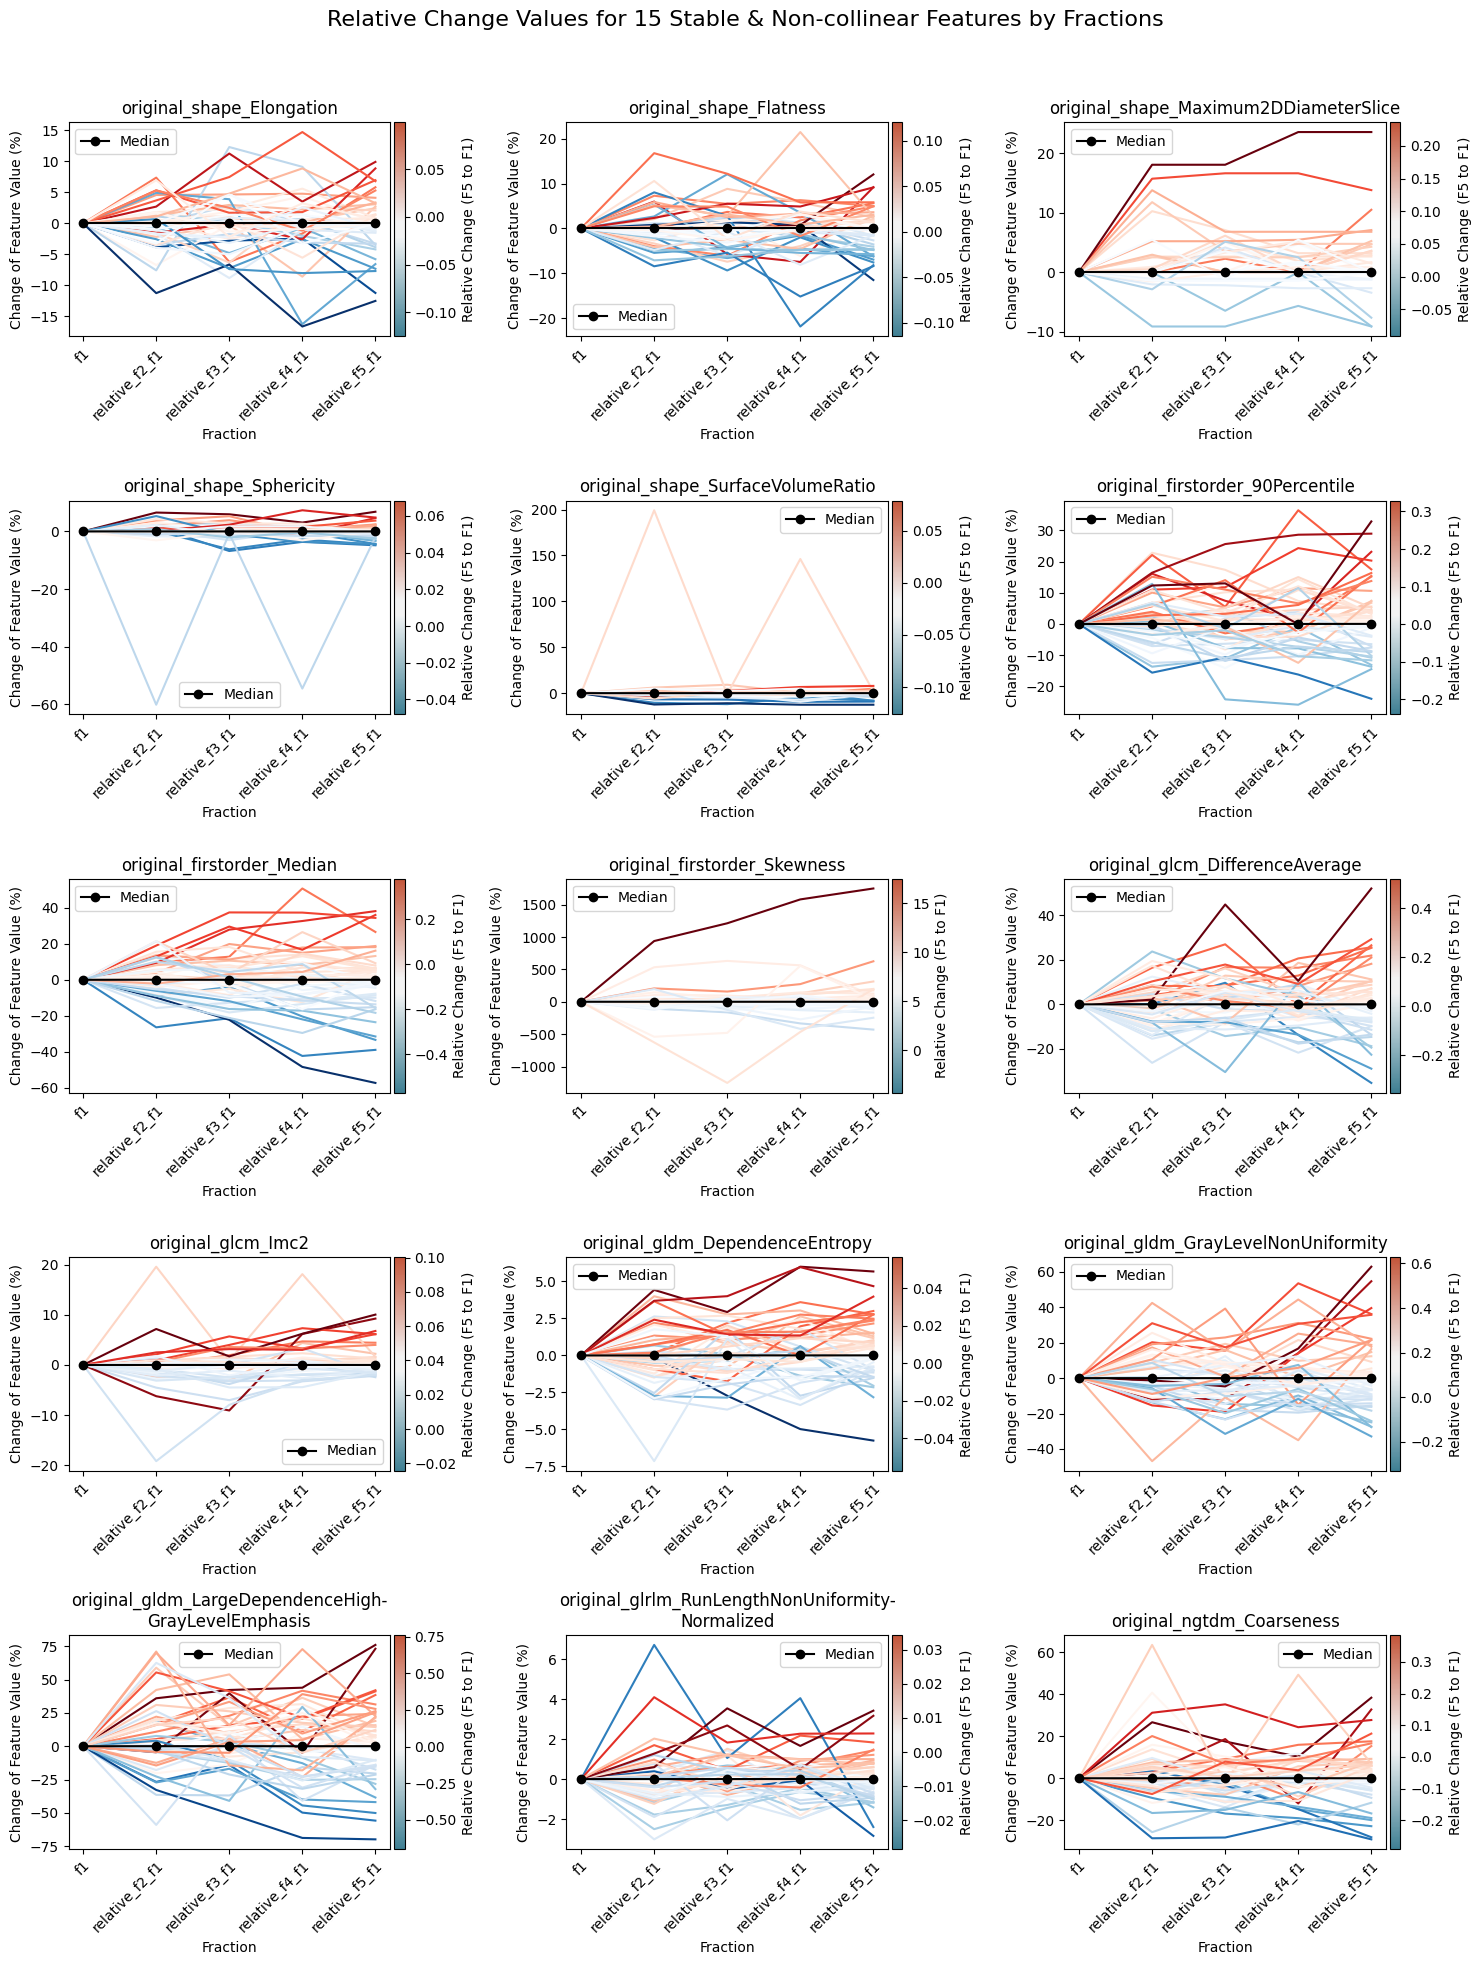

In [143]:
# CREATE PLOTS for all 15 features
from matplotlib.cm import ScalarMappable
plt.style.use('default')  # Set the default style
# List of features to plot
features_to_plot = relative_f5_f1_new.columns

# Set up the 5x3 subplot layout with 1:1 ratio
fig, axes = plt.subplots(5, 3, figsize=(15, 20), gridspec_kw={'height_ratios': [1, 1, 1, 1, 1]})

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Plot each feature
for i, feature in enumerate(features_to_plot):
    plt.sca(axes[i])  # Set the current Axes instance
    relative_data_df = pd.concat([pd.Series(0, index=f1_fea.index, name='f1'), relative_f2_f1_new[feature], relative_f3_f1_new[feature],
                               relative_f4_f1_new[feature], relative_f5_f1_new[feature]], axis=1)
    relative_data_df.columns = ['f1', 'relative_f2_f1', 'relative_f3_f1', 'relative_f4_f1', 'relative_f5_f1']
    relative_data_df = relative_data_df.T
    relative_data_df['Fraction'] = ['f1', 'relative_f2_f1', 'relative_f3_f1', 'relative_f4_f1', 'relative_f5_f1']
    gradient_data = relative_data_df.T.drop(labels=['Fraction'])
    for col in gradient_data.columns[1:]:
        gradient_data[col] = pd.to_numeric(gradient_data[col], errors='coerce').fillna(0)
    cmap = sns.diverging_palette(220, 20, sep=20, as_cmap=True)
    colors = gradient_data['relative_f5_f1'].apply(lambda x: 
                    sns.color_palette("Reds_r", as_cmap=True)(1 - x / gradient_data['relative_f5_f1'].abs().max())
                    if x > 0 
                    else 
                    sns.color_palette("Blues_r", as_cmap=True)(1 - abs(x) / gradient_data['relative_f5_f1'].abs().max()))
    for j in range(len(relative_data_df.columns)-1):
        sns.lineplot(x='Fraction', y=relative_data_df.iloc[:,j]*100, data=relative_data_df, ax=plt.gca(), color=colors[j])

    # Modify subplot title for the specific feature
    if feature == 'original_gldm_LargeDependenceHighGrayLevelEmphasis':
        plt.title('original_gldm_LargeDependenceHigh-\nGrayLevelEmphasis', fontsize=12)
    elif feature == 'original_glrlm_RunLengthNonUniformityNormalized':
        plt.title('original_glrlm_RunLengthNonUniformity-\nNormalized', fontsize=12)
    else:
        plt.title(feature, fontsize=12)

    plt.ylabel('Change of Feature Value (%)')
    plt.plot(relative_data_df['Fraction'], relative_data_df.median(axis=1), marker='o', linestyle='-', label='Median', color='black')

    # Add color bar
    norm = plt.Normalize(gradient_data['relative_f5_f1'].min(), gradient_data['relative_f5_f1'].max())
    sm = ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])  # This line is required for the color bar to work with a custom cmap

    cbar = plt.colorbar(sm, pad=0.01) 
    cbar.set_label('Relative Change (F5 to F1)')

    # Add legend for the median line
    plt.legend()

    # Tilt x-labels
    plt.xticks(rotation=45, ha="right", rotation_mode="anchor")
    plt.subplots_adjust(bottom=0.15)

plt.suptitle('Relative Change Values for 15 Stable & Non-collinear Features by Fractions', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


In [142]:
relative_f5_f1_new.columns

Index(['original_shape_Elongation', 'original_shape_Flatness',
       'original_shape_Maximum2DDiameterSlice', 'original_shape_Sphericity',
       'original_shape_SurfaceVolumeRatio', 'original_firstorder_90Percentile',
       'original_firstorder_Median', 'original_firstorder_Skewness',
       'original_glcm_DifferenceAverage', 'original_glcm_Imc2',
       'original_gldm_DependenceEntropy',
       'original_gldm_GrayLevelNonUniformity',
       'original_gldm_LargeDependenceHighGrayLevelEmphasis',
       'original_glrlm_RunLengthNonUniformityNormalized',
       'original_ngtdm_Coarseness'],
      dtype='object')

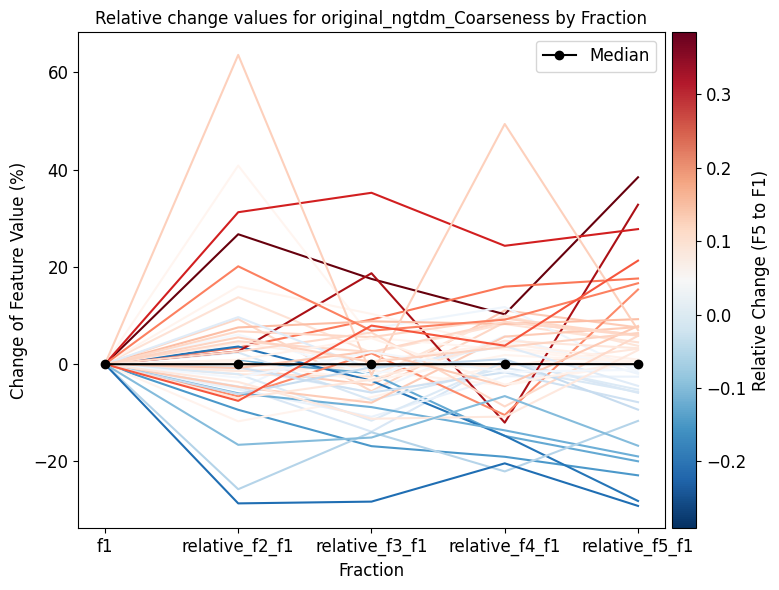

In [211]:
whole_sample_lineplot('original_ngtdm_Coarseness')

In [265]:
relative_f5_f1['original_gldm_LargeDependenceHighGrayLevelEmphasis']

0     0.149202
1     0.031248
2    -0.558554
3     0.243057
4    -0.384906
5     0.384587
6    -0.419576
7     0.158631
8    -0.205268
9     0.065817
10    0.313732
11    0.760567
12    0.068110
13   -0.699144
14    0.411584
15    0.111203
16   -0.174823
17    0.000113
18    0.731807
19    0.189497
20    0.144197
21    0.420144
22    0.081337
23   -0.105160
24    0.082574
25   -0.026593
26    0.220381
27    0.034046
28   -0.501303
29   -0.282801
30   -0.007161
31   -0.321787
32   -0.140255
33   -0.247464
34    0.263337
35   -0.146799
36   -0.139858
37    0.009401
38    0.213322
39   -0.102452
40   -0.154068
41    0.122710
42    0.226506
43    0.254977
44   -0.213372
45    0.280202
46   -0.107426
Name: original_gldm_LargeDependenceHighGrayLevelEmphasis, dtype: float64

In [263]:
f1['original_firstorder_Skewness']

0    -0.414392
1     0.970860
2     0.257365
3    -0.347385
4     0.261259
5     0.817434
6     0.552999
7     1.074843
8    -0.738914
9    -0.225476
10    0.479459
11    1.900363
12    0.278906
13   -0.314318
14    0.358144
15    0.844183
16    0.357202
17    0.425126
18    0.612146
19    1.202821
20    0.687552
21   -0.166862
22   -0.683525
23    0.021770
24   -0.035748
25    0.848436
26    0.636308
27    1.184993
28    0.430884
29    0.054747
30   -0.516975
31    0.680203
32   -1.072130
33   -0.307852
34    0.109509
35    0.066375
36    0.245923
37   -0.095246
38    0.503228
39   -0.501677
40   -0.141728
41    0.020511
42    1.461347
43    1.329473
44   -0.593025
45    0.851776
46    0.724154
Name: original_firstorder_Skewness, dtype: float64

In [75]:
# Whole sample original vs. relative change
# relative_fn_fn-1
def whole_sample_lineplot(feature):
    relative_data_df = pd.concat([relative_f2_f1_new[feature], relative_f3_f2_new[feature],
                               relative_f4_f3_new[feature], relative_f5_f4_new[feature]], axis=1)
    relative_data_df.columns = ['relative_f2_f1', 'relative_f3_f2', 'relative_f4_f3', 'relative_f5_f4']
    relative_data_df = relative_data_df.T
    relative_data_df['fraction'] = ['relative_f2_f1', 'relative_f3_f2', 'relative_f4_f3', 'relative_f5_f4']
    relative_data_df.insert(47, 'Median', relative_data_df.median(axis=1))


    # Create subplots
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    # Plot for the relative values
    for i in range(len(relative_data_df.columns)-1):
        sns.lineplot(x='fraction', y=relative_data_df.columns[i], data=relative_data_df, ax=axes[0])

    axes[0].set(title='Relative change from F1 to F5', ylabel = 'Feature value')
    axes[0].plot(relative_data_df['fraction'], relative_data_df['Median'], marker='o', linestyle='-', label='Median', color = 'black')
    original_data_df = pd.concat([f1_fea[feature], f2_fea[feature], f3_fea[feature], f4_fea[feature], f5_fea[feature]], axis = 1)
    original_data_df.columns = ['f1', 'f2', 'f3', 'f4', 'f5']
    original_data_df = original_data_df.T
    original_data_df['fraction'] = ['f1', 'f2', 'f3', 'f4', 'f5']
    original_data_df.insert(47, 'Median', original_data_df.median(axis=1))


    # Plot for the original values
    for i in range(len(original_data_df.columns)-1):
        sns.lineplot(x='fraction', y=original_data_df.columns[i], data=original_data_df, alpha=0.4, ax=axes[1])

    axes[1].set(title='Original values from F1 to F5', ylabel = 'Feature value')
    axes[1].plot(original_data_df['fraction'], original_data_df['Median'], marker='o', linestyle='-', label='Median', color = 'black')

    axes[0].legend()
    axes[1].legend()

    plt.suptitle('Original values & Relative change values for ' + str(feature) + ' by Fraction', fontsize=16)
    plt.tight_layout()
    plt.show()

<ipython-input-75-56a61c1981c3>:8: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  relative_data_df.insert(47, 'Median', relative_data_df.median(axis=1))
<ipython-input-75-56a61c1981c3>:23: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  original_data_df.insert(47, 'Median', original_data_df.median(axis=1))


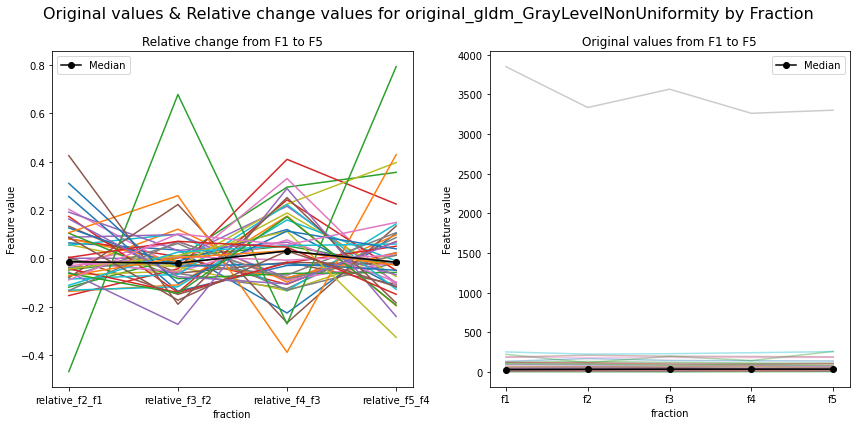

In [76]:
whole_sample_lineplot('original_gldm_GrayLevelNonUniformity')

In [156]:
# Whole sample original vs. relative change
# relative_fn_f1 with y-axis changed to percentage
def whole_sample_lineplot(feature):
    relative_data_df = pd.concat([relative_f2_f1_new[feature], relative_f3_f1_new[feature],
                               relative_f4_f1_new[feature], relative_f5_f1_new[feature]], axis=1)
    relative_data_df.columns = ['relative_f2_f1', 'relative_f3_f1', 'relative_f4_f1', 'relative_f5_f1']
    relative_data_df = relative_data_df.T
    relative_data_df['fraction'] = ['baseline_f1'] + ['relative_f2_f1', 'relative_f3_f1', 'relative_f4_f1', 'relative_f5_f1']
    relative_data_df.insert(47, 'Median', relative_data_df.median(axis=1))

    # Create subplots
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    # Plot for the relative values
    for i in range(len(relative_data_df.columns)-1):
        sns.lineplot(x='fraction', y=relative_data_df.iloc[:,i]*100, data=relative_data_df, ax=axes[0])

    axes[0].scatter('f1', 0, color='red', label='Baseline (f1=0)')
    axes[0].set(title='Relative change from F1 to F5', ylabel = 'Change of Feature Value (%)')
    axes[0].plot(relative_data_df['fraction'], relative_data_df['Median'], marker='o', linestyle='-', label='Median', color = 'black')
    original_data_df = pd.concat([f1_fea[feature], f2_fea[feature], f3_fea[feature], f4_fea[feature], f5_fea[feature]], axis = 1)
    original_data_df.columns = ['f1', 'f2', 'f3', 'f4', 'f5']
    original_data_df = original_data_df.T
    original_data_df['fraction'] = ['f1', 'f2', 'f3', 'f4', 'f5']
    original_data_df.insert(47, 'Median', original_data_df.median(axis=1))


    # Plot for the original values
    for i in range(len(original_data_df.columns)-1):
        sns.lineplot(x='fraction', y=original_data_df.columns[i], data=original_data_df, alpha=0.4, ax=axes[1])

    axes[1].set(title='Original values from F1 to F5', ylabel = 'Feature Value')
    axes[1].plot(original_data_df['fraction'], original_data_df['Median'], marker='o', linestyle='-', label='Median', color = 'black')

    axes[0].legend()
    axes[1].legend()

    plt.suptitle('Original values & Relative change values for ' + str(feature) + ' by Fraction', fontsize=16)
    plt.tight_layout()
    plt.show()



In [98]:
# Whole sample original vs. relative change
# relative_fn_f1 with y-axis changed to percentage
# add baseline f1
def whole_sample_lineplot(feature):
    relative_data_df = pd.concat([pd.Series(0, index=f1_fea.index, name='f1'), relative_f2_f1_new[feature], relative_f3_f1_new[feature],
                               relative_f4_f1_new[feature], relative_f5_f1_new[feature]], axis=1)
    relative_data_df.columns = ['f1', 'relative_f2_f1', 'relative_f3_f1', 'relative_f4_f1', 'relative_f5_f1']
    relative_data_df = relative_data_df.T
    relative_data_df['fraction'] = ['baseline_f1'] + ['relative_f2_f1', 'relative_f3_f1', 'relative_f4_f1', 'relative_f5_f1']
    relative_data_df.insert(47, 'Median', relative_data_df.median(axis=1))

    # Create subplots
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    
    # Plot for the relative values
    for i in range(len(relative_data_df.columns)-1):
        sns.lineplot(x='fraction', y=relative_data_df.iloc[:,i]*100, data=relative_data_df, ax=axes[0])

    axes[0].set(title='Relative change from F1 to F5', ylabel='Change of Feature Value (%)')
    axes[0].plot(relative_data_df['fraction'], relative_data_df['Median'], marker='o', linestyle='-', label='Median', color='black')

    original_data_df = pd.concat([f1_fea[feature], f2_fea[feature], f3_fea[feature], f4_fea[feature], f5_fea[feature]], axis=1)
    original_data_df.columns = ['f1', 'f2', 'f3', 'f4', 'f5']
    original_data_df = original_data_df.T
    original_data_df['fraction'] = ['f1', 'f2', 'f3', 'f4', 'f5']
    original_data_df.insert(47, 'Median', original_data_df.median(axis=1))

    # Plot for the original values
    for i in range(len(original_data_df.columns)-1):
        sns.lineplot(x='fraction', y=original_data_df.columns[i], data=original_data_df, alpha=0.4, ax=axes[1])

    axes[1].set(title='Original values from F1 to F5', ylabel='Feature Value')
    axes[1].plot(original_data_df['fraction'], original_data_df['Median'], marker='o', linestyle='-', label='Median', color='black')

    axes[0].legend()
    axes[1].legend()

    plt.suptitle('Original values & Relative change values for ' + str(feature) + ' by Fraction', fontsize=16)
    plt.tight_layout()
    plt.show()


In [205]:
# only color lines with blue and red
# Whole sample original vs. relative change
# relative_fn_f1 with y-axis changed to percentage
def whole_sample_lineplot(feature):
    relative_data_df = pd.concat([pd.Series(0, index=f1_fea.index, name='f1'), relative_f2_f1_new[feature], relative_f3_f1_new[feature],
                               relative_f4_f1_new[feature], relative_f5_f1_new[feature]], axis=1)
    relative_data_df.columns = ['f1', 'relative_f2_f1', 'relative_f3_f1', 'relative_f4_f1', 'relative_f5_f1']
    relative_data_df = relative_data_df.T
    relative_data_df['fraction'] = ['f1'] + ['relative_f2_f1', 'relative_f3_f1', 'relative_f4_f1', 'relative_f5_f1']
    
    # new dataset for gradient
    gradient_data = relative_data_df.T.drop(labels=['fraction'])

    # Iterate over columns and ensure numeric values, fill NaN with 0
    for col in gradient_data.columns[1:]:
        gradient_data[col] = pd.to_numeric(gradient_data[col], errors='coerce').fillna(0)

    # Determine the color map based on the trend (increase or decrease)
    cmap = sns.diverging_palette(220, 20, sep=20, as_cmap=True, s = 0.75)  # Example color map
    colors = gradient_data['relative_f5_f1'].apply(lambda x: sns.color_palette("Blues_d", as_cmap=True)(x) if x > 0 else sns.color_palette("Reds_d", as_cmap=True)(x))

    # Create subplots
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    
    # Plot for the relative values with shading
    for i in range(len(relative_data_df.columns)-1):
        sns.lineplot(x='fraction', y=relative_data_df.iloc[:,i]*100, data=relative_data_df, ax=axes[0], color=colors[i])

    axes[0].set(title='Relative change from F1 to F5', ylabel='Change of Feature Value (%)')

    # Include the 'Median' plot here
    axes[0].plot(relative_data_df['fraction'], relative_data_df.median(axis=1), marker='o', linestyle='-', label='Median', color='black')

    original_data_df = pd.concat([f1_fea[feature], f2_fea[feature], f3_fea[feature], f4_fea[feature], f5_fea[feature]], axis=1)
    original_data_df.columns = ['f1', 'f2', 'f3', 'f4', 'f5']
    original_data_df = original_data_df.T
    original_data_df['fraction'] = ['f1', 'f2', 'f3', 'f4', 'f5']
    
    # Plot for the original values with shading
    for i in range(len(original_data_df.columns)-1):
        sns.lineplot(x='fraction', y=original_data_df.columns[i], data=original_data_df, alpha=0.4, ax=axes[1])

    axes[1].set(title='Original values from F1 to F5', ylabel='Feature Value')
    axes[1].plot(original_data_df['fraction'], original_data_df.median(axis=1), marker='o', linestyle='-', label='Median', color='black')

    # Add legends to both subplots
    axes[0].legend()
    axes[1].legend()

    plt.suptitle('Original values & Relative change values for ' + str(feature) + ' by Fraction', fontsize=16)
    plt.tight_layout()
    plt.show()


In [213]:
# color intensity based on magnitude of absolute relative_f5_f1
# Whole sample original vs. relative change
# relative_fn_f1 with y-axis changed to percentage
def whole_sample_lineplot(feature):
    relative_data_df = pd.concat([pd.Series(0, index=f1_fea.index, name='f1'), relative_f2_f1_new[feature], relative_f3_f1_new[feature],
                               relative_f4_f1_new[feature], relative_f5_f1_new[feature]], axis=1)
    relative_data_df.columns = ['f1', 'relative_f2_f1', 'relative_f3_f1', 'relative_f4_f1', 'relative_f5_f1']
    relative_data_df = relative_data_df.T
    relative_data_df['fraction'] = ['f1'] + ['relative_f2_f1', 'relative_f3_f1', 'relative_f4_f1', 'relative_f5_f1']
    
    # new dataset for gradient
    gradient_data = relative_data_df.T.drop(labels=['fraction'])

    # Iterate over columns and ensure numeric values, fill NaN with 0
    for col in gradient_data.columns[1:]:
        gradient_data[col] = pd.to_numeric(gradient_data[col], errors='coerce').fillna(0)

    # Determine the color map based on the trend (increase or decrease)
    cmap = sns.diverging_palette(220, 20, sep=20, as_cmap=True)  # Example color map

    # Adjust color intensity based on magnitude of relative_f5_f1
    colors = gradient_data['relative_f5_f1'].apply(lambda x: 
                    sns.color_palette("Blues_r", as_cmap=True)(1 - x / gradient_data['relative_f5_f1'].abs().max())
                    if x > 0 
                    else 
                    sns.color_palette("Reds_r", as_cmap=True)(1 - abs(x) / gradient_data['relative_f5_f1'].abs().max()))

    # Create subplots
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    
    # Plot for the relative values with shading
    for i in range(len(relative_data_df.columns)-1):
        sns.lineplot(x='fraction', y=relative_data_df.iloc[:,i]*100, data=relative_data_df, ax=axes[0], color=colors[i])

    axes[0].set(title='Relative change from F1 to F5', ylabel='Change of Feature Value (%)')

    # Include the 'Median' plot here
    axes[0].plot(relative_data_df['fraction'], relative_data_df.median(axis=1), marker='o', linestyle='-', label='Median', color='black')

    original_data_df = pd.concat([f1_fea[feature], f2_fea[feature], f3_fea[feature], f4_fea[feature], f5_fea[feature]], axis=1)
    original_data_df.columns = ['f1', 'f2', 'f3', 'f4', 'f5']
    original_data_df = original_data_df.T
    original_data_df['fraction'] = ['f1', 'f2', 'f3', 'f4', 'f5']
    
    # Plot for the original values with shading
    for i in range(len(original_data_df.columns)-1):
        sns.lineplot(x='fraction', y=original_data_df.columns[i], data=original_data_df, alpha=0.4, ax=axes[1])

    axes[1].set(title='Original values from F1 to F5', ylabel='Feature Value')
    axes[1].plot(original_data_df['fraction'], original_data_df.median(axis=1), marker='o', linestyle='-', label='Median', color='black')

    # Add legends to both subplots
    axes[0].legend()
    axes[1].legend()

    plt.suptitle('Original values & Relative change values for ' + str(feature) + ' by Fraction', fontsize=16)
    plt.tight_layout()
    plt.show()


In [217]:
import numpy as np

# Whole sample original vs. relative change
# relative_fn_f1 with y-axis changed to percentage
def whole_sample_lineplot(feature):
    relative_data_df = pd.concat([pd.Series(0, index=f1_fea.index, name='f1'), relative_f2_f1_new[feature], relative_f3_f1_new[feature],
                               relative_f4_f1_new[feature], relative_f5_f1_new[feature]], axis=1)
    relative_data_df.columns = ['f1', 'relative_f2_f1', 'relative_f3_f1', 'relative_f4_f1', 'relative_f5_f1']
    relative_data_df = relative_data_df.T
    relative_data_df['fraction'] = ['f1', 'relative_f2_f1', 'relative_f3_f1', 'relative_f4_f1', 'relative_f5_f1']
    
    # new dataset for gradient
    gradient_data = relative_data_df.T.drop(labels=['fraction'])

    # Iterate over columns and ensure numeric values, fill NaN with 0
    for col in gradient_data.columns[1:]:
        gradient_data[col] = pd.to_numeric(gradient_data[col], errors='coerce').fillna(0)

    # Determine the color map based on the trend (increase or decrease)
    cmap = sns.diverging_palette(220, 20, sep=20, as_cmap=True)  # Example color map

    # Adjust color intensity based on magnitude of relative_f5_f1
    colors = gradient_data['relative_f5_f1'].apply(lambda x: 
                    sns.color_palette("Blues_r", as_cmap=True)(1 - x / gradient_data['relative_f5_f1'].abs().max())
                    if x > 0 
                    else 
                    sns.color_palette("Reds_r", as_cmap=True)(1 - abs(x) / gradient_data['relative_f5_f1'].abs().max()))

    # Create subplots
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    
    # Plot for the relative values with shading
    for i in range(len(relative_data_df.columns)-1):
        sns.lineplot(x='fraction', y=relative_data_df.iloc[:,i]*100, data=relative_data_df, ax=axes[0], color=colors[i])

    axes[0].set(title='Relative change from F1 to F5', ylabel='Change of Feature Value (%)')

    # Include the 'Median' plot here
    axes[0].plot(relative_data_df['fraction'], relative_data_df.median(axis=1), marker='o', linestyle='-', label='Median', color='black')

    original_data_df = pd.concat([f1_fea[feature], f2_fea[feature], f3_fea[feature], f4_fea[feature], f5_fea[feature]], axis=1)
    original_data_df.columns = ['f1', 'f2', 'f3', 'f4', 'f5']
    original_data_df = original_data_df.T
    original_data_df['fraction'] = ['f1', 'f2', 'f3', 'f4', 'f5']
    
    # Plot for the original values with shading
    for i in range(len(original_data_df.columns)-1):
        sns.lineplot(x='fraction', y=original_data_df.columns[i], data=original_data_df, ax=axes[1], color=colors[i])

    axes[1].set(title='Original values from F1 to F5', ylabel='Feature Value')
    axes[1].plot(original_data_df['fraction'], original_data_df.median(axis=1), marker='o', linestyle='-', label='Median', color='black')

    # Add legends to both subplots
    axes[0].legend()
    axes[1].legend()

    plt.suptitle('Original values & Relative change values for ' + str(feature) + ' by Fraction', fontsize=16)
    plt.tight_layout()
    plt.show()


In [219]:
# legend to show individual patient color
from matplotlib.lines import Line2D

# Whole sample original vs. relative change
# relative_fn_f1 with y-axis changed to percentage
def whole_sample_lineplot(feature):
    relative_data_df = pd.concat([pd.Series(0, index=f1_fea.index, name='f1'), relative_f2_f1_new[feature], relative_f3_f1_new[feature],
                               relative_f4_f1_new[feature], relative_f5_f1_new[feature]], axis=1)
    relative_data_df.columns = ['f1', 'relative_f2_f1', 'relative_f3_f1', 'relative_f4_f1', 'relative_f5_f1']
    relative_data_df = relative_data_df.T
    relative_data_df['fraction'] = ['f1', 'relative_f2_f1', 'relative_f3_f1', 'relative_f4_f1', 'relative_f5_f1']
    
    # new dataset for gradient
    gradient_data = relative_data_df.T.drop(labels=['fraction'])

    # Iterate over columns and ensure numeric values, fill NaN with 0
    for col in gradient_data.columns[1:]:
        gradient_data[col] = pd.to_numeric(gradient_data[col], errors='coerce').fillna(0)

    # Determine the color map based on the trend (increase or decrease)
    cmap = sns.diverging_palette(220, 20, sep=20, as_cmap=True)  # Example color map

    # Adjust color intensity based on magnitude of relative_f5_f1
    colors = gradient_data['relative_f5_f1'].apply(lambda x: 
                    sns.color_palette("Blues_r", as_cmap=True)(1 - x / gradient_data['relative_f5_f1'].abs().max())
                    if x > 0 
                    else 
                    sns.color_palette("Reds_r", as_cmap=True)(1 - abs(x) / gradient_data['relative_f5_f1'].abs().max()))

    # Create subplots
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    
    # Plot for the relative values with shading
    for i in range(len(relative_data_df.columns)-1):
        sns.lineplot(x='fraction', y=relative_data_df.iloc[:,i]*100, data=relative_data_df, ax=axes[0], color=colors[i])

    axes[0].set(title='Relative change from F1 to F5', ylabel='Change of Feature Value (%)')

    # Include the 'Median' plot here
    axes[0].plot(relative_data_df['fraction'], relative_data_df.median(axis=1), marker='o', linestyle='-', label='Median', color='black')

    original_data_df = pd.concat([f1_fea[feature], f2_fea[feature], f3_fea[feature], f4_fea[feature], f5_fea[feature]], axis=1)
    original_data_df.columns = ['f1', 'f2', 'f3', 'f4', 'f5']
    original_data_df = original_data_df.T
    original_data_df['fraction'] = ['f1', 'f2', 'f3', 'f4', 'f5']
    
    # Plot for the original values with shading
    for i in range(len(original_data_df.columns)-1):
        sns.lineplot(x='fraction', y=original_data_df.columns[i], data=original_data_df, ax=axes[1], color=colors[i])

    axes[1].set(title='Original values from F1 to F5', ylabel='Feature Value')
    axes[1].plot(original_data_df['fraction'], original_data_df.median(axis=1), marker='o', linestyle='-', label='Median', color='black')

    # Create custom legend entries for the right subplot
    legend_lines = [Line2D([0], [0], color=color, linewidth=2) for color in colors]
    legend_labels = [f'Patient {i}' for i in range(len(colors))]
    axes[1].legend(legend_lines, legend_labels, loc='upper left')

    # Add legends to both subplots
    axes[0].legend()
    
    plt.suptitle('Original values & Relative change values for ' + str(feature) + ' by Fraction', fontsize=16)
    plt.tight_layout()
    plt.show()


In [139]:
# print out corresponding color gradient values
import numpy as np

# Whole sample original vs. relative change
# relative_fn_f1 with y-axis changed to percentage
def whole_sample_lineplot(feature):
    relative_data_df = pd.concat([pd.Series(0, index=f1_fea.index, name='f1'), relative_f2_f1_new[feature], relative_f3_f1_new[feature],
                               relative_f4_f1_new[feature], relative_f5_f1_new[feature]], axis=1)
    relative_data_df.columns = ['f1', 'relative_f2_f1', 'relative_f3_f1', 'relative_f4_f1', 'relative_f5_f1']
    relative_data_df = relative_data_df.T
    relative_data_df['fraction'] = ['f1'] + ['relative_f2_f1', 'relative_f3_f1', 'relative_f4_f1', 'relative_f5_f1']
    
    # new dataset for gradient
    gradient_data = relative_data_df.T.drop(labels=['fraction'])

    # Iterate over columns and ensure numeric values, fill NaN with 0
    for col in gradient_data.columns[1:]:
        gradient_data[col] = pd.to_numeric(gradient_data[col], errors='coerce').fillna(0)

    # Determine the color map based on the trend (increase or decrease)
    cmap = sns.diverging_palette(220, 20, sep=20, as_cmap=True)  # Example color map
    colors = gradient_data['relative_f5_f1'].apply(lambda x: sns.color_palette("Blues_r", as_cmap=True)(x) if x > 0 else sns.color_palette("Reds", as_cmap=True)(x))

    # Print the values and corresponding colors
    print("Values of relative_f5_f1:")
    print(gradient_data['relative_f5_f1'])
    print("\nColors assigned based on relative_f5_f1:")
    print(colors)

    # Create subplots
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    
    # Plot for the relative values with shading
    for i in range(len(relative_data_df.columns)-1):
        sns.lineplot(x='fraction', y=relative_data_df.iloc[:,i]*100, data=relative_data_df, ax=axes[0], color=colors[i])

    axes[0].set(title='Relative change from F1 to F5', ylabel='Change of Feature Value (%)')

    # Include the 'Median' plot here
    axes[0].plot(relative_data_df['fraction'], relative_data_df.median(axis=1), marker='o', linestyle='-', label='Median', color='black')

    original_data_df = pd.concat([f1_fea[feature], f2_fea[feature], f3_fea[feature], f4_fea[feature], f5_fea[feature]], axis=1)
    original_data_df.columns = ['f1', 'f2', 'f3', 'f4', 'f5']
    original_data_df = original_data_df.T
    original_data_df['fraction'] = ['f1', 'f2', 'f3', 'f4', 'f5']
    
    # Plot for the original values with shading
    for i in range(len(original_data_df.columns)-1):
        sns.lineplot(x='fraction', y=original_data_df.columns[i], data=original_data_df, alpha=0.4, ax=axes[1])

    axes[1].set(title='Original values from F1 to F5', ylabel='Feature Value')
    axes[1].plot(original_data_df['fraction'], original_data_df.median(axis=1), marker='o', linestyle='-', label='Median', color='black')

    # Add legends to both subplots
    axes[0].legend()
    axes[1].legend()

    plt.suptitle('Original values & Relative change values for ' + str(feature) + ' by Fraction', fontsize=16)
    plt.tight_layout()
    plt.show()


In [137]:
relative_data_df = pd.concat([pd.Series(0, index=f1_fea.index, name='f1'), relative_f2_f1_new['original_shape_Flatness'], relative_f3_f1_new['original_shape_Flatness'],
                               relative_f4_f1_new['original_shape_Flatness'], relative_f5_f1_new['original_shape_Flatness']], axis=1)
relative_data_df.columns = ['f1', 'relative_f2_f1', 'relative_f3_f1', 'relative_f4_f1', 'relative_f5_f1']
relative_data_df = relative_data_df.T
relative_data_df['fraction'] = ['f1'] + ['relative_f2_f1', 'relative_f3_f1', 'relative_f4_f1', 'relative_f5_f1']
    
# new dataset for gradient
gradient_data = relative_data_df.T.drop(labels=['fraction'])
relative_data_df

0         1         2         3         4         5  \
f1              0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
relative_f2_f1  0.005237  0.000000 -0.045134  0.008104  0.012388 -0.010631   
relative_f3_f1  0.020676  0.002266 -0.066170  0.023900  0.008497 -0.000698   
relative_f4_f1 -0.061650  0.002699 -0.045134  0.010286  0.026099 -0.001566   
relative_f5_f1  0.003855  0.018666 -0.062049 -0.035705 -0.015979 -0.001577   

                       6         7         8         9  ...        38  \
f1              0.000000  0.000000  0.000000  0.000000  ...  0.000000   
relative_f2_f1 -0.033665 -0.012242  0.059783  0.001496  ...  0.051800   
relative_f3_f1 -0.074284  0.026988 -0.057693 -0.025894  ...  0.027779   
relative_f4_f1 -0.039317  0.012948 -0.074828 -0.000006  ...  0.214747   
relative_f5_f1  0.021389 -0.026702  0.091782  0.002182  ...  0.026804   

                      39        40        41            42            43  \
f1              0.000000  0.000000  0.000000  0.000000e+00  0.000000e+00   
relative_f2_f1 -0.071220  0.167632  0.049251 -4.038879e-03 -1.598809e-03   
relative_f3_f1 -0.062167  0.121812  0.048519 -2.590338e-02  1.570680e-02   
relative_f4_f1 -0.047489  0.058162 -0.017216 -4.038850e-03  3.191607e-02   
relative_f5_f1 -0.047489  0.058162  0.049251  2.357084e-08  2.807483e-08   

                      44        45        46        fraction  
f1              0.000000  0.000000  0.000000              f1  
relative_f2_f1  0.004303  0.105708  0.000000  relative_f2_f1  
relative_f3_f1  0.030911 -0.023661 -0.020702  relative_f3_f1  
relative_f4_f1  0.008210  0.037447  0.000000  relative_f4_f1  
relative_f5_f1  0.030635  0.013680 -0.000104  relative_f5_f1  

[5 rows x 48 columns]

In [355]:
original_data_df = pd.concat([f1_fea['original_gldm_GrayLevelNonUniformity'], f2_fea['original_gldm_GrayLevelNonUniformity'], f3_fea['original_gldm_GrayLevelNonUniformity'], f4_fea['original_gldm_GrayLevelNonUniformity'], f5_fea['original_gldm_GrayLevelNonUniformity']], axis = 1)
original_data_df.columns = ['f1', 'f2', 'f3', 'f4', 'f5']
original_data_df # patient 37 has high original_gldm_GrayLevelNonUniformity

f1           f2           f3           f4           f5
0     46.857309    49.845087    51.556620    39.891101    43.991954
1     34.595113    32.958115    36.926186    33.274783    36.492741
2      9.076142     7.992042     8.002710    10.358090    14.040609
3     19.655257    21.241379    21.377724    19.080000    20.402242
4     11.124169    11.126697    11.122807    13.519481    12.145414
5     18.157212    18.241158    15.518639    15.273171    13.624390
6     53.745875    64.631870    62.052772    82.525508    73.185474
7     96.780133    96.356393    90.300040    78.963550    85.735914
8     21.175532    22.368910    21.597177    18.690355    18.989962
9     30.427121    32.079545    35.279555    30.541697    34.896179
10   136.274633   171.127346   147.886752   143.480114   140.651822
11    17.570694    15.164524    13.493573    15.850633    12.742931
12    39.211998    37.323221    37.597067    39.518135    38.437367
13    33.141549    28.030146    26.807107    37.780201    46.254393
14    32.346637    35.168033    38.608098    35.507704    36.341209
15   188.872774   213.959250   200.694747   197.297284   192.535068
16    72.623737    70.886466    75.816803    68.979132    67.865400
17    45.565643    42.174338    44.753884    38.882972    38.171229
18     7.492647     6.964912     6.600000     7.836735     7.248276
19     9.306452     8.078261     7.127660     8.260163     8.170940
20    16.831650    16.167183    15.969502    17.872093    15.742952
21    30.089181    32.545865    32.096599    29.523308    30.159420
22   122.718846   135.465771   124.059850   116.278261   109.465131
23    10.678647    12.526652    10.758621    13.361345    12.683128
24    31.164740    37.121296    38.320890    40.870463    38.087652
25    27.299107    25.101237    30.687303    22.494949    25.494382
26    19.453265    19.178010    18.091623    19.466225    17.554534
27   118.713196   114.355517   112.021502   104.232211   115.266202
28     7.150171     7.061433     6.815700     8.344710    11.648829
29     9.217391     8.425414     7.864407     9.612048     8.378917
30    42.641180    47.998176    46.442125    45.398279    43.146159
31    16.541284    18.296467    23.034429    14.073552    20.107034
32   224.893600   119.450433   200.404374   146.019293   261.769020
33   123.579325   118.193093   101.412513    99.478059   104.449258
34    93.549891    88.178941    64.089828    82.602504    62.737022
35    14.884892    21.206278    17.176560    21.490884    17.518854
36   190.311582   184.485918   185.878746   184.467982   186.835667
37  3848.956852  3334.102032  3565.069555  3261.089023  3300.845149
38    68.436567    65.425087    66.169787    73.560780    49.508048
39   255.353095   226.910767   232.732375   244.953630   259.390037
40    17.843602    23.375645    20.949339    23.310797    24.223007
41    26.002700    24.122705    24.185185    24.946691    24.232850
42   107.543775   100.825243    86.253084   101.054875    81.471486
43    39.410107    39.538081    42.314337    44.265866    37.674441
44    47.113306    54.779147    50.611574    45.258313    48.330144
45    63.641791    69.126058    57.147501    58.872856    51.945736
46    19.393939    17.658402    19.442728    20.523416    23.567123

In [347]:
len(np.unique(f1["PMRN"]))
f1.pivot_table(index = ['PMRN'], aggfunc ='size')


PMRN
10020981121    1
10022380967    2
10022486475    1
10022522758    1
10023071441    1
10025460949    1
10026040096    1
10026503515    1
10026629575    1
10026787308    1
10040218546    1
10043063741    1
10066719518    1
10068119816    1
10069051893    1
10070575203    2
10070760540    3
10072733859    1
10074696369    1
10077322773    1
10079533757    1
10085346285    1
10088707426    1
10089885502    1
10094326047    1
10106335077    1
10120605729    1
10122928624    1
10124679100    3
10131492307    1
10132166926    1
10134087245    1
10140904193    1
10142629293    2
10144023610    1
10144345807    2
10144477584    1
10144627840    1
10146369177    1
dtype: int64

##### In-field locoregional Failure Free Survival
* Treat in-field locoregional recurrence as an end point
* In-field locoregional recurrence event: 'In_field_locoregional_recurrence' = 1 if f1['In-field locoregional recurrence?'] is Yes
* In-field locoregional recurrence free time: 'In_field_locoregional_recurrence_time' = f1['Date of first Infield locoregional recurrence. If no documented infield LRR, last known date without infield LRR (by chest CT or PET-CT)'] - f1['Radiation start date']. If no documented in-field locoregional recurrence, last known date without in-field locoregional recurrence
* column YZ: In-field locoregional recurrence. 4 cases vs. 43 cases (first filter on column YY: Any locoregional recurrence (either in or out of field)?)

In [517]:
# in-field locoregional recurrence event
f1['In_field_locoregional_recurrence'] = np.where(f1['In-field locoregional recurrence?'] == 'Yes', 1, 0)
# in-field locoregional recurrence (free) time
f1['Date of first Infield locoregional recurrence. If no documented infield LRR, last known date without infield LRR (by chest CT or PET-CT)'] = pd.to_datetime(f1['Date of first Infield locoregional recurrence. If no documented infield LRR, last known date without infield LRR (by chest CT or PET-CT)'], format = '%Y-%m-%d')
f1['Date of first locoregional recurrence. If no documented LRR, last known date without LRR (by chest CT or PET-CT)'] = pd.to_datetime(f1['Date of first locoregional recurrence. If no documented LRR, last known date without LRR (by chest CT or PET-CT)'], format = '%Y-%m-%d')
f1['In_field_locoregional_recurrence_time'] = 0
for i in range(len(f1)):
    if pd.isnull(f1['Date of first Infield locoregional recurrence. If no documented infield LRR, last known date without infield LRR (by chest CT or PET-CT)'][i]) is False:
        f1['In_field_locoregional_recurrence_time'][i] = (f1['Date of first Infield locoregional recurrence. If no documented infield LRR, last known date without infield LRR (by chest CT or PET-CT)'][i] - f1['Radiation start date'][i]).days
    else:
        f1['In_field_locoregional_recurrence_time'][i] = (f1['Date of first locoregional recurrence. If no documented LRR, last known date without LRR (by chest CT or PET-CT)'][i] - f1['Radiation start date'][i]).days
#f1['In_field_locoregional_recurrence_time'] = (f1['Date of first Infield locoregional recurrence. If no documented infield LRR, last known date without infield LRR (by chest CT or PET-CT)'] - f1['Radiation start date']).dt.days.astype('int16')
f1['In_field_locoregional_recurrence_time'].mask((f1['pat_id'] == '10144023610') & (f1['Radiation_start_date'] == '2021-03-19') , d, inplace=True)


print(f1['Date of first Infield locoregional recurrence. If no documented infield LRR, last known date without infield LRR (by chest CT or PET-CT)'][41])
print(f1['Radiation start date'][41])
print(f1['Date of first locoregional recurrence. If no documented LRR, last known date without LRR (by chest CT or PET-CT)'][41])
# NaT
#2021-03-19 00:00:00
#2021-02-09 00:00:00

f1['In_field_locoregional_recurrence_time'][41] # 56
df_new2 = f5_f1_ratio[f1_fea_new2.columns]
df_new2['In_field_locoregional_recurrence'] = f1['In_field_locoregional_recurrence']
df_new2['In_field_locoregional_recurrence_time'] = f1['In_field_locoregional_recurrence_time']
df_new2.to_csv('/Users/yuhelin/Desktop/University/2022 Post-Fall/Kann Lab/Lung Cancer/binCount=64/df_new2.csv')

df_new = f5_f1_ratio[f1_fea_new2.columns]
df_new['Local_failure'] = f1['Local_failure']
df_new['Local_failure_days'] = f1['Local_failure_days']
df_new.to_csv('/Users/yuhelin/Desktop/University/2022 Post-Fall/Kann Lab/Lung Cancer/binCount=64/df_new.csv')

<ipython-input-517-36bdaae7fb5a>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new2['In_field_locoregional_recurrence'] = f1['In_field_locoregional_recurrence']
<ipython-input-517-36bdaae7fb5a>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new2['In_field_locoregional_recurrence_time'] = f1['In_field_locoregional_recurrence_time']
